This notebook processes results of experiments and creates all the figures and tables displayed in the paper.
The results are processed and added as subplots for each experiment, so the final figures will be generated at the end. 

In [1]:
# ================================ #
# set your base path to results == #
# ================================ #
import os
base_path = None
base_path = os.path.expanduser('~/workspace/STPN/results/')
base_path_pendulum = os.path.expanduser('~/workspace/STPN/results/ray/PPO/InvertedPendulum-v2') 
base_path_pong = os.path.expanduser('~/workspace/STPN/results/ray/A2C/PongNoFrameskip-v4')

global_seeds = {
    "ART": [0,1,23,24,42],
    "Maze": [0,1,42],
    # In Pong and Pendulum, the seed value given in this lists is irrelevant, only the number of total seeds. 
    # Results are loaded in order based on provided paths
    "Pong": [0,1,2,3,4], # PongNoFrameskip-v4
    "Pendulum": [0,1,2], # InvertedPendulum-v2
}
global_seeds_eval = global_seeds
global_seeds_ablation = {**global_seeds, 'CFD': [0,1]}
global_seeds_ablation_eval = global_seeds_ablation
assert base_path is not None

In [2]:
import argparse
import glob
import json
import sys
from itertools import product
import pdb
import logging
import ipdb
import copy
from collections import namedtuple
from functools import reduce

import numpy as np
import matplotlib.pyplot as plt

use_science_style = True
# # science plots requirements
# !apt-get update
# !sudo apt-get install dvipng texlive-latex-extra texlive-fonts-recommended cm-super
# !pip install SciencePlots
if use_science_style is True:
    plt.style.reload_library()
    plt.style.use('science')

import pandas as pd
from torch import (
    device as torchdevice,
    load as torchload,
    max as torchmax,
    no_grad
)
import torch

import STPN.Scripts.utils as utils
from STPN.Scripts.nb_utils import (
    moving_average, print_values_bar, read_acc_results_file, load_energy_results, get_path_results,  read_single_result,
    load_energy_results_art, avg_diff_runs, get_immediate_subdirectories, set_to_list, iqr_operator, cat_diff_len,
    get_common_labels
)
from STPN.HebbFF.nb_utils import plot_loss_acc_comparison

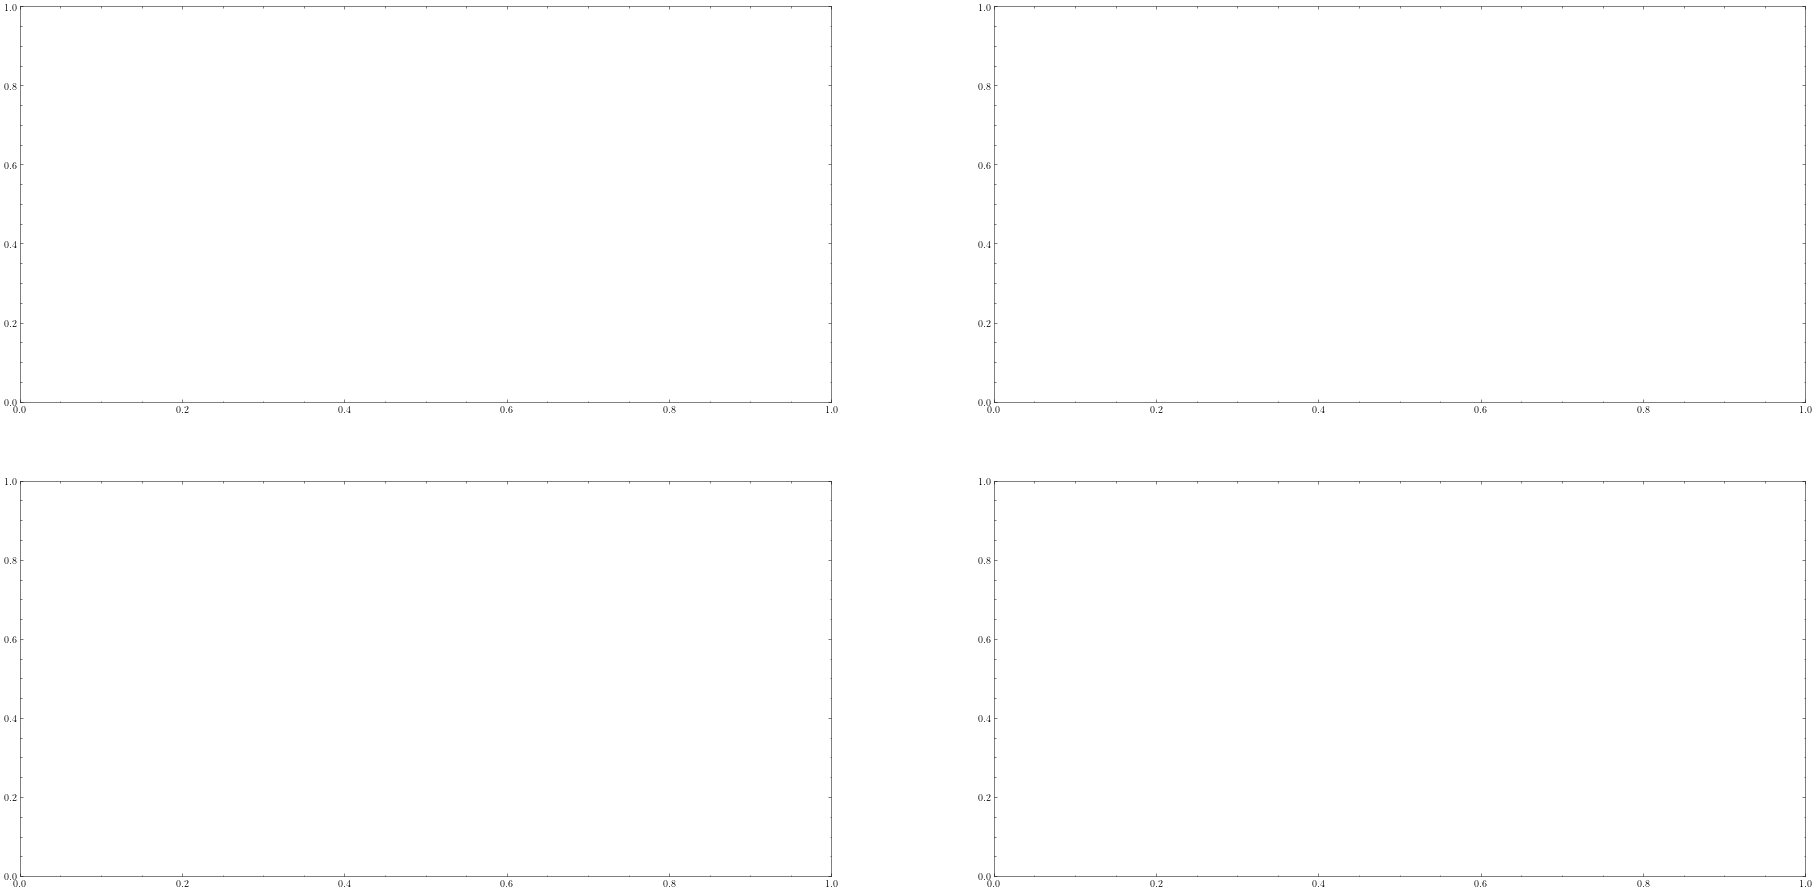

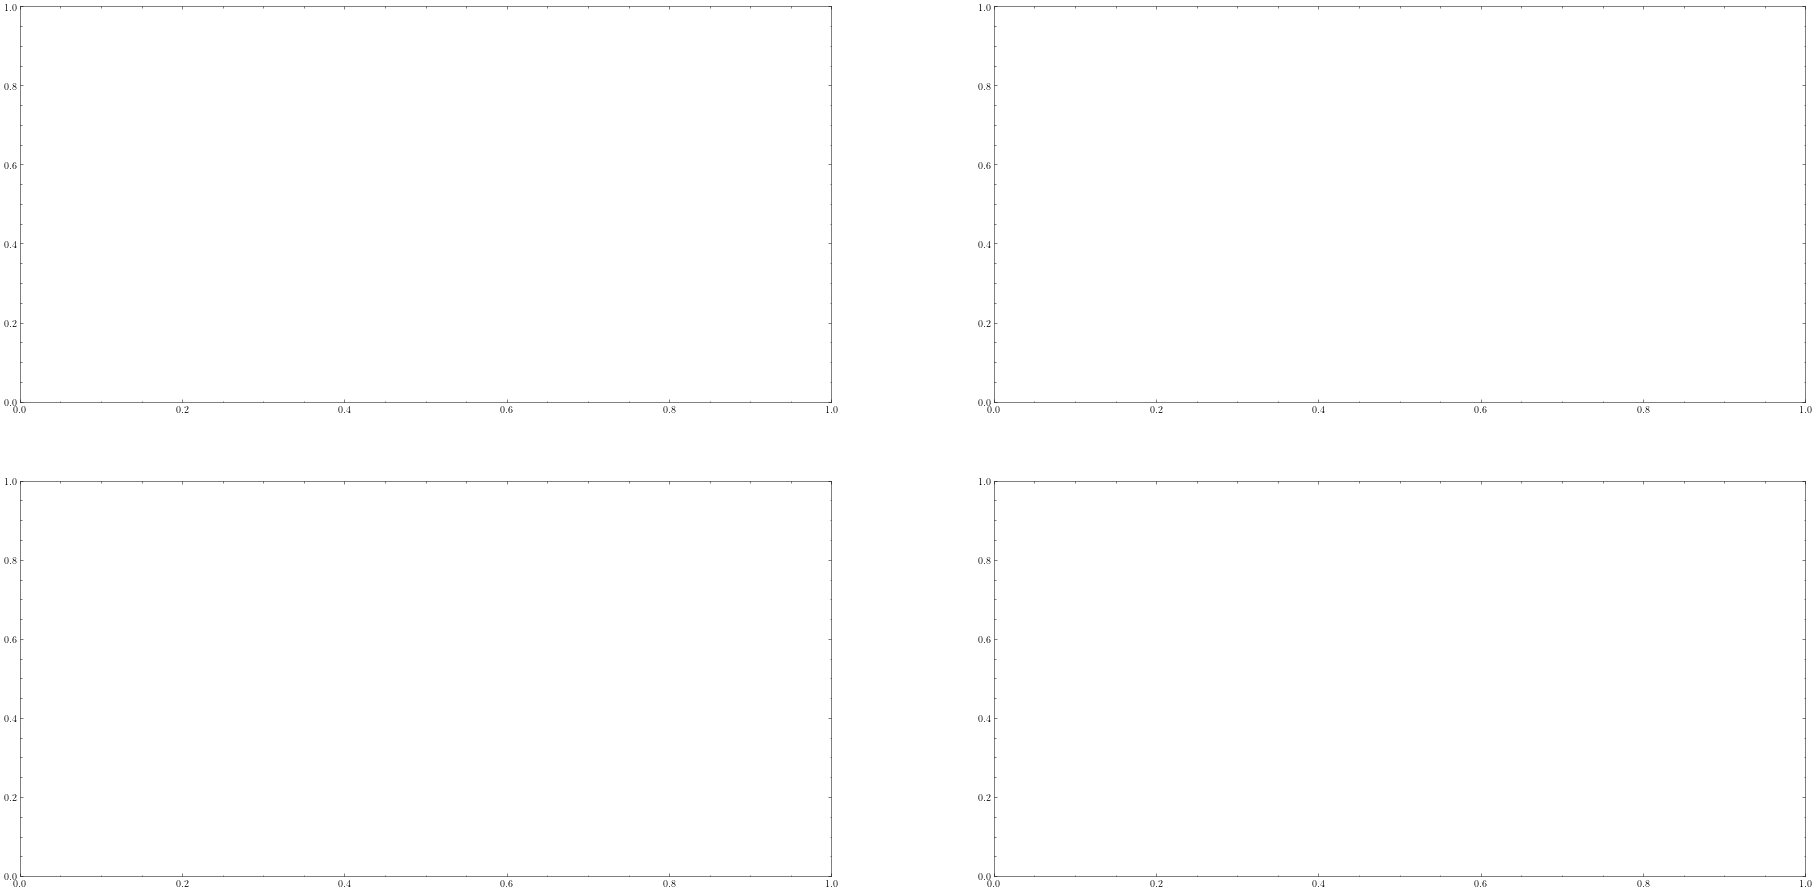

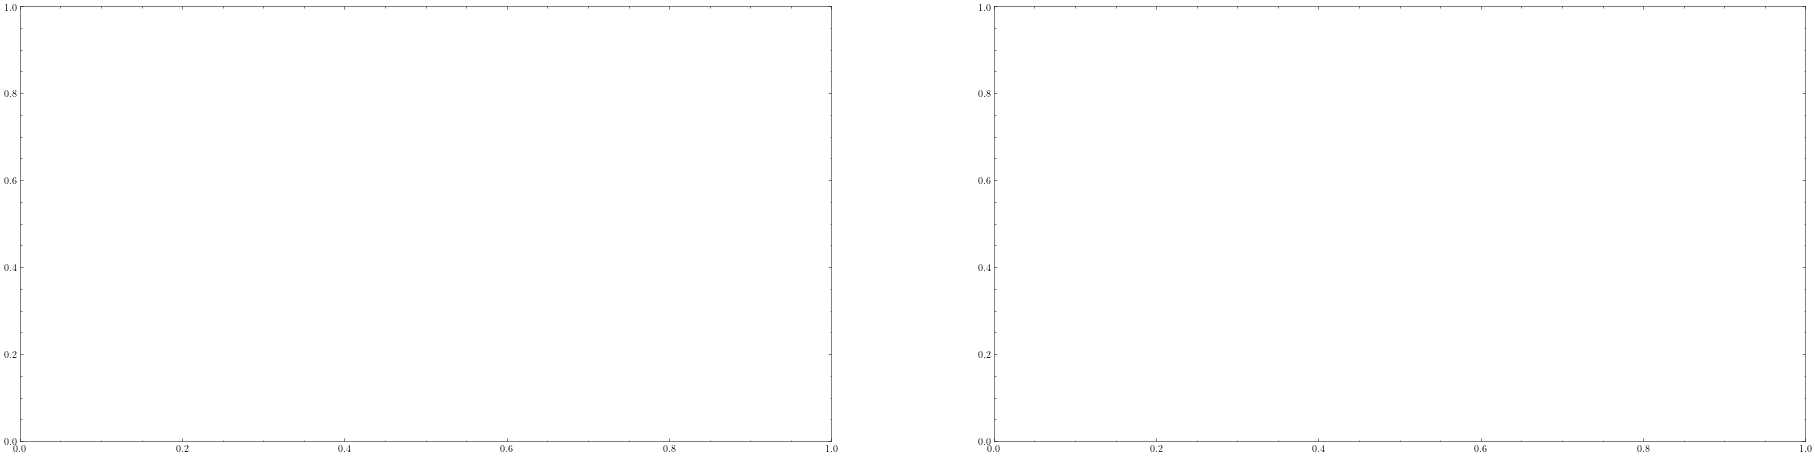

In [3]:
# ================================ #
# global plotting choices ======== #
# ================================ #

global global_colors
# global_colors = {}
global_colors = {
    "STPN (ours)": 'C0',
    "LSTM": 'C3',
    "RNN": 'C1',
    'Fast Weights (Ba et al.)': 'C7',
    'Modplast (Miconi et al.)': 'C2',
    # ====== Meta models =================
    "STPN": 'C0',
    "LSTM": 'C3', 
    "RNN": 'C1',
    'Fast Weights': 'tab:gray',
    'Modplast': 'C2',
    'MLP': 'tab:purple',
    'FW': 'tab:gray',
    'Miconi': 'C2',
    # ==== For ablation studies =========
    'STPNr per-synapse STP (Ours)': 'C0',
    'STPNr uniform STP (Ours)': 'y',
    'STPNf per-synapse STP (Ours)': 'g',
    'STPNf uniform STP (Ours)': 'm',
    'HebbFF': 'k',
    
    'STPNr': 'C0',
    'uSTPNr': 'y',
    'STPNf': 'g',
    'uSTPNf': 'm',
}

default_aspect_ratio = True

# proficiency: reward or acc vs time during training. ART, Maze, Pong, Pendulum
fig_prof, axs_prof = plt.subplots(nrows=2,ncols=2, figsize=(32,16))
prof_ylabel = {
    "ART": 'Validation accuracy (%)',
    'Maze': 'Reward (frequency goal found)', # technically there's also negative rewards for hitting walls, so...
    'Pong': 'Reward (net score)',
    'Pendulum': 'Reward (time balanced)',
}
if use_science_style is True:
    prof_ylabel['ART'] = prof_ylabel['ART'].replace('%', '\%')
prof_xlabel = {
    "ART": 'Epochs', 
    'Maze': 'Iterations', # episodes * batch_size
    'Pong': 'Timesteps',
    'Pendulum': 'Timesteps',
}

# efficiency: energy vs time during eval. ART, Maze, Pong, Pendulum 
fig_eff, axs_eff = plt.subplots(nrows=2,ncols=2, figsize=(32,16))
eff_ylabel = 'Power Consumption'
eff_xlabel = {
    "ART": 'Sequence element', # Sequence step
    'Maze': 'Episode step', # 
    'Pong': 'Episode step',
    'Pendulum': 'Episode step',
}


# efficiency vs profficiency: energy vs reward/accuracy during eval. ART & Maze
fig_eff_vs_prof, axs_eff_vs_prof = plt.subplots(nrows=1,ncols=2, figsize=(32,8))
eff_vs_prof_ylabel = eff_ylabel # energy
eff_vs_prof_xlabel = prof_ylabel # proficiency (reward/acc)


# how to show legend [0,1,2,3, 'joint', 'all']
prof_legend_subplots = 'joint'
eff_legend_subplots = 'joint'
eff_vs_prof_legend_subplots = 'joint'

adjust_4_subplots = {'hspace': 0.3}
adjust_2_subplots = {}

titles = {
    "ART": 'Associative Retrieval Task (Ba et al. 2016)',
    "Maze": 'Maze exploration (Miconi et al. 2018)',
    "Pong": 'Atari Pong', # PongNoFrameskip-v4
    "Pendulum": 'MuJoCo Inverted Pendulum', # InvertedPendulum-v2
}

alphas = {
    "ART": 0.5,
    "Maze": 0.2,
    "Pong": 0.5, # PongNoFrameskip-v4
    "Pendulum": 0.5, # InvertedPendulum-v2
    "CFD": 0.2,
}

model2label = {
    'LSTM': 'LSTM',
    'MLP': 'MLP',
    'RNN': 'RNN',
    'STPN': 'STPN (Ours)',
    # split lines
    'Modplast': 'Modulated Plasticity\n(Miconi et al., 2019)', # modplast
    'FW': 'Fast Weights\n(Ba et al., 2016)',
    
    # ablation
    'STPNr': 'STPNr per-synapse STP (Ours)',
    'uSTPNr': 'STPNr uniform STP (Ours)',
    'STPNf': 'STPNf per-synapse STP (Ours)',
    'uSTPNf': 'STPNf uniform STP (Ours)',
    'HebbFF': 'HebbFF (Tyulmankov et al.)',
    
    'STPNrNet': 'STPNr per-synapse STP (Ours)',
    'uSTPNrNet': 'STPNr uniform STP (Ours)',
    'STPNfNet': 'STPNf per-synapse STP (Ours)',
    'uSTPNfNet': 'STPNf uniform STP (Ours)',
    'HebbNet': 'HebbFF (Tyulmankov et al.)',
    'nnLSTM': 'LSTM',
}
n_ticks = 3 # should probably vary, eg for eff_vs_prof plot, at least for the prof axis
equally_spaced_ticks = True
margin_upper_tick = 0.1
margin_lower_tick = 0

general_font = 30
plt.rcParams.update({'font.size': general_font})
plt.rc('font', size=general_font)
fotsize_title = 22
fontsize_labels = 30 # 19
fontsize_ticks = 18
legend_line_size = 20.0
fontsize_to_dot = 10

# ART

In [4]:
this_experiment = 'ART'

In [5]:
############################
# Load all ART #############
############################

# all subpaths for ART
path_results = os.path.join(base_path, 'AssociativeRetrievalTask')
path_results_proficiency = os.path.join(path_results, 'proficiency/')
path_results_efficiency = os.path.join(path_results, 'efficiency/')
path_models = os.path.join(path_results, 'trained-models/')

# config filenames (without the starting ART_) and short name that keys all other config dictionaries
experiments = {    
    "STPN_h11": {"short": "STPN"},
    "LSTM_h9": {"short": "LSTM"},
    "RNN_h20": {"short": "RNN"},
    "FW_S1_h20": {"short": 'FW'},
    "MODPLAST_h17": {"short": 'Modplast'},
}

# seeds run
seeds = global_seeds[this_experiment]

# instantiate storing structures
energies, val_energies = {}, {}
mean_energies, accuracies, xlabels, all_mean_fixed = [], [], [], []
mean_energies_std, accuracies_std = [], []
val_accuracies_std, val_accuracies_mean, val_accuracies = [], [], {}

for model_name, model_cfg in experiments.items():
    model_mean_energies, model_accuracies,  model_all_mean_fixed = [], [], []
    model_val_accuracies = []
    val_accuracies[model_name] = {}
    print("#"*50)
    print(model_name)
    energies[model_name], val_energies[model_name] = {}, {}
    for seed in seeds:
        print('Seed', seed)
        # ============== test accuracy ============================
        filename = f"ART_from_ART_{model_name}_seed_{seed}"
        accuracy = read_single_result(filename="test_"+filename+'.txt', base=path_results_proficiency)[-1]
        model_accuracies.append(accuracy)
        print("Test accuracy", accuracy)
        
        # ============== validation accuracy curves  ==============
        accuracy = read_acc_results_file(filename="val_"+filename+'.txt',base=path_results_proficiency, separator=",")[-1]
        val_accuracies[model_name][seed] = accuracy 
        model_val_accuracies.append(accuracy)
        print("Validation accuracy", accuracy)
        
        # ============= test energy ======================
        energies[model_name][seed] = load_energy_results_art("test_"+filename, model_name, path_results_efficiency, {})[model_name]
        # num_seqs, seq_len; already summed per hidden unit
        mean_energy = torch.mean(input=torch.Tensor(energies[model_name][seed]), dim=(0,1)) 
        model_mean_energies.append(mean_energy)
        print("Test mean_energy", mean_energy)
                
        # ============= validation energy during training ======================
        val_energies[model_name][seed] = load_energy_results_art('val_' + filename, model_name, path_results_efficiency, {})[model_name]
        print("Validation mean_energy", mean_energy)
    # append summary statistics 
    mean_energies.append(np.mean(model_mean_energies))  # average over seed and sequence
    mean_energies_std.append(np.std(model_mean_energies)) # std over seed and sequence
    accuracies.append(np.mean(model_accuracies)) # average over seed
    accuracies_std.append(np.std(model_accuracies)) # std over seed
    val_accuracies_mean.append(np.mean(model_accuracies, axis=0)) # average over seed, but keep sequence
    val_accuracies_std.append(np.std(model_accuracies, axis=0))  # std over seed, but keep sequence
    # store labels in order
    xlabels.append(experiments[model_name]['short'])
# cast to arrays
mean_energies = np.array(mean_energies)
mean_energies_std = np.array(mean_energies_std)
accuracies_mean = np.array(accuracies)
accuracies_std = np.array(accuracies_std)
val_accuracies_mean = np.array(val_accuracies_mean)
val_accuracies_std = np.array(val_accuracies_std)
xlabels = np.array(xlabels)
xlabels

########################
# Make table ========= #
########################

accuracies_for_df = []
energies_for_df = []
acc_decimals = 2
energy_decimals = 2
for i_model, model_name in enumerate(xlabels):
    accuracies_for_df.append(f"{100*accuracies_mean[i_model]:.{acc_decimals}f}  +- {100*accuracies_std[i_model]:.{acc_decimals}f}")
    energies_for_df.append(f"{mean_energies[i_model]:.{energy_decimals}f}  +- {mean_energies_std[i_model]:.{energy_decimals}f}")
accuracies_for_df = np.array(accuracies_for_df, dtype=object)
energies_for_df = np.array(energies_for_df, dtype=object)
    
data = np.array([np.array(xlabels).T, accuracies_for_df.T, energies_for_df.T], dtype=object)

print(data)
print("Experiment result matrix shape", data.shape)
df_art_eval = pd.DataFrame(data.T, columns=['Model', 'Test accuracy', 'Power consumption'])

##################################################
STPN_h11
Seed 0
Test accuracy 1.0
Validation accuracy [0.3073, 0.4448, 0.577, 0.6528, 0.7106, 0.777, 0.8289, 0.8732, 0.8643, 0.8806, 0.9078, 0.9295, 0.9465, 0.9581, 0.9652, 0.973, 0.9862, 0.9889, 0.9953, 0.9968, 0.9979, 0.9989, 0.9993, 0.9996, 0.9999, 0.9998, 0.9999, 0.9999, 0.9997, 0.9997, 0.9998, 0.9995, 1.0, 0.9998, 0.9998, 1.0, 0.9992, 0.9999, 1.0, 0.9974, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9925, 1.0, 1.0, 1.0, 0.9782, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9925, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9973, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9982, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9989, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9969, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 

Validation mean_energy tensor(64.3935)
Seed 24
Test accuracy 0.46299078525641024
Validation accuracy [0.0998, 0.0998, 0.3102, 0.34, 0.3929, 0.4074, 0.4126, 0.422, 0.4275, 0.4272, 0.4253, 0.4223, 0.4224, 0.424, 0.4236, 0.4241, 0.4238, 0.4247, 0.4261, 0.4248, 0.4261, 0.4254, 0.4265, 0.4287, 0.4281, 0.4278, 0.4277, 0.4281, 0.4274, 0.4275, 0.4303, 0.4321, 0.4329, 0.4344, 0.4335, 0.4337, 0.433, 0.4334, 0.4343, 0.4341, 0.4331, 0.4327, 0.4331, 0.4332, 0.4336, 0.4349, 0.4342, 0.4341, 0.4347, 0.4348, 0.4348, 0.4341, 0.4341, 0.4353, 0.4356, 0.4356, 0.4351, 0.4347, 0.4356, 0.4351, 0.4346, 0.4361, 0.4349, 0.4343, 0.4353, 0.4361, 0.437, 0.4381, 0.4382, 0.4388, 0.439, 0.4391, 0.4407, 0.4404, 0.4404, 0.4418, 0.4413, 0.4411, 0.4416, 0.4408, 0.4404, 0.4404, 0.4409, 0.4402, 0.4404, 0.44, 0.4403, 0.4404, 0.4407, 0.442, 0.4408, 0.4401, 0.4411, 0.4417, 0.4422, 0.4416, 0.4422, 0.4431, 0.4434, 0.4431, 0.4431, 0.4427, 0.4418, 0.4425, 0.4434, 0.4431, 0.4425, 0.4422, 0.4418, 0.4424, 0.4431, 0.4441, 0.4439, 0.44

Validation accuracy [0.4332, 0.4378, 0.4292, 0.424, 0.4261, 0.4224, 0.4243, 0.427, 0.4273, 0.4238, 0.4254, 0.4284, 0.4291, 0.4288, 0.4289, 0.4305, 0.4282, 0.4284, 0.4286, 0.4301, 0.4302, 0.4304, 0.4338, 0.4339, 0.4336, 0.4337, 0.4346, 0.4345, 0.4348, 0.4334, 0.4359, 0.4365, 0.436, 0.436, 0.4351, 0.4372, 0.4395, 0.4441, 0.4487, 0.4538, 0.4561, 0.4607, 0.4608, 0.4642, 0.4688, 0.4737, 0.4794, 0.4858, 0.4859, 0.492, 0.5029, 0.5104, 0.5196, 0.5304, 0.5412, 0.5458, 0.549, 0.5584, 0.563, 0.5709, 0.5779, 0.5846, 0.5972, 0.6081, 0.6184, 0.6278, 0.6334, 0.638, 0.6439, 0.6492, 0.655, 0.661, 0.6655, 0.6702, 0.6741, 0.6784, 0.6838, 0.6858, 0.6876, 0.6902, 0.6935, 0.6966, 0.7011, 0.7038, 0.708, 0.7122, 0.7134, 0.7154, 0.7185, 0.7198, 0.7221, 0.7241, 0.7249, 0.7246, 0.7262, 0.7294, 0.7308, 0.7319, 0.7345, 0.7362, 0.7394, 0.7412, 0.7425, 0.7431, 0.744, 0.7461, 0.7476, 0.7496, 0.7511, 0.7517, 0.7528, 0.7549, 0.7553, 0.7557, 0.7555, 0.7559, 0.7558, 0.7573, 0.7574, 0.758, 0.7582, 0.7586, 0.7596, 0.7602, 

In [6]:
# store for later
art_eval_energies = energies

In [7]:
df_art_eval

Model    Test accuracy Power consumption
0      STPN   99.99  +- 0.01     3.44  +- 0.39
1      LSTM   47.28  +- 3.16    65.64  +- 3.40
2       RNN   46.83  +- 5.56    42.99  +- 4.86
3        FW   80.87  +- 1.67   80.60  +- 69.40
4  Modplast  61.49  +- 15.79    32.04  +- 7.36

## Energy vs episode step eval

In [8]:
plot_shaded = 'std' # [ False, 'std', 'min_max']
plot_line = 'mean' # [ 'mean', 'median']
plot_subplots = True

STPN C0
RNN C1
LSTM C3
Miconi C2
Fast Weights tab:gray


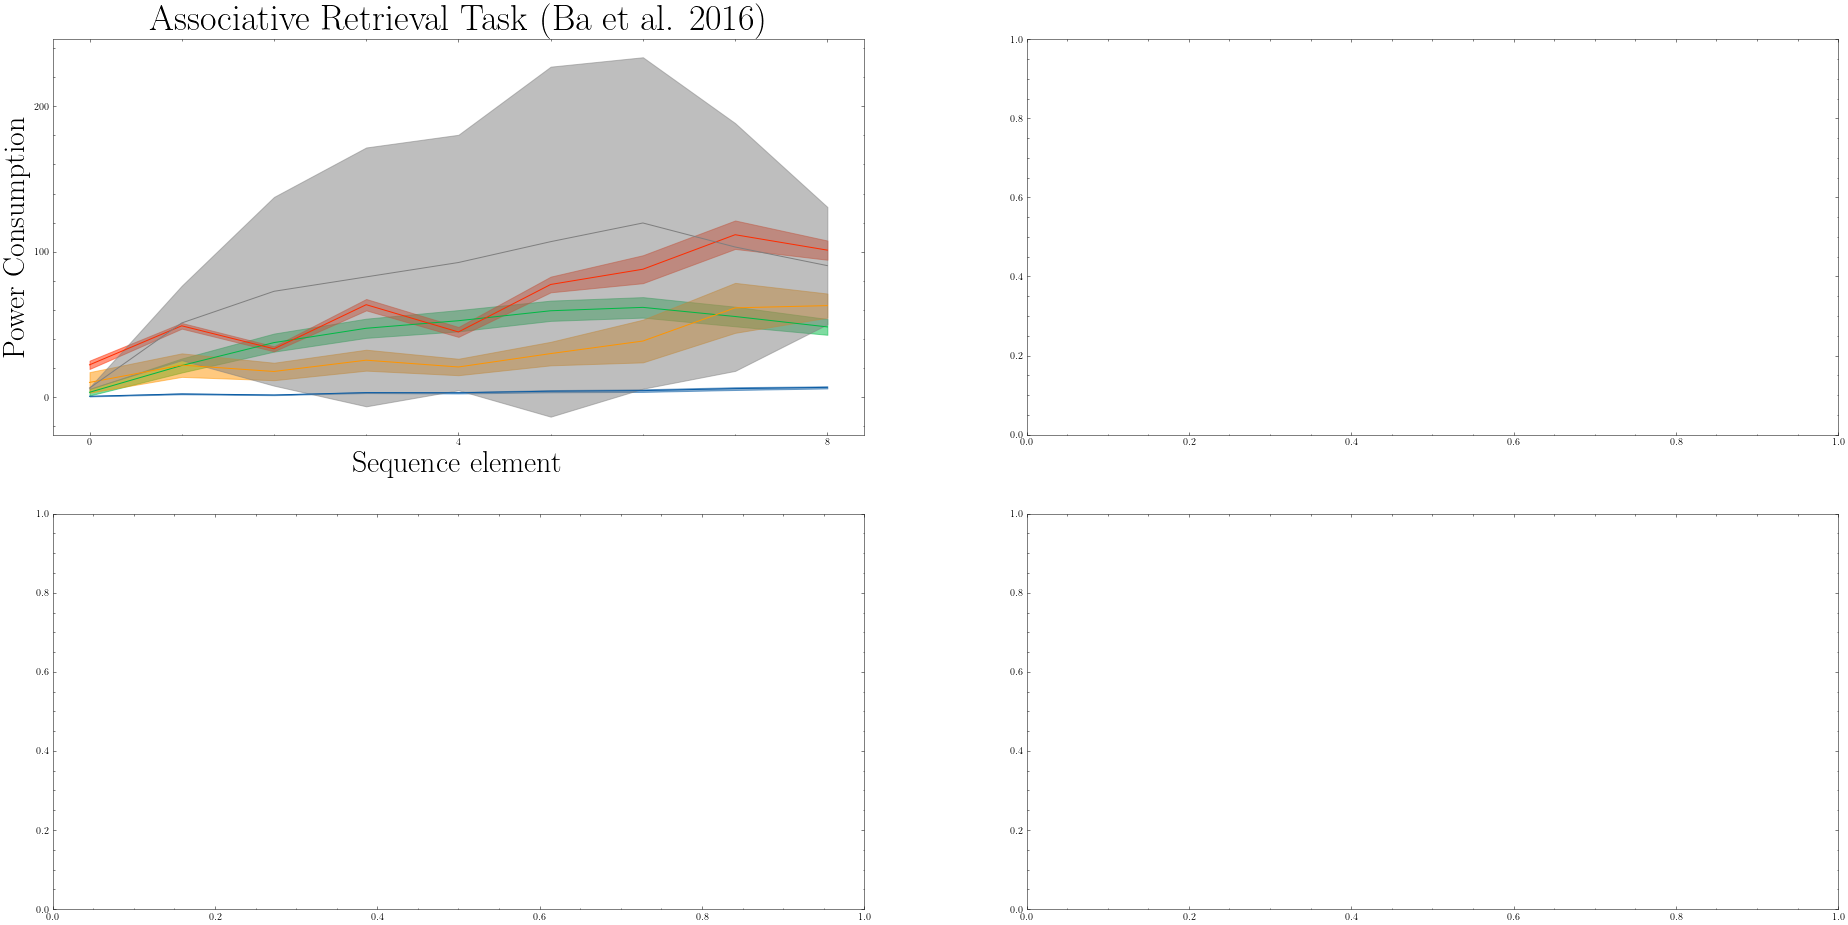

In [9]:
# ================================================================== #
# == Vectorise results across models and seeds for plotting ======== #
# ================================================================== #

if default_aspect_ratio is False:
    plt.figure(figsize=(16, 8), dpi=80)
plt.sca(axs_eff[0,0]) # set current subfigure

rewards = art_eval_energies
experiment_suffix = experiments
labels = []

# in this case these are seq_len (=9 elements)
last_n_iters = 9  
max_iters = 9
plot_to_real_ratio = 1 # ratio of plotting elements to real steps
my_xticks = np.arange(plot_to_real_ratio*(max_iters-last_n_iters),plot_to_real_ratio*max_iters+1,10000)
x_my_ticks = np.arange(max_iters-last_n_iters,max_iters+1, 1000)
x = np.arange(max_iters-last_n_iters,max_iters)

mean_rewards, std_rewards = [], []
max_rewards, min_rewards = [], []

for exp_name, this_exp_cfg in experiment_suffix.items():
    rewards_seeds = []
    # concatenate all seeds results
    for seed in seeds:
        try:
            # ART doesnt have iters
            this_seed_rewards = np.expand_dims(np.array(rewards[exp_name][seed]), 0)
        except:
            print('failed loading of reward for this exp name and seed')
            ipdb.set_trace()
        rewards_seeds.append(this_seed_rewards)
    
    try:
        rewards_seeds = np.concatenate(rewards_seeds, axis=0)
    except:
        print('failed concatenation of rewards for all seeds in this exp_name')
        ipdb.set_trace()
    
    # rewards_seeds (seeds, seqs, seq_len)
    rewards_seeds = np.mean(rewards_seeds, axis=(1))
    
    # mean and std over seeds
    if plot_line == 'mean':
        this_mean_rewards = np.mean(rewards_seeds, axis=0)
    elif plot_line == 'median':
        this_mean_rewards = np.median(rewards_seeds, axis=0)
    
     
    # average or sum iters and episode steps, after mean,std of seeds
    this_std_rewards = np.std(rewards_seeds, axis=0)
    this_max_rewards, this_min_rewards = np.max(rewards_seeds, axis=0), np.min(rewards_seeds, axis=0)
    
    # store results
    mean_rewards.append(this_mean_rewards)
    std_rewards.append(this_std_rewards)
    max_rewards.append(this_max_rewards)
    min_rewards.append(this_min_rewards)
    # store label to ensure correct order of results
    labels.append(model2label[this_exp_cfg['short']])
    
mean_rewards, std_rewads = np.array(mean_rewards), np.array(std_rewards)
max_rewards, min_rewads = np.array(max_rewards), np.array(min_rewards)

###########################################################
## Plot results ###########################################
###########################################################
accuracies, accuracies_std = mean_rewards, np.array(std_rewards)
min_accuracies, max_accuracies = np.array(min_rewards), np.array(max_rewards) # min_rewards, max_rewards
ids_meta_model = {}
rescale = lambda y, min_scale: (y - np.min(y)*min_scale) / (np.max(y) - np.min(y)*min_scale)

meta_models = [
    "STPN", 
    "RNN",
    "LSTM",
    'Miconi', #'Modplast', #'Modplast (Miconi et al.)',# "MODPLAST",
    'Fast Weights', # 'Fast Weights (Ba et al.)',#"FW",
]
seq_cmaps = [
    plt.cm.Blues,
    plt.cm.Reds,
    plt.cm.Oranges,
    plt.cm.Greens,
    plt.cm.Greys
]
for i_meta_model, meta_model in enumerate(meta_models):
    ids_meta_model[meta_model] = np.array([meta_model in xlabel for xlabel in labels])
    if ids_meta_model[meta_model].sum() == 0:
        continue
    else:
#         import pdb
#         pdb.set_trace()
        this_colors = seq_cmaps[i_meta_model](rescale(accuracies[ids_meta_model[meta_model]][:,-1], min_scale=0.95))
        for i_sub_model in range(this_colors.shape[0]):
            if meta_model not in global_colors:
                global_colors[meta_model] = this_colors[i_sub_model]
            print(meta_model, global_colors[meta_model])
            plt.plot(
                x,
                accuracies[ids_meta_model[meta_model]][i_sub_model],
                color=global_colors[meta_model],
                label=np.array(labels)[ids_meta_model[meta_model]][i_sub_model]
            )
            if plot_shaded is not False:
                if plot_shaded == 'std': # [ False, 'std', 'min_max']
                    bot_err = accuracies[ids_meta_model[meta_model]][i_sub_model] - accuracies_std[ids_meta_model[meta_model]][i_sub_model]
                    top_err = accuracies[ids_meta_model[meta_model]][i_sub_model] + accuracies_std[ids_meta_model[meta_model]][i_sub_model]
                elif plot_shaded == 'min_max':
                    bot_err = min_accuracies[ids_meta_model[meta_model]][i_sub_model]
                    top_err = max_accuracies[ids_meta_model[meta_model]][i_sub_model]
                else:
                    raise NotImplementedError
                plt.fill_between(
                    x,
                    bot_err,
                    top_err,
                    alpha=alphas[this_experiment],
                    color=global_colors[meta_model],
                )
                
##########################################################
##########################################################

if eff_legend_subplots == 0 or eff_legend_subplots == 'all':
    plt.legend()

if plot_subplots is True:
    plt.title(titles[this_experiment])
    plt.ylabel(eff_ylabel, fontsize=fontsize_labels)#[this_experiment])
    plt.xlabel(eff_xlabel[this_experiment], fontsize=fontsize_labels)
    
    if equally_spaced_ticks:
        # for y it works here
        plt.locator_params(nbins=n_ticks)
        # enforce for x
        new_x_locs = np.linspace(x[0], x[-1], num = n_ticks, endpoint=True, dtype=int)
        plt.xticks(ticks=new_x_locs, labels=new_x_locs)
    else:
        # doesn't enforce n_ticks, just tries to pick n_ticks from within the ones given, which usually have round numbers
        plt.locator_params(nbins=n_ticks)
else:
    plt.title(f'Maze exploration')
    plt.ylabel('Energy per forward pass', fontsize=fontsize_labels)
    plt.xlabel('Episode step', fontsize=fontsize_labels)
    plt.show()

## Validation accuracy vs training iteration

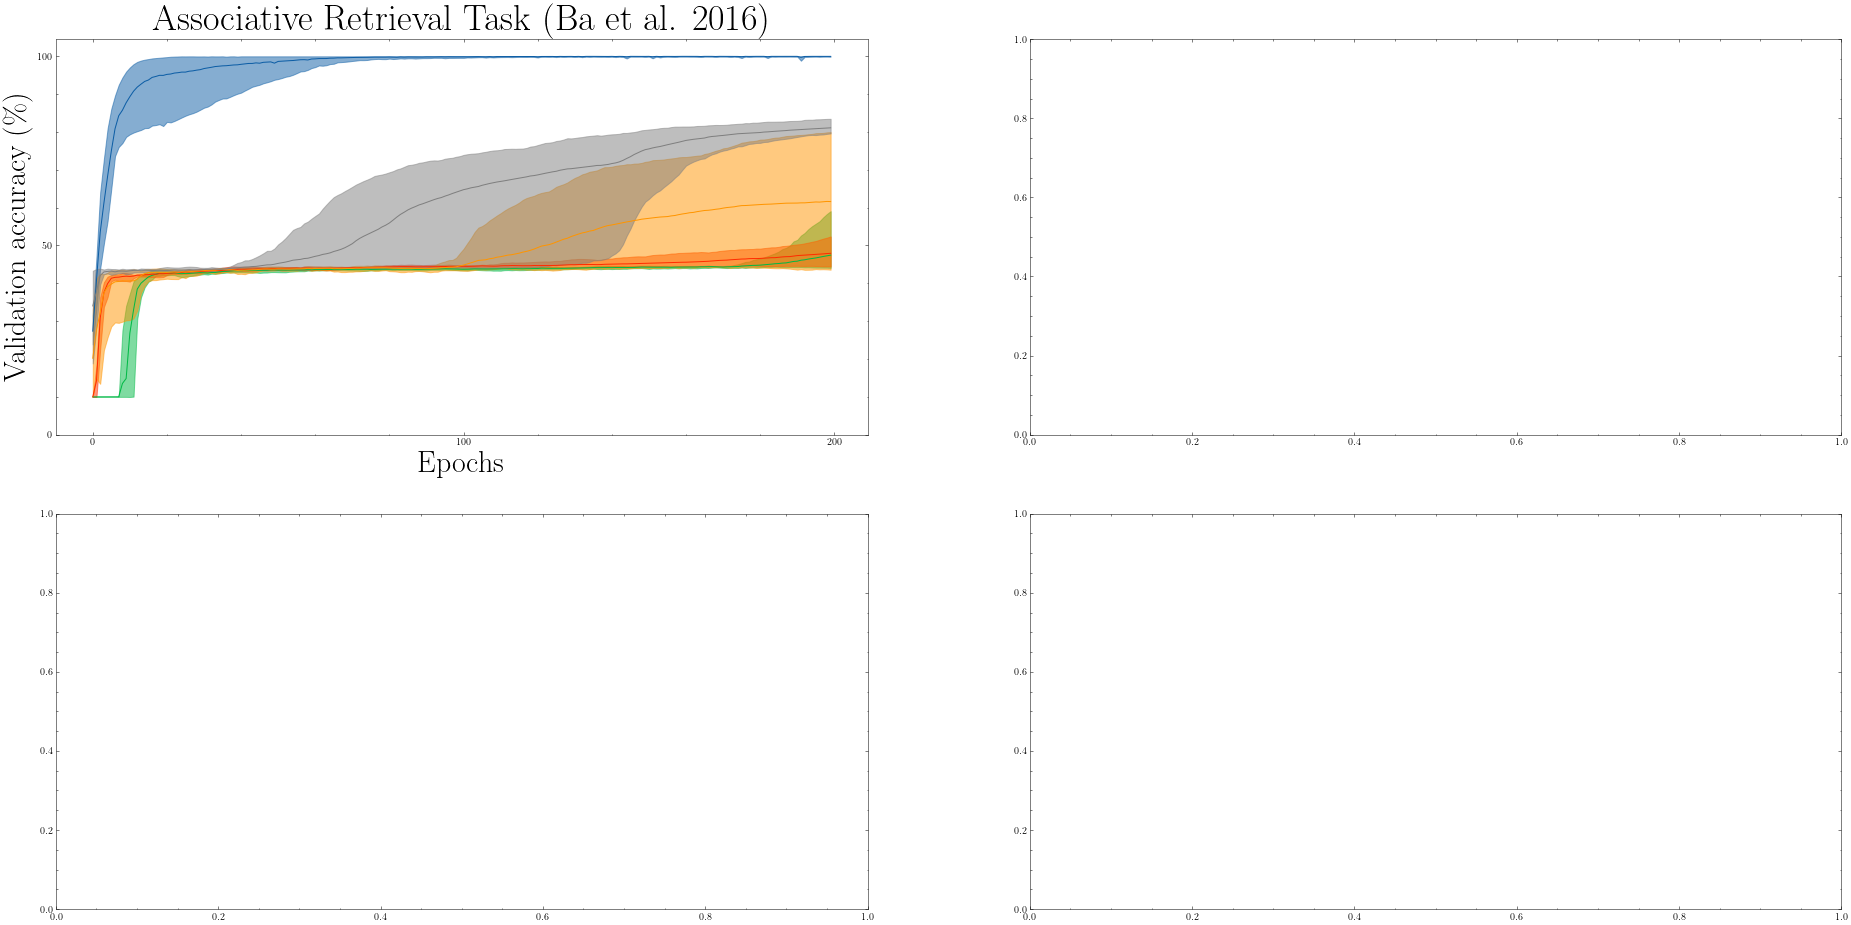

In [10]:
# ================================================================== #
# == Vectorise results across models and seeds for plotting ======== #
# ================================================================== #

if default_aspect_ratio is False:
    plt.figure(figsize=(16, 8), dpi=80)

# 200 training iterations
labels = []
last_n_iters = 200
max_iters = 200 #4000 #5000
my_xticks = np.arange((max_iters-last_n_iters)*1,max_iters*1+1,50)
x_my_ticks = my_xticks
x = np.arange(max_iters-last_n_iters,max_iters)
mean_rewards, std_rewards = [], []
max_rewards, min_rewards = [], []

rewards = val_accuracies
if plot_subplots is True:
    plt.sca(axs_prof[0,0])
    plot = plt
else:
    plot = plt


for exp_name, exp_cfg in experiments.items():
    rewards_seeds = []
    for seed in seeds:
        # expand dim for seeds
        try:
            this_seed_rewards = np.expand_dims(np.array(rewards[exp_name][seed][max_iters-last_n_iters:max_iters]), 0)
        except:
            ipdb.set_trace()
        rewards_seeds.append(this_seed_rewards)
    # concatenate seeds
    try:
        rewards_seeds = np.concatenate(rewards_seeds, axis=0)
    except:
        ipdb.set_trace()
    
    # mean and std over seeds
    this_mean_rewards = np.mean(rewards_seeds, axis=0)
    this_std_rewards = np.std(rewards_seeds, axis=0)
    this_max_rewards, this_min_rewards = np.max(rewards_seeds, axis=0), np.min(rewards_seeds, axis=0) 
    # append to all models' results
    mean_rewards.append(this_mean_rewards)
    std_rewards.append(this_std_rewards)
    max_rewards.append(this_max_rewards)
    min_rewards.append(this_min_rewards)
    labels.append(model2label[exp_cfg['short']])
    
mean_rewards, std_rewads = np.array(mean_rewards), np.array(std_rewards)
max_rewards, min_rewads = np.array(max_rewards), np.array(min_rewards)



# ================================================================== #
# == Plot results ================================================== #
# ================================================================== #
accuracies, accuracies_std = mean_rewards, np.array(std_rewards)
min_accuracies, max_accuracies = np.array(min_rewards), np.array(max_rewards) # min_rewards, max_rewards
ids_meta_model = {}
rescale = lambda y, min_scale: (y - np.min(y)*min_scale) / (np.max(y) - np.min(y)*min_scale)
meta_models = [
    "STPN", 
    "RNN",
    "LSTM",
    'Miconi',#'Modplast', #'Modplast (Miconi et al.)',# "MODPLAST",
    'Fast Weights', # 'Fast Weights (Ba et al.)',#"FW",
]
seq_cmaps = [
    plt.cm.Blues,
    plt.cm.Reds,
    plt.cm.Oranges,
    plt.cm.Greens,
    plt.cm.Greys
]
for i_meta_model, meta_model in enumerate(meta_models):
    ids_meta_model[meta_model] = np.array([meta_model in xlabel for xlabel in labels])
    if ids_meta_model[meta_model].sum() == 0:
        continue
    else:
        this_colors = seq_cmaps[i_meta_model](rescale(accuracies[ids_meta_model[meta_model]][:,-1], min_scale=0.75))
        for i_sub_model in range(this_colors.shape[0]):
            if meta_model not in global_colors:
                ipdb.set_trace()
                global_colors[meta_model] = this_colors[i_sub_model]
            plot.plot(
                x,
                accuracies[ids_meta_model[meta_model]][i_sub_model],
                color=global_colors[meta_model], #this_colors[i_sub_model],
                label= np.array(labels)[ids_meta_model[meta_model]][i_sub_model]
            )
            plot.fill_between(
                x,
                min_accuracies[ids_meta_model[meta_model]][i_sub_model],
                max_accuracies[ids_meta_model[meta_model]][i_sub_model],
                alpha=alphas[this_experiment],#0.2,
                color=global_colors[meta_model], #this_colors[i_sub_model]
            )
    
##########################################################
##########################################################

if plot_subplots is True:
    plt.title(titles[this_experiment])
    plt.ylabel(prof_ylabel[this_experiment], fontsize=fontsize_labels)
    plt.xlabel(prof_xlabel[this_experiment], fontsize=fontsize_labels)
    plt.xticks(x_my_ticks, my_xticks)
    plt.locator_params(nbins=n_ticks)
    plt.yticks(np.linspace(0,1,n_ticks), np.linspace(0,100,n_ticks, dtype=int))
    if prof_legend_subplots == 0 or prof_legend_subplots == 'all':
        plt.legend()
else:
    plt.title(f'Maze exploration reward during last {last_n_iters} episodes of training')
    plt.title(f'Associative Retrieval Task validation accuracy during training')
    plt.ylabel('Accuracy')
    plt.xlabel('Epochs')
    plt.legend()
    plt.xticks(x_my_ticks, my_xticks)
    
    plt.show()

## Val acc vs energy during training 

In [11]:
default_aspect_ratio = True
# reward vs energy
energies = val_energies
rewards = val_accuracies
experiment_suffix = experiments

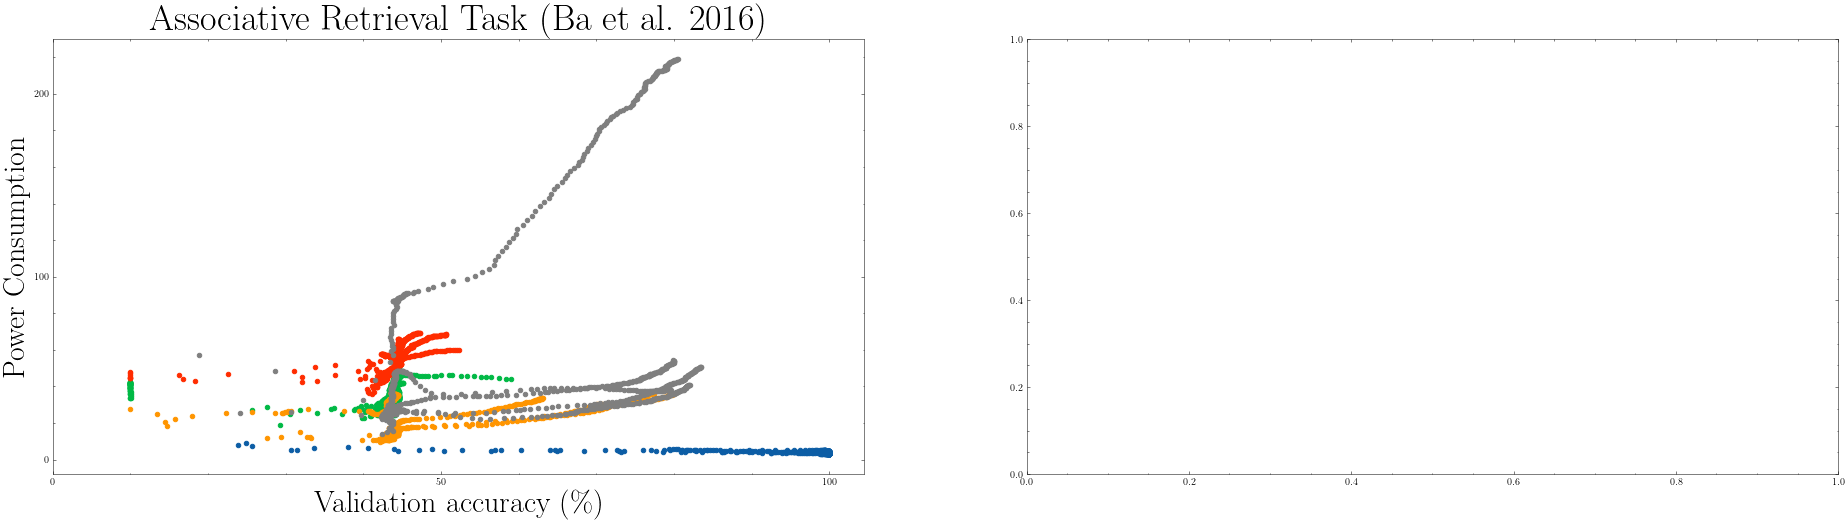

In [12]:
# =========================================================== #
# Vectorise results across models and seeds for plotting ==== #
# This needs training data to be loaded again ! ============= #
# =========================================================== #
if default_aspect_ratio is False:
    plt.figure(figsize=(16, 8), dpi=80)

plt.sca(axs_eff_vs_prof[0])
    
labels = []
last_n_iters = 200
max_iters = 200

energy_to_rew_measure = 1 # in case we dont measure reward and energy equally as often wrt episodes and iterations
need_to_interp  = False

my_xticks = np.arange(energy_to_rew_measure*(max_iters-last_n_iters),energy_to_rew_measure*max_iters+1,10000)
x_my_ticks = np.arange(max_iters-last_n_iters,max_iters+1, 1000)
x = np.arange(max_iters-last_n_iters,max_iters)
xs, x_missing = np.arange((max_iters-last_n_iters)*energy_to_rew_measure,max_iters*energy_to_rew_measure), np.arange((max_iters-last_n_iters)*energy_to_rew_measure,max_iters*energy_to_rew_measure, 10)
mean_rewards, std_rewards, mean_energies = [], [], []
max_rewards, min_rewards = [], []

rewards_models, energies_models = [], []
for exp_name, this_exp_cfg in experiment_suffix.items():
    rewards_seeds, energies_seeds = [], []
    for seed in seeds:
        try:
            this_seed_rewards = np.array(rewards[exp_name][seed][max_iters-last_n_iters:max_iters])
            # 10x episodes, episode_steps; avearge episode_steps ; 
            the_energy_here = np.mean(energies[exp_name][seed][energy_to_rew_measure*(max_iters-last_n_iters):energy_to_rew_measure*max_iters], axis=1) 
            this_seed_energies = np.array(the_energy_here)
            # average the sequence
            this_seed_energies = np.mean(this_seed_energies, axis = 1) # epochs, seq_len
        except:
            print("error in loading energy or rewards")
            ipdb.set_trace()
        
        rewards_seeds.append(this_seed_rewards)
        energies_seeds.append(this_seed_energies)
    rewards_models.append(rewards_seeds)
    energies_models.append(energies_seeds)
    labels.append(model2label[this_exp_cfg['short']])

    
# ================================================================== #
# == Plot results ================================================== #
# ================================================================== #
rewards_models, energies_models = np.array(rewards_models), np.array(energies_models)
accuracies = rewards_models

ids_meta_model = {}
rescale = lambda y, min_scale: (y - np.min(y)*min_scale) / (np.max(y) - np.min(y)*min_scale)
meta_models = [
    "STPN",
    "RNN",
    "LSTM",
    'Miconi',#     "Modplast", #"MODPLAST",
    'Fast Weights' # Ba
]
seq_cmaps = [
    plt.cm.Blues, 
    plt.cm.Reds,
    plt.cm.Oranges,
    plt.cm.Greens,
    plt.cm.Greys
]
for i_meta_model, meta_model in enumerate(meta_models):

    ids_meta_model[meta_model] = np.array([meta_model in xlabel for xlabel in labels])# np.argwhere(meta_model in xlabels)

    if ids_meta_model[meta_model].sum() == 0:
        continue
    else:
        this_colors = seq_cmaps[i_meta_model](rescale(
            accuracies[ids_meta_model[meta_model]][0,:,-1], # 0 as it keeps the model dim for some reason, : for all seeds, -1 for last value in series
            min_scale=0.95)
        )
        for i_sub_model in range(this_colors.shape[0]):
            # only one label for each seed
            if i_sub_model == 0:
                label = np.array(labels)[ids_meta_model[meta_model]][0]
            else:
                label = None
            if need_to_interp is True:
                x_plot = np.interp(xs, x_missing,accuracies[ids_meta_model[meta_model]][0,i_sub_model]),
            else:
                x_plot = accuracies[ids_meta_model[meta_model]][0,i_sub_model] # np.arange(len(energies_models[ids_meta_model[meta_model]][0,i_sub_model]))
            plt.scatter(
                x_plot,
                energies_models[ids_meta_model[meta_model]][0,i_sub_model],
                color=global_colors[meta_model], 
                label= label,
                s=20, # TODO: make this global
            )

##########################################################
##########################################################
plt.title(titles[this_experiment])
plt.ylabel(eff_vs_prof_ylabel, fontsize=fontsize_labels)
plt.xlabel(eff_vs_prof_xlabel[this_experiment], fontsize=fontsize_labels) #Reward')
plt.locator_params(nbins=n_ticks)
plt.xticks(np.linspace(0,1,n_ticks), np.linspace(0,100,n_ticks, dtype=int)) 
# Rescale legend dots
if eff_vs_prof_legend_subplots == 0 or eff_vs_prof_legend_subplots == 'all':
    fontsize, fontsize_to_dot = general_font, 5 #2 # TODO: make this global
    lgnd = plt.legend(loc="upper left", scatterpoints=1, fontsize=fontsize)
    for i in range(len(meta_models)):
        lgnd.legendHandles[i]._sizes = [fontsize_to_dot*fontsize]
        lgnd.legendHandles[i]._sizes = [fontsize_to_dot*fontsize]

# Maze

In [13]:
this_experiment = 'Maze'

## Maze reward vs time

In [14]:
plot_shaded = 'std' # [ False, 'std', 'min_max']
plot_line = 'mean' # [ 'mean', 'median']

In [15]:
path_results = os.path.join(base_path, 'Maze/')

secondary_base_path = {
    'reward': 'logs',
    'energy': 'efficiency',
    'model': 'logs',
}
filename_prefix = {
    'reward': 'loss',
    'energy': 'energy',
    'model': 'torchmodel'
}
train_experiment_suffix = {
    "RNN": {"net_type": "miconi", "type": "rnn", "config": "RNN_Maze_h100", 'nbiter': 50000, 'hs': 100},
    "LSTM": {"net_type": "miconi", "type": "lstm", "config": "LSTM_Maze_h47", 'nbiter': 50000, 'hs': 47, 'gates': 4},
    'Modplast': {"net_type": "miconi", "type": "modplast", "config": "Modplast_Maze_h73", 'nbiter': 50000, 'hs': 73},
    "STPN": {"net_type": "stpn", "type": "stpn", "config": "STPN_Maze_h55", 'nbiter': 50000, 'hs': 55},
}
experiment_suffix = copy.deepcopy(train_experiment_suffix)
file_format = {
    'reward': '.txt',
    'energy': '.npy',
    'model': '.dat'
}

labels = []
seeds = global_seeds[this_experiment]
n_moving_average = 10 # smooth, as we only store every 10 so very spiky

rewards, energies = {}, {}
for exp_name, exp_config in experiment_suffix.items():
    # init exp for diff seeds
    labels.append(exp_name)
    rewards[exp_name], energies[exp_name] = {}, {}
    for seed in seeds:
        exp_config['rngseed'] = seed
        path_to_reward_file = get_path_results('reward',path_results, secondary_base_path, filename_prefix, 
                                               file_format, exp_config)
        with open(path_to_reward_file) as f:
            loss = f.read()
            rewards[exp_name][seed] = np.array([float(i_loss) for i_loss in loss.split()])
            if n_moving_average is not False:
                rewards[exp_name][seed] = moving_average(rewards[exp_name][seed], n_moving_average)
        path_to_energy_file = get_path_results('energy', path_results, secondary_base_path, filename_prefix,
                                               file_format, exp_config)
        energies[exp_name][seed] = np.load(str(path_to_energy_file))
maze_train_energies = energies
maze_train_rewards = rewards

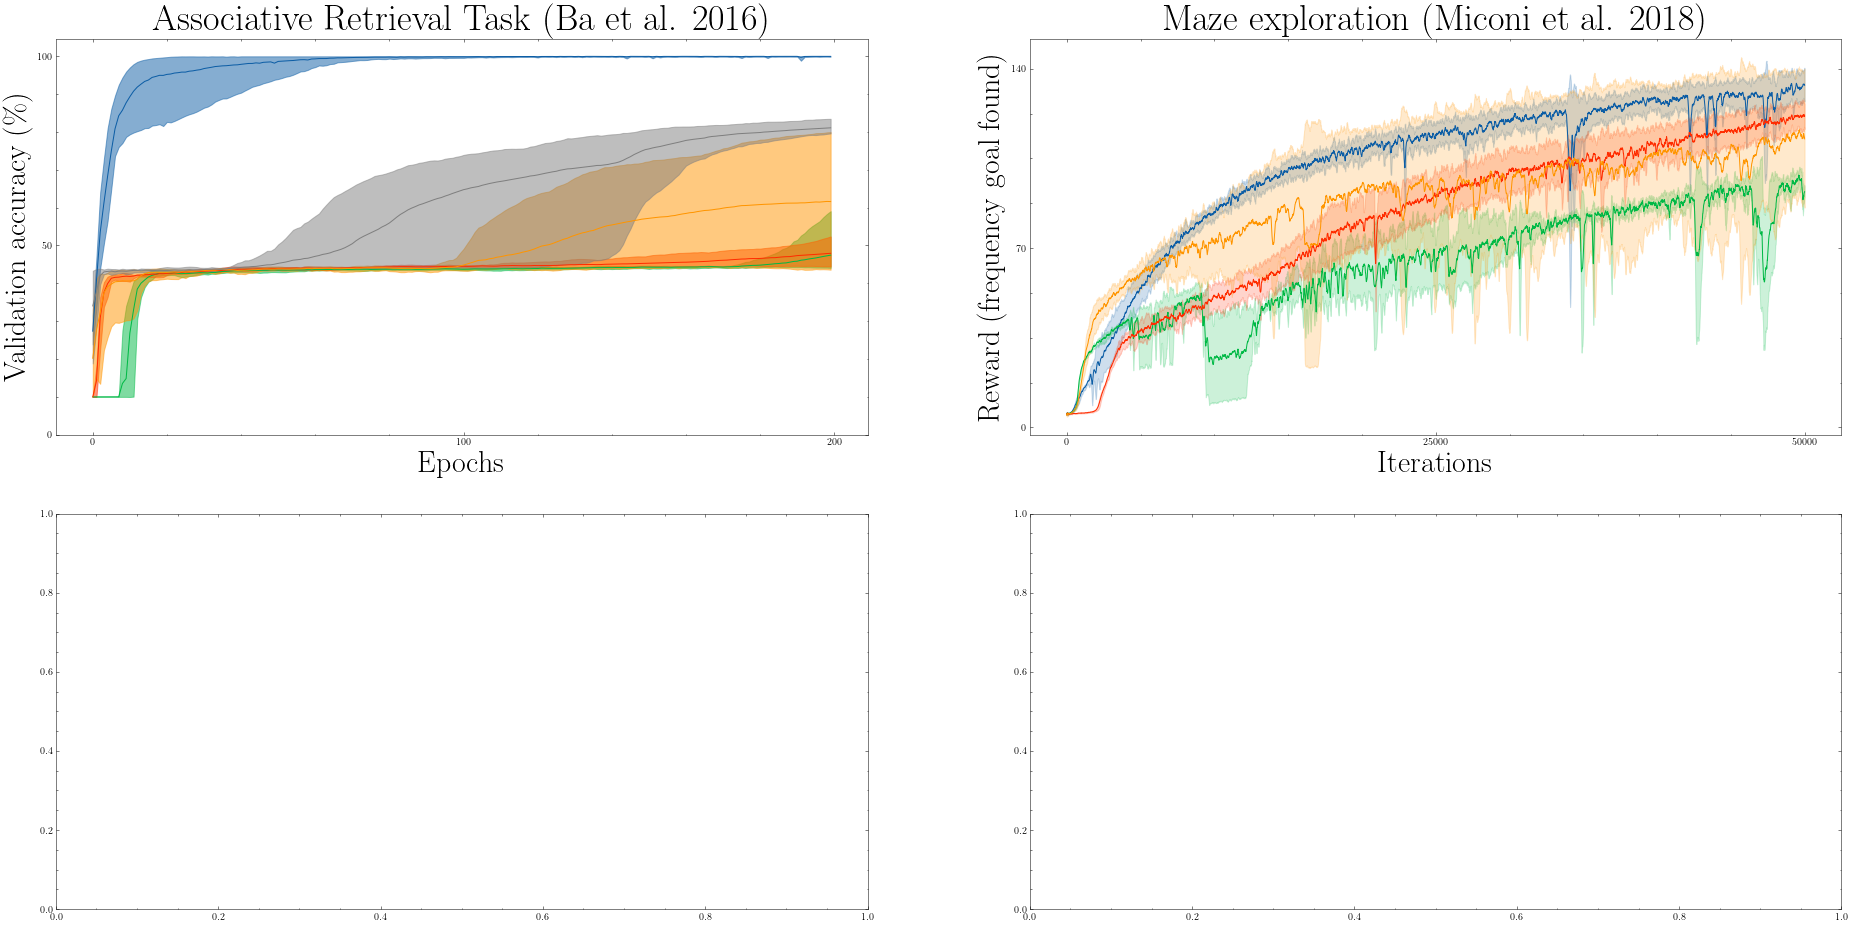

In [16]:
if default_aspect_ratio is False:
    plt.figure(figsize=(16, 8), dpi=80)
    
plt.sca(axs_prof[0, 1])


labels = []
last_n_iters = 5000 
max_iters = 5000
ratio_tick_to_label = 10
my_xticks = np.arange(10*(max_iters-last_n_iters),10*max_iters+1,10000)
x_my_ticks = np.arange(max_iters-last_n_iters,max_iters+1, 1000)
x = np.arange(max_iters-last_n_iters,max_iters)
mean_rewards, std_rewards = [], []
max_rewards, min_rewards = [], []

for exp_name, _ in experiment_suffix.items():
    rewards_seeds = []
    for seed in seeds:
        try:
            this_seed_rewards = np.expand_dims(np.array(rewards[exp_name][seed][max_iters-last_n_iters:max_iters]), 0)
        except:
            print('failed loading of reward for this exp name and seed')
            ipdb.set_trace()
        rewards_seeds.append(this_seed_rewards)    
    try:
        rewards_seeds = np.concatenate(rewards_seeds, axis=0)
    except:
        print('failed concatenation of rewards for all seeds in this exp_name')
        ipdb.set_trace()
    # mean and std over seeds
    if plot_line == 'mean': # [ 'mean', 'median']
        this_mean_rewards = np.mean(rewards_seeds, axis=0)
    elif plot_line == 'median': # [ 'mean', 'median']
        this_mean_rewards = np.median(rewards_seeds, axis=0)
    this_std_rewards = np.std(rewards_seeds, axis=0)
    this_max_rewards, this_min_rewards = np.max(rewards_seeds, axis=0), np.min(rewards_seeds, axis=0) 
    # store results
    mean_rewards.append(this_mean_rewards)
    std_rewards.append(this_std_rewards)
    max_rewards.append(this_max_rewards)
    min_rewards.append(this_min_rewards)
    labels.append(model2label[exp_name])
# ensure cast to np.array
mean_rewards, std_rewads = np.array(mean_rewards), np.array(std_rewards)
max_rewards, min_rewads = np.array(max_rewards), np.array(min_rewards)

###########################################################
###########################################################
accuracies, accuracies_std = mean_rewards, np.array(std_rewards)
min_accuracies, max_accuracies = np.array(min_rewards), np.array(max_rewards)
ids_meta_model = {}
rescale = lambda y, min_scale: (y - np.min(y)*min_scale) / (np.max(y) - np.min(y)*min_scale)
meta_models = [
    "STPN",
    "RNN",
    "LSTM",
    'Miconi',#'Modplast', #"MODPLAST"
]
seq_cmaps = [plt.cm.Blues, plt.cm.Reds, plt.cm.Oranges, plt.cm.Greens]
for i_meta_model, meta_model in enumerate(meta_models):
    ids_meta_model[meta_model] = np.array([meta_model in xlabel for xlabel in labels])
    if ids_meta_model[meta_model].sum() == 0:
        continue
    else:
        this_colors = seq_cmaps[i_meta_model](rescale(accuracies[ids_meta_model[meta_model]][:,-1], min_scale=0.95))
        for i_sub_model in range(this_colors.shape[0]):
            if meta_model not in global_colors:
                global_colors[meta_model] = this_colors[i_sub_model]
            plt.plot(
                x,
                accuracies[ids_meta_model[meta_model]][i_sub_model],
                color=global_colors[meta_model],
                label= np.array(labels)[ids_meta_model[meta_model]][i_sub_model]
            )
            if plot_shaded is not False:
                if plot_shaded == 'std': # [ False, 'std', 'min_max']
                    bot_err = accuracies[ids_meta_model[meta_model]][i_sub_model] - accuracies_std[ids_meta_model[meta_model]][i_sub_model]
                    top_err = accuracies[ids_meta_model[meta_model]][i_sub_model] + accuracies_std[ids_meta_model[meta_model]][i_sub_model]
                elif plot_shaded == 'min_max':
                    bot_err = min_accuracies[ids_meta_model[meta_model]][i_sub_model]
                    top_err = max_accuracies[ids_meta_model[meta_model]][i_sub_model]
                else:
                    raise NotImplementedError
                plt.fill_between(
                    x,
                    bot_err,
                    top_err,
                    alpha=alphas[this_experiment],
                    color=global_colors[meta_model],
                )
                
##########################################################
##########################################################
plt.title(titles[this_experiment])
plt.ylabel(prof_ylabel[this_experiment], fontsize=fontsize_labels)
plt.xlabel(prof_xlabel[this_experiment], fontsize=fontsize_labels)
if prof_legend_subplots == 1 or prof_legend_subplots == 'all':
    plt.legend()

if equally_spaced_ticks:
    x_my_ticks = np.linspace(x_my_ticks[0], x_my_ticks[-1], n_ticks, dtype=int)
    my_xticks = ratio_tick_to_label * x_my_ticks
    
    yticks = np.linspace(0, 140, n_ticks, dtype=int)
    ylabels = yticks
    plt.xticks(x_my_ticks, my_xticks)
    plt.yticks(yticks, ylabels)
else:
    plt.xticks(x_my_ticks, my_xticks)
    plt.locator_params(nbins=n_ticks)


plt.show()

## Test energy and reward results for tables

In [17]:
# ====================================== #
# Load data ============================ #
# ====================================== #

# energy table during eval!
eval_experiment_suffix = {
    "RNN": {'eval': True, 'nbiter': 100, "net_type": "miconi", "type": "rnn", "config": "RNN_Maze_h100", 'hs': 100},
    "LSTM": {'eval': True, 'nbiter': 100,"net_type": "miconi", "type": "lstm", "config": "LSTM_Maze_h47", 'hs': 47, 'gates': 4},
    "Modplast": {'eval': True, 'nbiter': 100, "net_type": "miconi", "type": "modplast", "config": "Modplast_Maze_h73", 'hs': 73},
    "STPN": {'eval': True, 'nbiter': 100, "net_type": "stpn", "type": "stpn", "config": "STPN_Maze_h55", 'hs': 55},
}
experiment_suffix = copy.deepcopy(eval_experiment_suffix)

labels = []
seeds = global_seeds[this_experiment]
n_moving_average = 10
rewards, energies = {}, {}
for exp_name, exp_config in experiment_suffix.items():
    # init exp for diff seeds
    labels.append(exp_name)
    rewards[exp_name], energies[exp_name] = {}, {}
    for seed in seeds:
        exp_config['rngseed'] = seed
        path_to_reward_file = get_path_results('reward', path_results,secondary_base_path, filename_prefix,
                                               file_format, exp_config)
        with open(path_to_reward_file) as f:
            loss = f.read()
            rewards[exp_name][seed] = np.array([float(i_loss) for i_loss in loss.split()])
            if n_moving_average is not False:
                rewards[exp_name][seed] = moving_average(rewards[exp_name][seed], n_moving_average)
        path_to_energy_file = get_path_results('energy', path_results, secondary_base_path, filename_prefix,
                                               file_format, exp_config)
        energies[exp_name][seed] = np.load(str(path_to_energy_file))
        
maze_eval_energies = energies
maze_eval_rewards = rewards
###################################
###################################
x = np.arange(len(energies))
labels = []
# 100 episode steps
last_n_iters = 100
max_iters = 100
mean_energies, std_energies = [], []

mean_rewards, std_rewards = [], []
max_rewards, min_rewards = [], []
for exp_name, exp_cfg in experiment_suffix.items():
    rewards_seeds, energies_seeds = [], []
    for seed in seeds:
        # expand dim for seeds
        this_seed_energies = np.expand_dims(np.array(energies[exp_name][seed][max_iters-last_n_iters:max_iters]), 0)
        this_seed_energies = this_seed_energies * exp_cfg.get('hs', 100)  * exp_cfg.get('gates', 1) 
        energies_seeds.append(this_seed_energies)
        this_seed_rewards = np.expand_dims(np.array(rewards[exp_name][seed][max_iters-last_n_iters:max_iters]), 0)
        rewards_seeds.append(this_seed_rewards)
    energies_seeds = np.concatenate(energies_seeds, axis=0)
    rewards_seeds = np.concatenate(rewards_seeds, axis=0)
    # average or sum iters and episode steps, before mean,std of seeds
    energies_seeds = np.mean(energies_seeds, axis=(1,2)) # seeds, iters, ep step
    rewards_seeds = np.mean(rewards_seeds, axis=(0)) # mean across seeds, iters # not mean across steps ? 
    
    # mean and std over seeds
    this_mean_energies = np.mean(energies_seeds, axis=0)
    this_std_energies = np.std(energies_seeds, axis=0)
    this_mean_rewards = np.mean(rewards_seeds, axis=(0))
    this_std_rewards = np.std(rewards_seeds, axis=0)
    this_max_rewards, this_min_rewards = np.max(rewards_seeds, axis=0), np.min(rewards_seeds, axis=0) 

    mean_energies.append(this_mean_energies)
    std_energies.append(this_std_energies)
    mean_rewards.append(this_mean_rewards)
    std_rewards.append(this_std_rewards)
    max_rewards.append(this_max_rewards)
    min_rewards.append(this_min_rewards)
    labels.append(model2label[exp_name])    
mean_energies, std_energies = np.array(mean_energies), np.array(std_energies)
mean_rewards, std_rewads = np.array(mean_rewards), np.array(std_rewards)
max_rewards, min_rewads = np.array(max_rewards), np.array(min_rewards)

In [18]:
# ====================================== #
# Make table =========================== #
# ====================================== #
xlabels = labels
mean_energies_std = std_energies
accuracies_mean, accuracies_std = mean_rewards, std_rewads

accuracies_for_df = []
energies_for_df = []
acc_decimals = 2
energy_decimals = 2
scaling_accuracy = 1 # accuracy over 1 or 100 %
for i_model, model_name in enumerate(xlabels):
    accuracies_for_df.append(f"{scaling_accuracy*accuracies_mean[i_model]:.{acc_decimals}f}  +- {scaling_accuracy*accuracies_std[i_model]:.{acc_decimals}f}")
    energies_for_df.append(f"{mean_energies[i_model]:.{energy_decimals}f}  +- {mean_energies_std[i_model]:.{energy_decimals}f}")
accuracies_for_df = np.array(accuracies_for_df, dtype=object)
energies_for_df = np.array(energies_for_df, dtype=object)

data = np.array(
    [
        np.array(xlabels).T, 
        accuracies_for_df.T, 
        energies_for_df.T
    ], 
    dtype=object
)

print(data)
print(data.shape)
df_maze_eval = pd.DataFrame(data.T, columns=[
    'Model',
    'Test accuracy',
    'Power consumption'
])

[['RNN' 'LSTM' 'Modulated Plasticity\n(Miconi et al., 2019)'
  'STPN (Ours)']
 ['97.94  +- 1.88' '119.85  +- 2.06' '112.19  +- 1.97' '132.68  +- 1.40']
 ['330.58  +- 24.29' '649.14  +- 15.34' '231.58  +- 23.95'
  '181.08  +- 2.88']]
(3, 4)


In [19]:
df_maze_eval # is it possible columns are switched ?

Model    Test accuracy  \
0                                          RNN   97.94  +- 1.88   
1                                         LSTM  119.85  +- 2.06   
2  Modulated Plasticity\n(Miconi et al., 2019)  112.19  +- 1.97   
3                                  STPN (Ours)  132.68  +- 1.40   

  Power consumption  
0  330.58  +- 24.29  
1  649.14  +- 15.34  
2  231.58  +- 23.95  
3   181.08  +- 2.88

## Reward vs energy (during training)

In [20]:
# reward vs energy
energies = maze_train_energies
rewards = maze_train_rewards
experiment_suffix = train_experiment_suffix

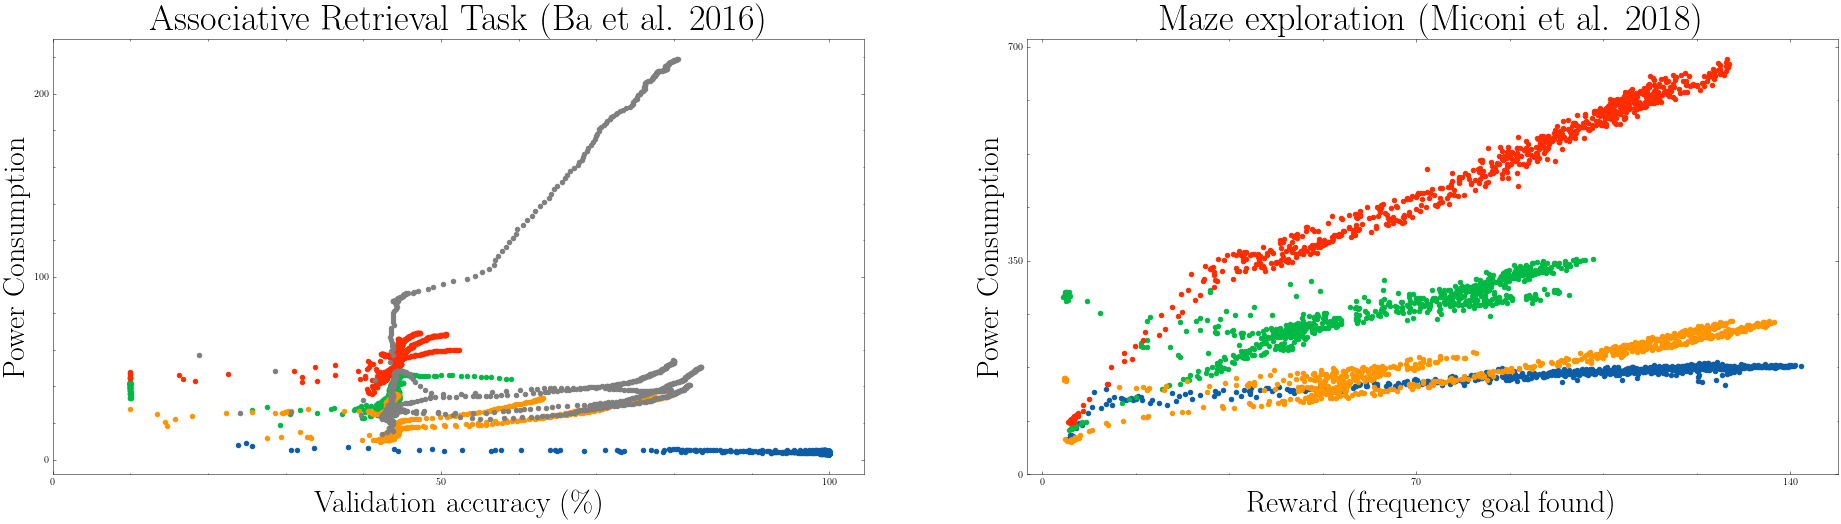

In [21]:
####################
# This needs training data to be loaded again !
#####################
if default_aspect_ratio is False:
    plt.figure(figsize=(16, 8), dpi=80)

plt.sca(axs_eff_vs_prof[1])

labels = []
last_n_iters = 5000
max_iters = 5000
my_xticks = np.arange(10*(max_iters-last_n_iters),10*max_iters+1,10000)
x_my_ticks = np.arange(max_iters-last_n_iters,max_iters+1, 1000)
x = np.arange(max_iters-last_n_iters,max_iters)
xs, x_missing = np.arange((max_iters-last_n_iters)*10,max_iters*10), np.arange((max_iters-last_n_iters)*10,max_iters*10, 10)
mean_rewards, std_rewards, mean_energies = [], [], []
max_rewards, min_rewards = [], []

rewards_models, energies_models = [], []
for exp_name, this_exp_cfg in experiment_suffix.items():
    rewards_seeds, energies_seeds = [], []
    for seed in seeds:
        # expand dim for seeds
        try:
            this_seed_rewards = np.array(rewards[exp_name][seed][max_iters-last_n_iters:max_iters])
            # 10x episodes, episode_steps; avearge episode_steps ; 
            the_energy_here = np.mean(energies[exp_name][seed][10*(max_iters-last_n_iters):10*max_iters], axis=1) 
            this_seed_energies = np.array(the_energy_here)*this_exp_cfg['hs'] * this_exp_cfg.get('gates', 1)
        except:
            print("error in loading energy or rewards")
            ipdb.set_trace()
        rewards_seeds.append(this_seed_rewards)
        energies_seeds.append(this_seed_energies)
    rewards_models.append(rewards_seeds)
    energies_models.append(energies_seeds)
    labels.append(model2label[exp_name])

###########################################################
###########################################################
rewards_models, energies_models = np.array(rewards_models), np.array(energies_models)
accuracies = rewards_models
pick_every_n_sample = 200 # downsample for faster PDF loading due to lighter image

ids_meta_model = {}
rescale = lambda y, min_scale: (y - np.min(y)*min_scale) / (np.max(y) - np.min(y)*min_scale)
meta_models = [
    "STPN",
    "RNN",
    "LSTM",
    'Miconi',#"Modplast", #"MODPLAST",
]
seq_cmaps = [
    plt.cm.Blues, 
    plt.cm.Reds,
    plt.cm.Oranges,
    plt.cm.Greens
]
for i_meta_model, meta_model in enumerate(meta_models):
    ids_meta_model[meta_model] = np.array([meta_model in xlabel for xlabel in labels])
    if ids_meta_model[meta_model].sum() == 0:
        continue
    else:
        # index 0 as it keeps the model dim for some reason, : for all seeds, -1 for last value in series
        this_colors = seq_cmaps[i_meta_model](rescale(accuracies[ids_meta_model[meta_model]][0,:,-1], min_scale=0.95))
        for i_sub_model in range(this_colors.shape[0]):
            # only one label for each seed
            if i_sub_model == 0:
                label = np.array(labels)[ids_meta_model[meta_model]][0]
            else:
                label = None
            plt.scatter(
                np.interp(xs, x_missing,accuracies[ids_meta_model[meta_model]][0,i_sub_model])[::pick_every_n_sample],
                energies_models[ids_meta_model[meta_model]][0,i_sub_model][::pick_every_n_sample],
                color=global_colors[meta_model],
                label= label,
                s=20,
            )
##########################################################
##########################################################
plt.title(titles[this_experiment])
plt.ylabel(eff_vs_prof_ylabel, fontsize=fontsize_labels)#[this_experiment])
plt.xlabel(eff_vs_prof_xlabel[this_experiment], fontsize=fontsize_labels)
plt.locator_params(nbins=n_ticks)

if equally_spaced_ticks:
    # harcoded limits
    xticks = np.linspace(0, 140, n_ticks, dtype=int)
    xlabels = xticks
    yticks = np.linspace(0, 700, n_ticks, dtype=int)
    ylabels = yticks
    plt.xticks(xticks, xlabels)
    plt.yticks(yticks, ylabels)
else:
    pass
# change legend dot size
if eff_vs_prof_legend_subplots == 1 or eff_vs_prof_legend_subplots == 'all':
    fontsize, fontsize_to_dot = general_font, 5
    lgnd = plt.legend(loc="upper left", scatterpoints=1, fontsize=fontsize)
    for i in range(len(meta_models)):
        lgnd.legendHandles[i]._sizes = [fontsize_to_dot*fontsize]
        lgnd.legendHandles[i]._sizes = [fontsize_to_dot*fontsize]

## Energy vs episode step (during evaluation)

In [22]:
plot_shaded = 'std' # [ False, 'std', 'min_max']
plot_line = 'mean' # [ 'mean', 'median']

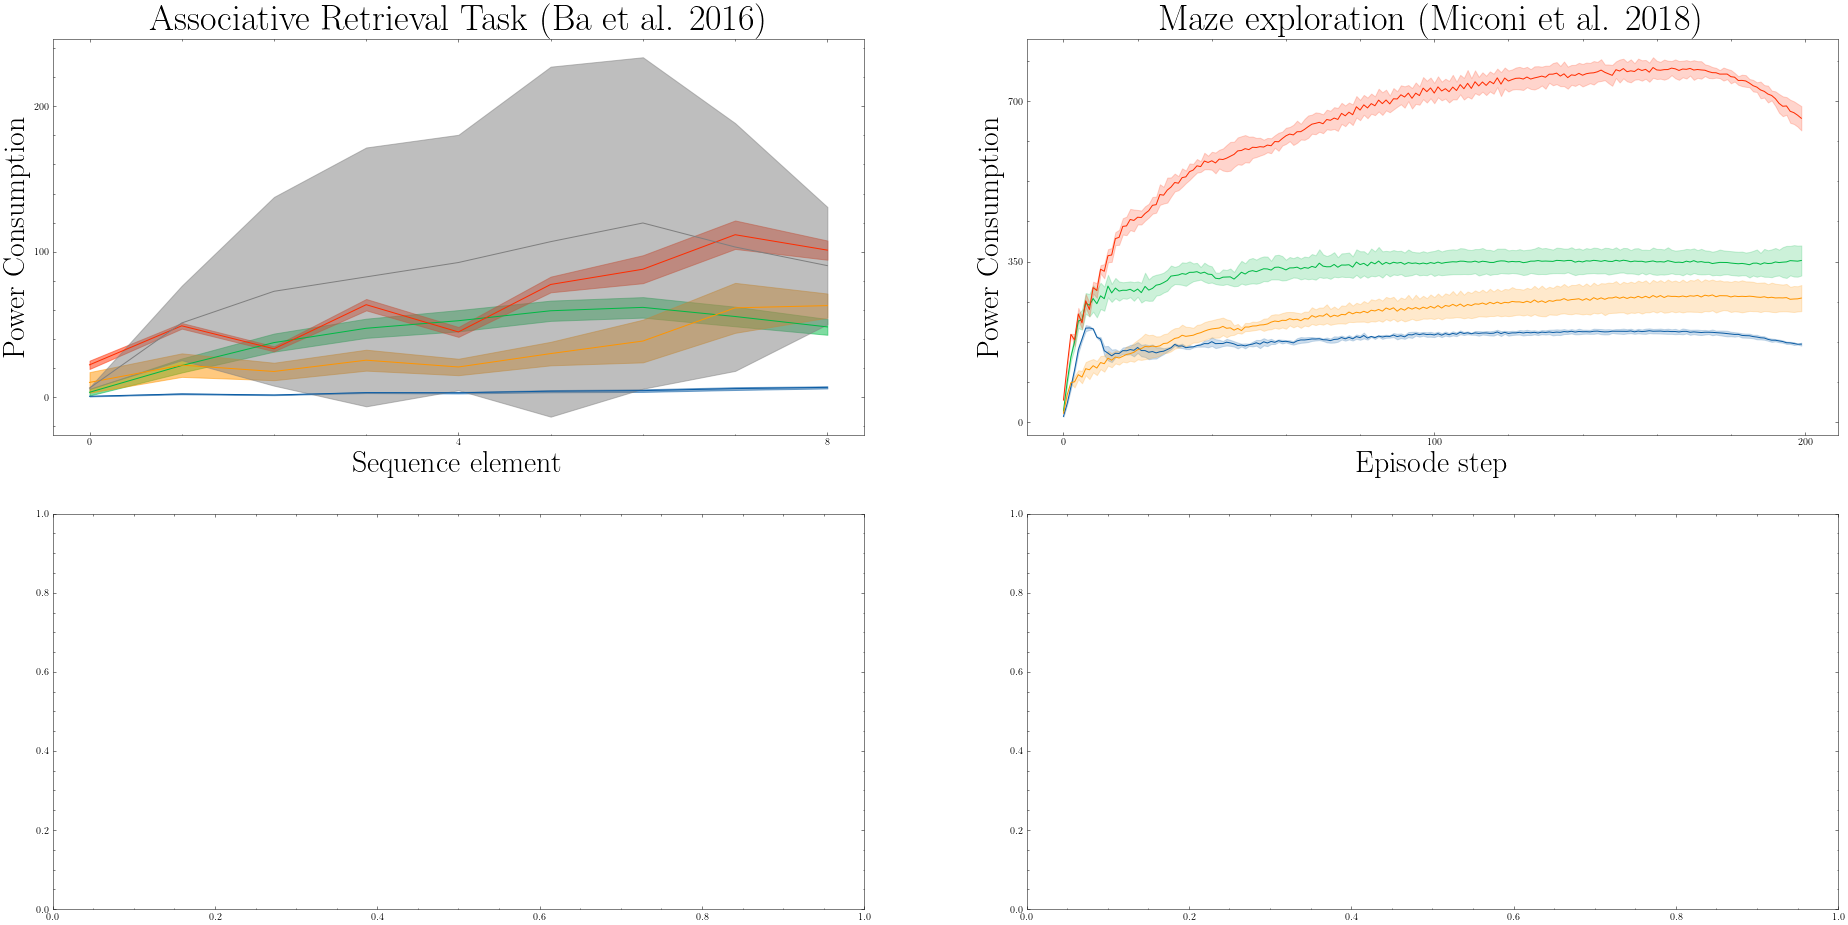

In [23]:
if default_aspect_ratio is False:
    plt.figure(figsize=(16, 8), dpi=80)
    
plt.sca(axs_eff[0, 1])
rewards = maze_eval_energies
labels = []

# 200 training iters
last_n_iters = 200 
max_iters = 200
plot_to_real_ratio = 1 
my_xticks = np.arange(plot_to_real_ratio*(max_iters-last_n_iters),plot_to_real_ratio*max_iters+1,10000)
x_my_ticks = np.arange(max_iters-last_n_iters,max_iters+1, 1000)
x = np.arange(max_iters-last_n_iters,max_iters)

mean_rewards, std_rewards = [], []
max_rewards, min_rewards = [], []

for exp_name, this_exp_cfg in experiment_suffix.items():
    rewards_seeds = []
    for seed in seeds:
        try:
            this_seed_rewards = np.expand_dims(np.array(rewards[exp_name][seed][max_iters-last_n_iters:max_iters]), 0)
        except:
            print('failed loading of reward for this exp name and seed')
            ipdb.set_trace()
        rewards_seeds.append(this_seed_rewards)
    
    try:
        rewards_seeds = np.concatenate(rewards_seeds, axis=0)
    except:
        print('failed concatenation of rewards for all seeds in this exp_name')
        ipdb.set_trace()
    #########
    rewards_seeds = np.mean(rewards_seeds, axis=(1))*this_exp_cfg['hs'] * this_exp_cfg.get('gates', 1)
    
    # mean and std over seeds
    if plot_line == 'mean': # [ 'mean', 'median']
        this_mean_rewards = np.mean(rewards_seeds, axis=0)
    elif plot_line == 'median': # [ 'mean', 'median']
        this_mean_rewards = np.median(rewards_seeds, axis=0)    
    this_std_rewards = np.std(rewards_seeds, axis=0)
    this_max_rewards, this_min_rewards = np.max(rewards_seeds, axis=0), np.min(rewards_seeds, axis=0) 
    # append results
    mean_rewards.append(this_mean_rewards)    
    std_rewards.append(this_std_rewards)
    max_rewards.append(this_max_rewards)
    min_rewards.append(this_min_rewards)
    labels.append(model2label[exp_name])    
mean_rewards, std_rewads = np.array(mean_rewards), np.array(std_rewards)
max_rewards, min_rewads = np.array(max_rewards), np.array(min_rewards)

###########################################################
###########################################################

accuracies, accuracies_std = mean_rewards, np.array(std_rewards)
min_accuracies, max_accuracies = np.array(min_rewards), np.array(max_rewards)
ids_meta_model = {}
rescale = lambda y, min_scale: (y - np.min(y)*min_scale) / (np.max(y) - np.min(y)*min_scale)
meta_models = [
    "STPN",
    "RNN",
    "LSTM",
    'Miconi',#'Modplast', #"MODPLAST"
]
seq_cmaps = [plt.cm.Blues, plt.cm.Reds, plt.cm.Oranges, plt.cm.Greens]
for i_meta_model, meta_model in enumerate(meta_models):
    ids_meta_model[meta_model] = np.array([meta_model in xlabel for xlabel in labels])
    if ids_meta_model[meta_model].sum() == 0:
        continue
    else:
        this_colors = seq_cmaps[i_meta_model](rescale(accuracies[ids_meta_model[meta_model]][:,-1], min_scale=0.95))
        for i_sub_model in range(this_colors.shape[0]):
            if meta_model not in global_colors:
                global_colors[meta_model] = this_colors[i_sub_model]
            plt.plot(
                x,
                accuracies[ids_meta_model[meta_model]][i_sub_model],
                color=global_colors[meta_model], 
                label= np.array(labels)[ids_meta_model[meta_model]][i_sub_model]
            )
            if plot_shaded is not False:
                if plot_shaded == 'std': # [ False, 'std', 'min_max']
                    bot_err = accuracies[ids_meta_model[meta_model]][i_sub_model] - accuracies_std[ids_meta_model[meta_model]][i_sub_model]
                    top_err = accuracies[ids_meta_model[meta_model]][i_sub_model] + accuracies_std[ids_meta_model[meta_model]][i_sub_model]
                elif plot_shaded == 'min_max':
                    bot_err = min_accuracies[ids_meta_model[meta_model]][i_sub_model]
                    top_err = max_accuracies[ids_meta_model[meta_model]][i_sub_model]
                else:
                    raise NotImplementedError
                plt.fill_between(
                    x,
                    bot_err,
                    top_err,
                    alpha=alphas[this_experiment],
                    color=global_colors[meta_model],
                )
    
##########################################################
##########################################################

plt.title(titles[this_experiment])
plt.ylabel(eff_ylabel, fontsize=fontsize_labels)
plt.xlabel(eff_xlabel[this_experiment], fontsize=fontsize_labels)
plt.locator_params(nbins=n_ticks)
yticks = np.linspace(0,700,n_ticks, dtype=int)
ylabels=yticks
plt.yticks(yticks, ylabels)

if eff_legend_subplots == 1 or eff_legend_subplots == 'all':
    plt.legend()


# Pong

In [24]:
this_experiment = 'Pong'

## Reward vs time (during training)

In [25]:
quantile = 0.25
plot_shaded = 'iqr_std' # [ False, 'std', 'min_max', 'iqr_std']
plot_line = 'iqm' # [ 'mean', 'median', 'iqm']

In [26]:
# ====================================== #
# Setup (runs to load, paths, etc) ===== #
# ====================================== #

runs_paths = {}
# to concatenate two or more experiment runs (eg. due to training restarting) just write those paths in a tuple
runs_paths['STPN'] = (
    ('stpn_configs/A2C_PongNoFrameskip-v4_7deae_00001_1_lr_schedule_0_1=0.0007,seed=0_2022-01-15_01-15-17', 'stpn_configs/A2C_PongNoFrameskip-v4_d962c_00000_0_2022-01-17_01-50-53'),
    ('stpn_configs/A2C_PongNoFrameskip-v4_7deae_00004_4_lr_schedule_0_1=0.0007,seed=1_2022-01-15_22-58-00', 'stpn_configs/A2C_PongNoFrameskip-v4_0f2c5_00000_0_2022-01-17_16-18-32'),
    ('stpn_configs/A2C_PongNoFrameskip-v4_3d235_00000_0_2022-01-19_03-52-59', 'stpn_configs/A2C_PongNoFrameskip-v4_f949e_00000_0_2022-01-23_17-36-43'), # crashed needs restarting, not doing very well
    'stpn_configs/A2C_PongNoFrameskip-v4_ddab2_00000_0_2022-01-22_01-45-04',
    'stpn_configs/A2C_PongNoFrameskip-v4_3e5b7_00000_0_2022-01-22_01-40-37',
)
runs_paths['LSTM'] = (
    'nonplastic_experiment/A2C_PongNoFrameskip-v4_c7abb_00002_2_lr_schedule_0_1=0.0001,seed=0_2022-01-17_01-30-02',
    'nonplastic_experiment/A2C_PongNoFrameskip-v4_c7abb_00005_5_lr_schedule_0_1=0.0001,seed=1_2022-01-18_06-53-42',
    ('nonplastic_experiment/A2C_PongNoFrameskip-v4_c7abb_00008_8_lr_schedule_0_1=0.0001,seed=42_2022-01-19_10-19-59','nonplastic_experiment/A2C_PongNoFrameskip-v4_e1163_00000_0_2022-01-23_17-28-52'), # restart
    'nonplastic_experiment/A2C_PongNoFrameskip-v4_eabd1_00001_1_seed=3_2022-01-22_16-33-24',
    'nonplastic_experiment/A2C_PongNoFrameskip-v4_eabd1_00000_0_seed=2_2022-01-22_16-33-04',
)

file = 'progress.csv'

# here seeds are only used to indicate the number of experiment runs, we just use the given experiment paths above in order
seeds = global_seeds[this_experiment]
metrics = ["episode_reward_mean"] # could load multiple metrixs, eg. also episode_reward_max
time_index = ["timesteps_total"]

In [27]:
# ====================================== #
# Load data ============================ # 
# ====================================== #
df = {}
drop_N_first_rows_of_restarting = 100

for exp_name, exp_paths in runs_paths.items():
    df[exp_name] = {}
    for i, seed in enumerate(seeds):
        # if single 
        if isinstance(runs_paths[exp_name][i], str):
            path_to_csv = os.path.join(base_path_pong,runs_paths[exp_name][i], file)
            df[exp_name][i] = pd.read_csv(path_to_csv, usecols = metrics+time_index)
            df[exp_name][i][metrics] = df[exp_name][i][metrics].fillna(-21)  # in early episode rllib returns NaN rewards
            print(df[exp_name][i].head())
        elif isinstance(runs_paths[exp_name][i], tuple):
            path_to_csv = os.path.join(base_path_pong,runs_paths[exp_name][i][0], file)
            df[exp_name][i] = pd.read_csv(path_to_csv, usecols = metrics+time_index)
            df[exp_name][i][metrics] = df[exp_name][i][metrics].fillna(-21)  # in early episode rllib returns NaN rewards
            for i_run in range(1,len(runs_paths[exp_name][i])):
                path_to_csv = os.path.join(base_path_pong,runs_paths[exp_name][i][i_run], file)
                df_run = pd.read_csv(path_to_csv, usecols = metrics+time_index)
                df_run[metrics] = df_run[metrics].fillna(-21)  # in early episode rllib returns NaN rewards
                df_run = df_run.iloc[drop_N_first_rows_of_restarting: , :]
                df[exp_name][i] = df[exp_name][i].append(df_run, ignore_index=True)
            
            print(df[exp_name][i].head())
            print(df[exp_name][i].tail())

   episode_reward_mean  timesteps_total
0                -21.0             3200
1                -21.0             9600
2                -21.0            16000
3                -21.0            22400
4                -21.0            28800
       episode_reward_mean  timesteps_total
15561                19.59         99977600
15562                19.59         99984000
15563                19.58         99990400
15564                19.59         99996800
15565                19.59        100003200
   episode_reward_mean  timesteps_total
0                -21.0             3200
1                -21.0             9600
2                -21.0            16000
3                -21.0            22400
4                -21.0            28800
       episode_reward_mean  timesteps_total
15618                19.41         99977600
15619                19.41         99984000
15620                19.38         99990400
15621                19.41         99996800
15622                19.42        10

STPN
LSTM


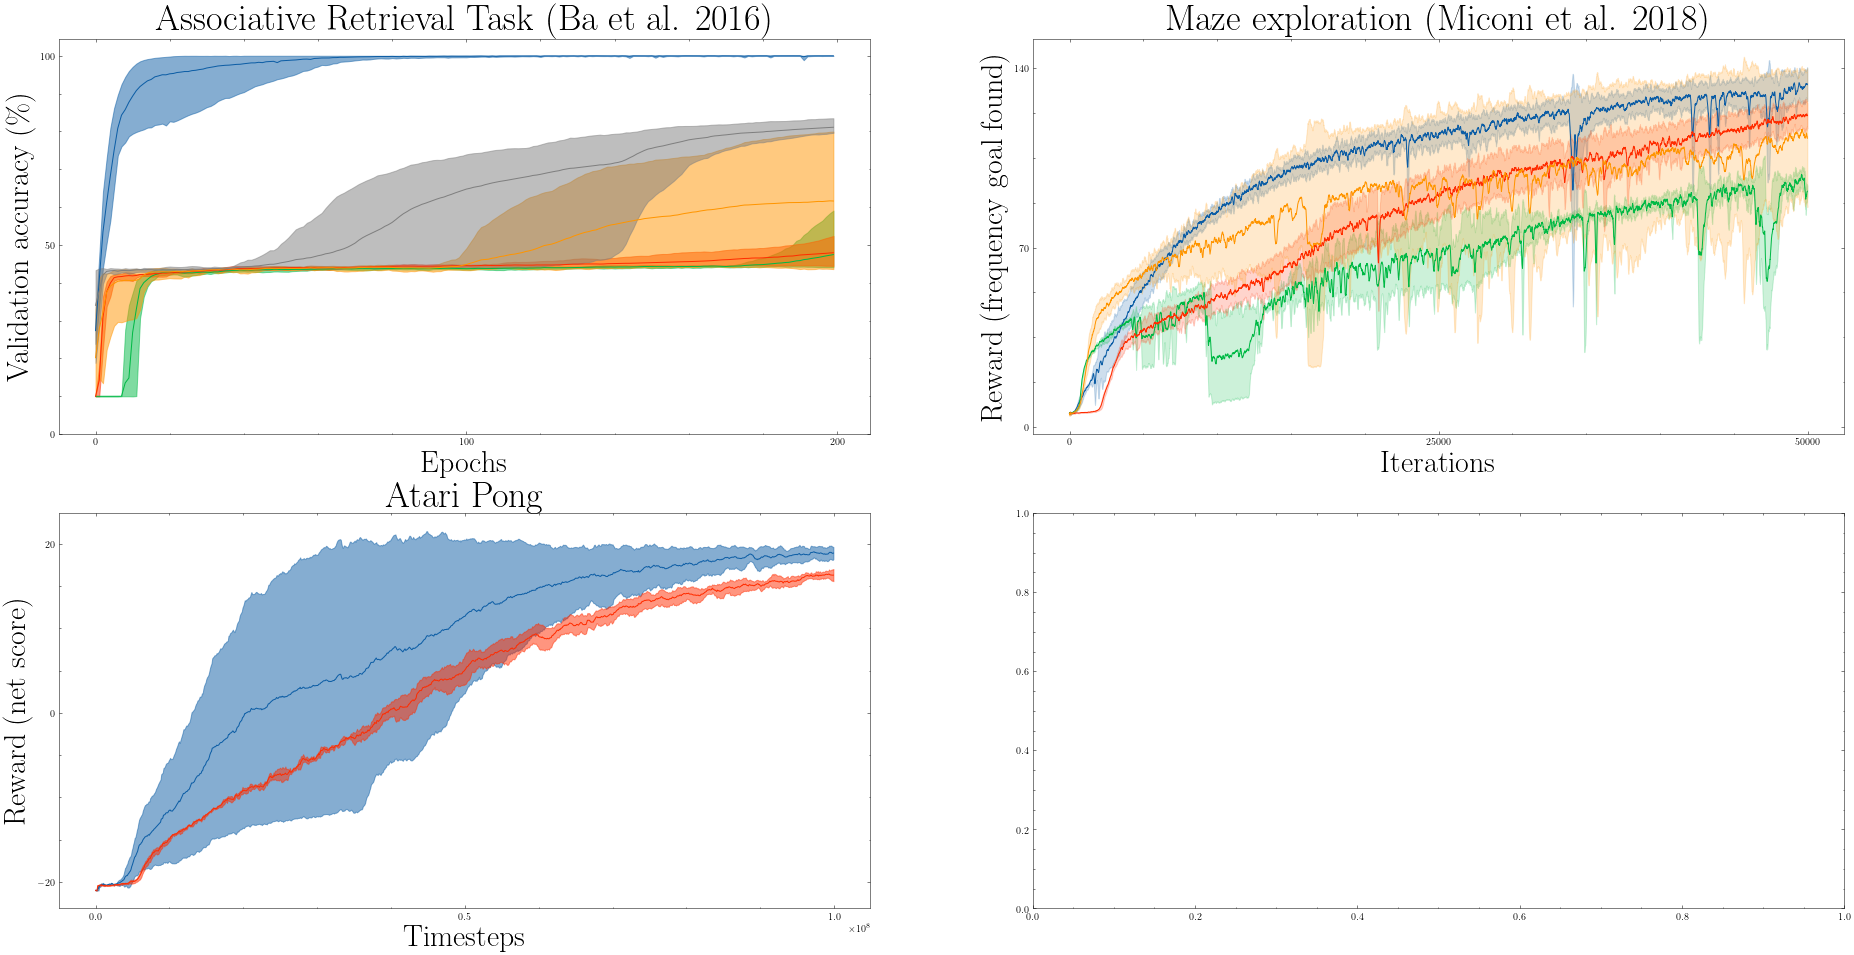

In [28]:
# ====================================== #
# Process and plot data ================ #
# ====================================== #

plt.sca(axs_prof[1, 0])

dict_metrics = { "episode_reward_mean": "mean episode reward", "episode_reward_max": "max episode reward"}
ts_total = 1e8
xs = np.arange(ts_total)
xs = np.arange(0, ts_total, 100)
pick_every_n_sample = 1000 # downsample for faster loading
for metric in metrics: 
    for exp_name, exp_paths in runs_paths.items():
        color=None
        print(exp_name)
        exp_curve = []
        best_seed_val = -np.inf
        his_seeds_curve, this_seeds_timesteps = [], []
        yinterps = []
        for i in seeds:
            this_seed_curve = df[exp_name][i][metric].to_numpy()
            this_seed_timesteps = df[exp_name][i]["timesteps_total"].to_numpy()
            
            yinterp = np.interp(xs, this_seed_timesteps, this_seed_curve)
            
            yinterps.append(yinterp)
        if plot_line == 'median':
            y = np.median(np.array(yinterps), axis=0)
        elif plot_line == 'mean':
            y = np.mean(np.array(yinterps), axis=0)
        elif plot_line == 'iqm':
            y = iqr_operator(np.array(yinterps), quantile=quantile, axis=0, operation='mean')
        else:
            print("plot_line", plot_line, "not supported")
            raise NotImplementedError
        
        for meta_model, meta_model_color in global_colors.items():
            if meta_model in exp_name:
                color = meta_model_color
        plt.plot(xs[::pick_every_n_sample], y[::pick_every_n_sample], color=color, label=model2label[exp_name])#f"{exp_name}",)
        
        if plot_shaded is False:
            pass
        else:
            if plot_shaded == 'std':
                error = np.array(yinterps).std(0)
                plt.fill_between(xs[::pick_every_n_sample], (y-error)[::pick_every_n_sample], (y+error)[::pick_every_n_sample],
                                 alpha=alphas[this_experiment], color=color)
            elif plot_shaded == 'iqr_std':
                error = iqr_operator(np.array(yinterps), quantile =quantile, axis=0, operation='std')
                plt.fill_between(xs[::pick_every_n_sample], (y-error)[::pick_every_n_sample], (y+error)[::pick_every_n_sample],
                                 alpha=alphas[this_experiment], color=color)
            else:
                raise NotImplementedError    
    if prof_legend_subplots == 1 or prof_legend_subplots == 'all':
        plt.legend()
    plt.title(titles[this_experiment])
    plt.ylabel(prof_ylabel[this_experiment], fontsize=fontsize_labels)
    plt.xlabel(prof_xlabel[this_experiment], fontsize=fontsize_labels)
    plt.locator_params(nbins=n_ticks)

## Energy vs time & reward per episode (during evaluation) 

In [29]:
# ========================================================================================================= #
# re-define the runs because training runs might have multiple concatenated runs (due to restarts), ======= #
# but we only evaluate final agent ======================================================================== #
# ========================================================================================================= #
runs_paths = {}
runs_paths['STPN'] = (
    'stpn_configs/A2C_PongNoFrameskip-v4_d962c_00000_0_2022-01-17_01-50-53', 
    'stpn_configs/A2C_PongNoFrameskip-v4_0f2c5_00000_0_2022-01-17_16-18-32', 
    'stpn_configs/A2C_PongNoFrameskip-v4_ddab2_00000_0_2022-01-22_01-45-04', 
    'stpn_configs/A2C_PongNoFrameskip-v4_3e5b7_00000_0_2022-01-22_01-40-37', 
    'stpn_configs/A2C_PongNoFrameskip-v4_f949e_00000_0_2022-01-23_17-36-43', 
)
runs_paths['LSTM'] = (
    'nonplastic_experiment/A2C_PongNoFrameskip-v4_c7abb_00002_2_lr_schedule_0_1=0.0001,seed=0_2022-01-17_01-30-02',
    'nonplastic_experiment/A2C_PongNoFrameskip-v4_c7abb_00005_5_lr_schedule_0_1=0.0001,seed=1_2022-01-18_06-53-42',
    'nonplastic_experiment/A2C_PongNoFrameskip-v4_eabd1_00000_0_seed=2_2022-01-22_16-33-04', 
    'nonplastic_experiment/A2C_PongNoFrameskip-v4_eabd1_00001_1_seed=3_2022-01-22_16-33-24', 
    'nonplastic_experiment/A2C_PongNoFrameskip-v4_e1163_00000_0_2022-01-23_17-28-52',
)

base_path_pong_eval = os.path.join(base_path_pong, 'eval')

hidden_sizes = {
    'stpn': 64,
    'lstm': 48,
}

seeds = global_seeds_eval[this_experiment]

In [30]:
# ====================================== #
# Load evaluation data ================= #
# ====================================== #

num_episodes_during_inference = 1
energy_reporting = 'per_episode_step' # Other options

n_moving_average = False

# get latest evaluation results 
rewards, energy_per_episode_step, mean_energy_per_episode = {}, {}, {}
for exp_name, exp_paths in runs_paths.items():
    rewards[exp_name], energy_per_episode_step[exp_name], mean_energy_per_episode[exp_name] = {}, {}, {}
    for i, seed in enumerate(seeds):
        path_model = os.path.join(base_path_pong_eval,runs_paths[exp_name][i])
        assert len(get_immediate_subdirectories(path_model)) == 1
        path_checkpoint = get_immediate_subdirectories(path_model)[0]
        store_path = os.path.join(path_model, path_checkpoint)
        
        # save energy
        # I think saving the mean of each episode is the best option outside of saving the energy of each episiode independently
        # Another option would be to average the nergy at each timestep for all episode, but this might not be so great at each episode might be doing very differently
        with open(
                os.path.join(store_path,f"{num_episodes_during_inference}_episodes_energy_{energy_reporting}.npy"), 'rb'
            ) as energy_results_file:
            energy = np.load(energy_results_file)
            
            if energy_reporting == 'per_episode_step':
                # big array with (episodes, max episode_length)
                energy_all_episodes = []
                for i_episode in range(energy.shape[0]):
                    energy_this_episode = []
                    this_episode_length = len(energy[i_episode])
                    for i_episode_step, episode_step in enumerate(energy[i_episode]):
                        if episode_step < 0:
                            this_episode_length = i_episode_step
                    energy_this_episode.append(energy[:this_episode_length+1])
                energy_per_episode_step[exp_name][seed] = energy_this_episode
                
                # calculate the mean as well
                mean_energy_all_episodes = []
                for energies_this_episode in energy_per_episode_step[exp_name][seed]:
                    mean_energy_all_episodes.append(energies_this_episode.mean())
                mean_energy_per_episode[exp_name][seed] = np.array(mean_energy_all_episodes)
            else:
                mean_energy_per_episode[exp_name][seed] = energy
                
        # save reward
        with open(
            os.path.join(store_path,f"{num_episodes_during_inference}_episodes_reward.txt")
        ) as f:
            rewards_file = f.read()
            rewards[exp_name][seed] = np.array([float(i_loss) for i_loss in rewards_file.split()])
        
        if n_moving_average is not False:
            rewards[exp_name][seed][n_moving_average-1:] = moving_average(rewards[exp_name][seed], n_moving_average)

In [31]:
# ====================================== #
# Obtain summary stats for eval data === #
# ====================================== #

dict_labels = {
    'STPN': 'STPN (ours)',
    'LSTM': 'LSTM',
}

mean_rewards_for_df, mean_energy_for_df, labels_for_df = [], [], []
std_rewards_for_df, std_energy_for_df = [], []
for exp_name, exp_paths in runs_paths.items():
    reward_all_seeds, energy_all_seeds = [], []
    for i, seed in enumerate(seeds):
        # we average episodes for each seed
        reward_all_seeds.append(rewards[exp_name][seed].mean())
        energy_all_seeds.append(mean_energy_per_episode[exp_name][seed].mean())
        
    # iqr
    mean_rewards_for_df.append(iqr_operator(
            reward_all_seeds, # List[List] or np.array()
            quantile=0.25,
            axis=0,
            operation='mean',
        )
    )
    std_rewards_for_df.append(iqr_operator(
            reward_all_seeds, # List[List] or np.array()
            quantile=0.25,
            axis=0,
            operation='std', # ['mean', 'std']
        )
    )
    mean_energy_for_df.append(iqr_operator(
            energy_all_seeds, # List[List] or np.array()
            quantile=0.25,
            axis=0,
            operation='mean', # ['mean', 'std']
        )
    )
    std_energy_for_df.append(iqr_operator(
            energy_all_seeds, # List[List] or np.array()
            quantile=0.25,
            axis=0,
            operation='std', # ['mean', 'std']
        )
    )
    labels_for_df.append(model2label[exp_name])

In [32]:
# ====================================== #
# Crate evaluation table =============== #
# ====================================== #

xlabels = labels_for_df
accuracies_mean, mean_energies = mean_rewards_for_df, mean_energy_for_df
accuracies_std, mean_energies_std = std_rewards_for_df, std_energy_for_df


percent_factor = 1 # 100
accuracies_for_df = []
energies_for_df = []
acc_decimals = 1
energy_decimals = 1
for i_model, model_name in enumerate(xlabels):
    accuracies_for_df.append(f"{percent_factor*accuracies_mean[i_model]:.{acc_decimals}f}  +- {percent_factor*accuracies_std[i_model]:.{acc_decimals}f}")
    energies_for_df.append(f"{mean_energies[i_model]:.{energy_decimals}f}  +- {mean_energies_std[i_model]:.{energy_decimals}f}")
accuracies_for_df = np.array(accuracies_for_df, dtype=object)
energies_for_df = np.array(energies_for_df, dtype=object)
    

# data = np.array([xlabels.T, accuracies.T, mean_energies.T], dtype=object)
data = np.array([np.array(xlabels).T, accuracies_for_df.T, energies_for_df.T], dtype=object)

print(data)
print(data.shape)
df_pong_eval = pd.DataFrame(data.T, columns=['Model', 'Test accuracy', 'Power consumption'])

[['STPN (Ours)' 'LSTM']
 ['20.7  +- 0.5' '18.0  +- 4.6']
 ['52.7  +- 6.4' '576.8  +- 33.5']]
(3, 2)


In [33]:
df_pong_eval

Model Test accuracy Power consumption
0  STPN (Ours)  20.7  +- 0.5      52.7  +- 6.4
1         LSTM  18.0  +- 4.6    576.8  +- 33.5

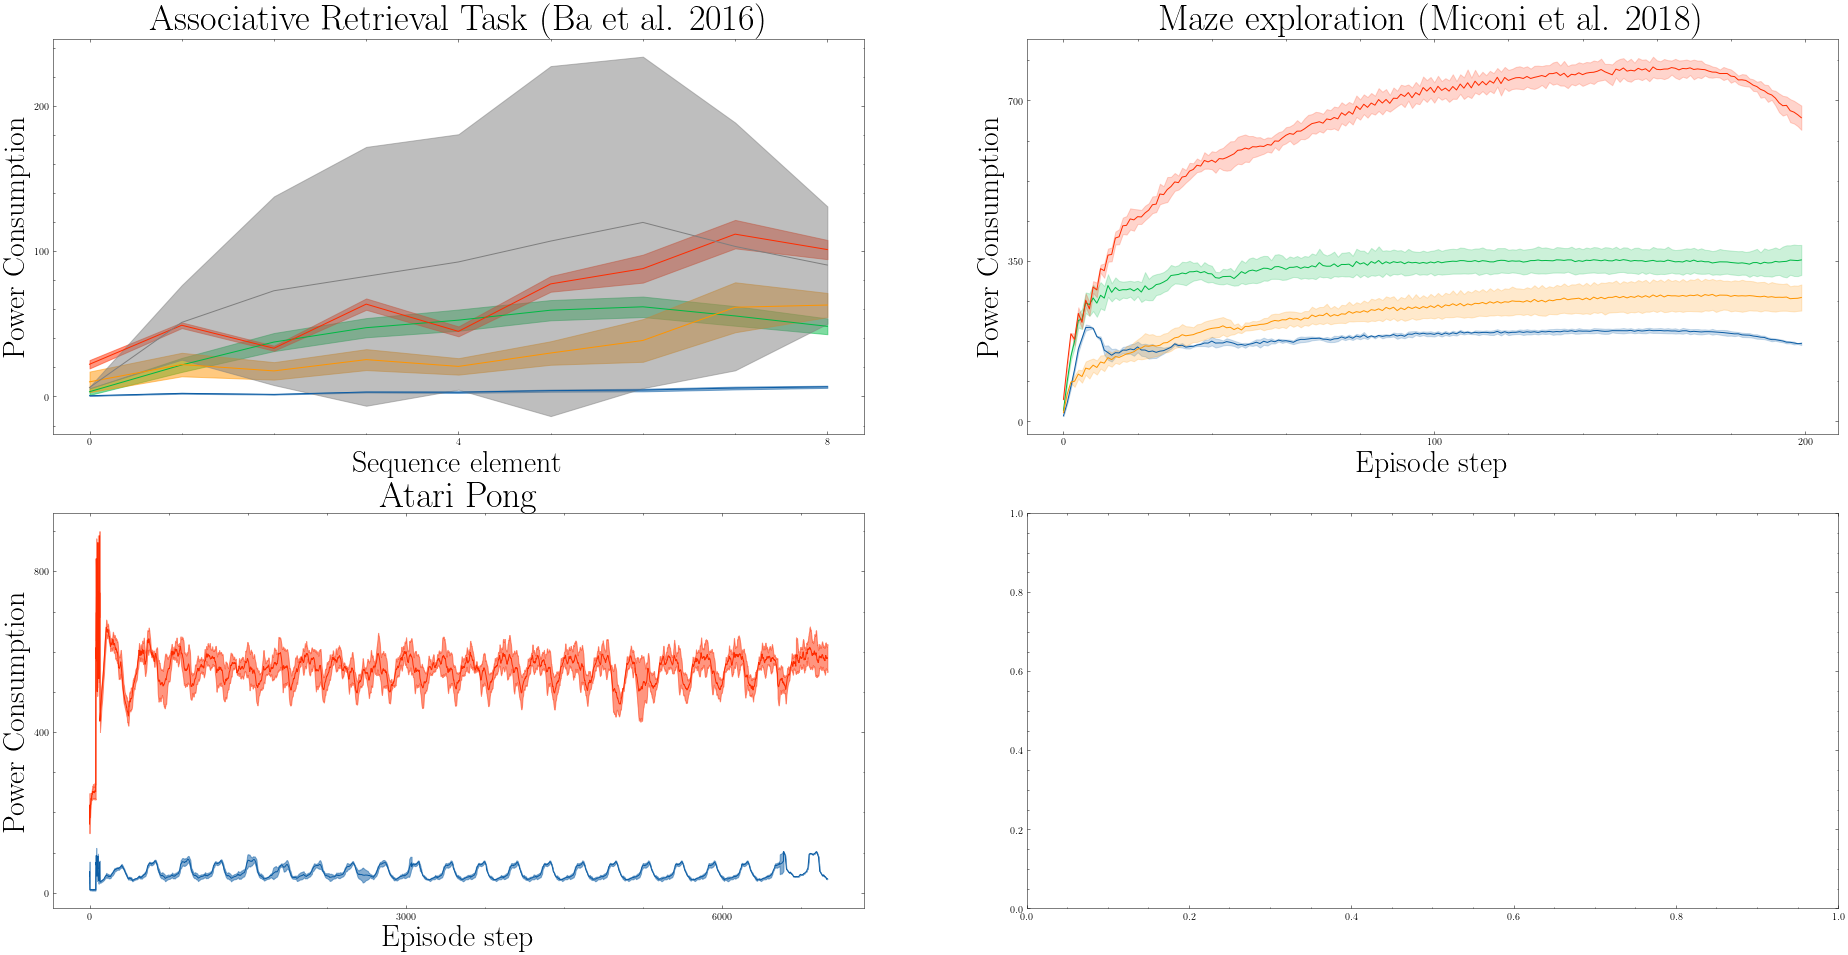

In [34]:
# ====================================== #
# Plot energy during eval ============== #
# ====================================== #

plt.sca(axs_eff[1, 0])
smoothings = [1, 25, 100]
all_max_episode_steps = [350, 500, 1000, 7000]
# different tuples will plot multiple times
# (smoothing, max_episode_steps)
plot_configs = [
    (100, 7000),
]
plot_how = 'seeds_join' # ['seeds_separate', 'seeds_join']
if energy_reporting == 'per_episode_step':    
    for smoothing, max_episode_steps in plot_configs:
            for exp_name, exp_paths in runs_paths.items():
                color=None
                exp_curve, all_seeds_curve = [], []
                best_seed_val = -np.inf
                for i, seed in enumerate(seeds):
                    this_seed_curve = moving_average(energy_per_episode_step[exp_name][i][0][0][:max_episode_steps], smoothing) # not sure why these [0][0] are needed
                    if exp_name in global_colors:
                            color = global_colors[exp_name]
                    else:
                        for meta_model, meta_model_color in global_colors.items():
                            if exp_name in meta_model:
                                color = meta_model_color
                    if plot_how == 'seeds_separate':
                        plt.plot(this_seed_curve, color=color, label=model2label[exp_name])
                    elif plot_how == 'seeds_join':
                        all_seeds_curve.append(this_seed_curve)
                
                if plot_how == 'seeds_join':
                    # we want mean accross seeds. However they wont have the same length. Luckily they have the same timesteps
                    # we should define our own mean that interporlates until last timestep, then use the only ones still surviving
                    # then averages that (acc this step of getting the mean of that is easy)
                    joint_curve = cat_diff_len(all_seeds_curve, operator=iqr_operator, operator_kwargs={'axis': 0})
                    plt.plot(joint_curve, label=model2label[exp_name], color=color)
                    error = cat_diff_len(all_seeds_curve, operator=iqr_operator, operator_kwargs={'axis': 0, 'operation': 'std'})
                    xs = np.arange(len(joint_curve))
                    plt.fill_between(xs, joint_curve-error, joint_curve+error, alpha=alphas[this_experiment],color=color)
                    
            if eff_legend_subplots == 2 or eff_legend_subplots == 'all':
                plt.legend()
            plt.title(titles[this_experiment])
            plt.xlabel(eff_xlabel[this_experiment], fontsize=fontsize_labels)
            plt.ylabel(eff_ylabel, fontsize=fontsize_labels)
            xticks = np.linspace(0,6000,n_ticks, dtype=int)
            xlabels=xticks
            plt.xticks(xticks, xlabels)
            
            yticks = np.linspace(0,800,n_ticks, dtype=int)
            ylabels=yticks
            plt.yticks(yticks, ylabels)

# Pendulum

In [35]:
this_experiment = 'Pendulum'

## Reward vs time

In [36]:
plot_shaded = 'std' # [ False, 'std', 'min_max']
plot_line = 'median' # [ 'mean', 'median']

In [37]:
runs_paths = {}

runs_paths['STPN'] = (
    'STPNf/PPO_InvertedPendulum-v2_a4e43_00001_1_num_gpus=0.5,seed=0_2022-01-25_21-21-11',# seed 0
    'STPNf/PPO_InvertedPendulum-v2_a4e43_00003_3_num_gpus=0.5,seed=1_2022-01-25_21-21-38',# seed 1
    'STPNf/PPO_InvertedPendulum-v2_a4e43_00005_5_num_gpus=0.5,seed=42_2022-01-25_21-22-07',# seed 42
)
runs_paths['RNN'] = (
    'nonplastic_experiment/PPO_InvertedPendulum-v2_09f86_00003_3_rnn_type=rnn,num_gpus=0.5,seed=0_2022-01-26_04-12-22',# seed 0
    'nonplastic_experiment/PPO_InvertedPendulum-v2_09f86_00007_7_rnn_type=rnn,num_gpus=0.5,seed=1_2022-01-26_04-13-04',# seed 1
    'nonplastic_experiment/PPO_InvertedPendulum-v2_09f86_00011_11_rnn_type=rnn,num_gpus=0.5,seed=42_2022-01-26_04-13-47',# seed 42
)

runs_paths['MLP'] = (
    'nonplastic_experiment/PPO_InvertedPendulum-v2_a4e43_00006_6_num_gpus=0,seed=0_2022-01-25_21-22-27',# seed 0
    'nonplastic_experiment/PPO_InvertedPendulum-v2_a4e43_00008_8_num_gpus=0,seed=1_2022-01-25_21-22-59',# seed 1
    'nonplastic_experiment/PPO_InvertedPendulum-v2_a4e43_00010_10_num_gpus=0,seed=42_2022-01-25_21-23-30',# seed 42        
)


runs_paths['LSTM'] = (
    'nonplastic_experiment/PPO_InvertedPendulum-v2_09f86_00002_2_rnn_type=lstm,num_gpus=0.5,seed=0_2022-01-26_04-12-09',# seed 0
    'nonplastic_experiment/PPO_InvertedPendulum-v2_09f86_00006_6_rnn_type=lstm,num_gpus=0.5,seed=1_2022-01-26_04-12-51',# seed 1
    'nonplastic_experiment/PPO_InvertedPendulum-v2_09f86_00010_10_rnn_type=lstm,num_gpus=0.5,seed=42_2022-01-26_04-13-33',# seed 42
)

# ##################
file = 'progress.csv'

seeds = global_seeds[this_experiment]
metrics = ["episode_reward_mean"]
time_index = ['timesteps_total']

In [38]:
# ====================================== #
# Load data ============================ #
# ====================================== #

df = {}
for exp_name, exp_paths in runs_paths.items():
    print(exp_name)
    df[exp_name] = {}
    for i in seeds:
        path_to_csv = os.path.join(base_path_pendulum,runs_paths[exp_name][i], file)
        print(path_to_csv)
        df[exp_name][i] = pd.read_csv(path_to_csv, usecols = metrics + time_index)
        df[exp_name][i][metrics] = df[exp_name][i][metrics].fillna(0)
        print(df[exp_name][i].head())

STPN
/home/username/workspace/STPN/results/ray/PPO/InvertedPendulum-v2/STPNf/PPO_InvertedPendulum-v2_a4e43_00001_1_num_gpus=0.5,seed=0_2022-01-25_21-21-11/progress.csv
   episode_reward_mean  timesteps_total
0             4.222680             2048
1             4.843602             4096
2             6.041420             6144
3             7.443636             8192
4            10.238806            10240
/home/username/workspace/STPN/results/ray/PPO/InvertedPendulum-v2/STPNf/PPO_InvertedPendulum-v2_a4e43_00003_3_num_gpus=0.5,seed=1_2022-01-25_21-21-38/progress.csv
   episode_reward_mean  timesteps_total
0             5.309091             2048
1             7.192982             4096
2            10.078818             6144
3            13.952055             8192
4            15.968750            10240
/home/username/workspace/STPN/results/ray/PPO/InvertedPendulum-v2/STPNf/PPO_InvertedPendulum-v2_a4e43_00005_5_num_gpus=0.5,seed=42_2022-01-25_21-22-07/progress.csv
   episode_reward_mean  t

STPN
RNN
MLP
LSTM


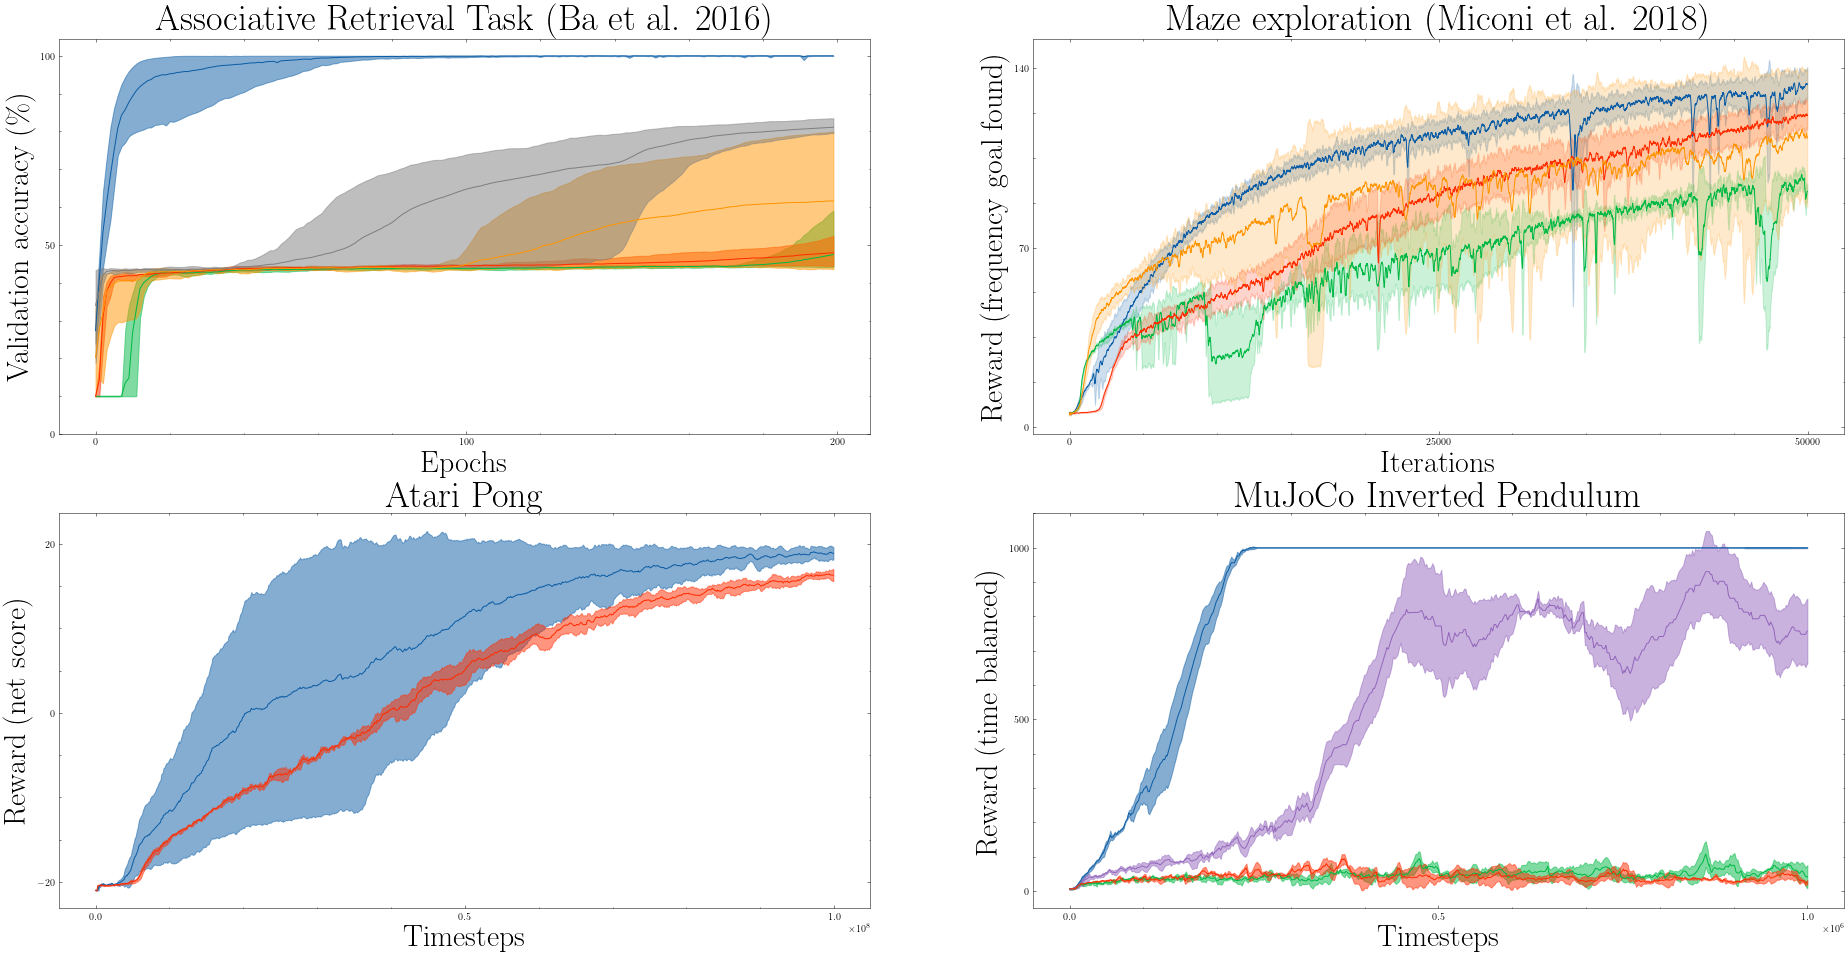

In [39]:
# ====================================== #
# Plot data ============================ #
# ====================================== #

plt.sca(axs_prof[1, 1])

xs = np.arange(1e6)
xs = np.arange(0, 1e6, 100)
for metric in metrics: 
    for exp_name, exp_paths in runs_paths.items():
        color=None
        if exp_name in ["stpn", "rnn", "lstm"]:
            continue
        print(exp_name)
        exp_curve = []
        best_seed_val = -np.inf
        his_seeds_curve, this_seeds_timesteps = [], []
        yinterps = []
        for i in seeds:
            this_seed_curve = df[exp_name][i][metric].to_numpy()
            this_seed_timesteps = df[exp_name][i]["timesteps_total"].to_numpy()
            yinterp = np.interp(xs, this_seed_timesteps, this_seed_curve)
            yinterps.append(yinterp)
        
        if plot_line == 'median':
            y = np.median(np.array(yinterps), axis=0)
        elif plot_line == 'mean':
            y = np.mean(np.array(yinterps), axis=0)
        else:
            raise NotImplementedError
        if exp_name in global_colors:
            color = global_colors[exp_name]
        else:
            for meta_model, meta_model_color in global_colors.items():
                if exp_name in meta_model:
                    color = meta_model_color                
        plt.plot(xs, y, color=color, label=model2label[exp_name])
        
        if plot_shaded is False:
            pass
        else:
            if plot_shaded == 'std':
                error = np.array(yinterps).std(0)
                plt.fill_between(xs, y-error, y+error, alpha=alphas[this_experiment],#0.5,
                                 color=color)
            else:
                raise NotImplementedError
                
    if prof_legend_subplots == 3 or prof_legend_subplots == 'all':
        plt.legend()

    plt.title(titles[this_experiment])
    plt.ylabel(prof_ylabel[this_experiment], fontsize=fontsize_labels)
    plt.xlabel(prof_xlabel[this_experiment], fontsize=fontsize_labels)
    plt.locator_params(nbins=n_ticks)

## Energy vs time & reward per episode (during evaluation)

In [40]:
runs_paths = {}
runs_paths['STPN'] = (
    # == STPNf clamp
    'STPNf/PPO_InvertedPendulum-v2_a4e43_00001_1_num_gpus=0.5,seed=0_2022-01-25_21-21-11',# seed 0
    'STPNf/PPO_InvertedPendulum-v2_a4e43_00003_3_num_gpus=0.5,seed=1_2022-01-25_21-21-38',# seed 1
    'STPNf/PPO_InvertedPendulum-v2_a4e43_00005_5_num_gpus=0.5,seed=42_2022-01-25_21-22-07',# seed 42
)
runs_paths['RNN'] = (
    'nonplastic_experiment/PPO_InvertedPendulum-v2_09f86_00003_3_rnn_type=rnn,num_gpus=0.5,seed=0_2022-01-26_04-12-22',# seed 0
    'nonplastic_experiment/PPO_InvertedPendulum-v2_09f86_00007_7_rnn_type=rnn,num_gpus=0.5,seed=1_2022-01-26_04-13-04',# seed 1
    'nonplastic_experiment/PPO_InvertedPendulum-v2_09f86_00011_11_rnn_type=rnn,num_gpus=0.5,seed=42_2022-01-26_04-13-47',# seed 42
)

runs_paths['MLP'] = (
    'nonplastic_experiment/PPO_InvertedPendulum-v2_a4e43_00006_6_num_gpus=0,seed=0_2022-01-25_21-22-27',# seed 0
    'nonplastic_experiment/PPO_InvertedPendulum-v2_a4e43_00008_8_num_gpus=0,seed=1_2022-01-25_21-22-59',# seed 1
    'nonplastic_experiment/PPO_InvertedPendulum-v2_a4e43_00010_10_num_gpus=0,seed=42_2022-01-25_21-23-30',# seed 42        
)


runs_paths['LSTM'] = (
    'nonplastic_experiment/PPO_InvertedPendulum-v2_09f86_00002_2_rnn_type=lstm,num_gpus=0.5,seed=0_2022-01-26_04-12-09',# seed 0
    'nonplastic_experiment/PPO_InvertedPendulum-v2_09f86_00006_6_rnn_type=lstm,num_gpus=0.5,seed=1_2022-01-26_04-12-51',# seed 1
    'nonplastic_experiment/PPO_InvertedPendulum-v2_09f86_00010_10_rnn_type=lstm,num_gpus=0.5,seed=42_2022-01-26_04-13-33',# seed 42
)

base_path_pendulum_eval = os.path.join(base_path_pendulum, 'eval')

hidden_sizes = {
    'stpn': 64,
    'lstm': 64, #48,
    'rnn': 64,
}

seeds = global_seeds_eval[this_experiment]

In [41]:
# ====================================== #
# Load data ============================ #
# ====================================== #

num_episodes_during_inference = 10 #100 # 1
energy_reporting = 'per_episode_step' # 'per_episode_step'

n_moving_average = False

rewards, energy_per_episode_step, mean_energy_per_episode = {}, {}, {}
for exp_name, exp_paths in runs_paths.items():
    rewards[exp_name], energy_per_episode_step[exp_name], mean_energy_per_episode[exp_name] = {}, {}, {}
    for i, seed in enumerate(seeds):
        path_model = os.path.join(base_path_pendulum_eval,runs_paths[exp_name][i])
        # TODOD: fix this, should support subdirectory with evaluations of more tha one eval of diff checkpoints
        assert len(get_immediate_subdirectories(path_model)) == 1, f"Model has more than one eval {path_model}"
        path_checkpoint = get_immediate_subdirectories(path_model)[0]
        store_path = os.path.join(path_model, path_checkpoint)
        energy_results_file = os.path.join(store_path,f"{num_episodes_during_inference}_episodes_energy_{energy_reporting}.npy")
        energy = np.load(energy_results_file, allow_pickle=True)

        if energy_reporting == 'per_episode_step':
            # big array with (episodes, max episode_length)
            energy_all_episodes = []
            for i_episode in range(energy.shape[0]):
                energy_this_episode = []
                this_episode_length = len(energy[i_episode])
                for i_episode_step, episode_step in enumerate(energy[i_episode]):
                    if episode_step < 0:
                        this_episode_length = i_episode_step
                energy_this_episode.append(energy[:this_episode_length+1])
            energy_per_episode_step[exp_name][seed] = energy_this_episode

            # calculate the mean as well
            mean_energy_all_episodes = []
            for energies_this_episode in energy_per_episode_step[exp_name][seed]:
                mean_energy_all_episodes.append(energies_this_episode.mean())
            mean_energy_per_episode[exp_name][seed] = np.array(mean_energy_all_episodes)
        else:
            mean_energy_per_episode[exp_name][seed] = energy
                
        # save reward
        with open(
            os.path.join(store_path,f"{num_episodes_during_inference}_episodes_reward.txt")
        ) as f:
            # It doesn't average, just takes evry 10
            rewards_file = f.read()
            rewards[exp_name][seed] = np.array([float(i_loss) for i_loss in rewards_file.split()])
        
        if n_moving_average is not False:
            rewards[exp_name][seed][n_moving_average-1:] = moving_average(rewards[exp_name][seed], n_moving_average)

In [42]:
# ====================================== #
# Obtain summary statistic ============= #
# ====================================== #

dict_labels = {
    'STPN': 'STPN (ours)',
    'LSTM': 'LSTM',
    'RNN': 'RNN',
    'MLP': 'MLP',
}

mean_rewards_for_df, mean_energy_for_df, labels_for_df = [], [], []
std_rewards_for_df, std_energy_for_df = [], []
for exp_name, exp_paths in runs_paths.items():
    reward_all_seeds, energy_all_seeds = [], []
    for i, seed in enumerate(seeds):
        # we average episodes for each seed
        reward_all_seeds.append(rewards[exp_name][seed].mean())
        energy_all_seeds.append(mean_energy_per_episode[exp_name][seed].mean())        
    # iqr
    mean_rewards_for_df.append(iqr_operator(
            reward_all_seeds, # List[List] or np.array()
            quantile=0.25,
            axis=0,
            operation='mean',
        )
    )
    std_rewards_for_df.append(iqr_operator(
            reward_all_seeds, # List[List] or np.array()
            quantile=0.25,
            axis=0,
            operation='std', # ['mean', 'std']
        )
    )
    mean_energy_for_df.append(iqr_operator(
            energy_all_seeds, # List[List] or np.array()
            quantile=0.25,
            axis=0,
            operation='mean', # ['mean', 'std']
        )
    )
    std_energy_for_df.append(iqr_operator(
            energy_all_seeds, # List[List] or np.array()
            quantile=0.25,
            axis=0,
            operation='std', # ['mean', 'std']
        )
    )
    
    # mean
    labels_for_df.append(dict_labels[exp_name])

In [43]:
# ====================================== #
# Make table =========================== #
# ====================================== #

xlabels = labels_for_df
accuracies_mean, mean_energies = mean_rewards_for_df, mean_energy_for_df
accuracies_std, mean_energies_std = std_rewards_for_df, std_energy_for_df


percent_factor = 1 # 100
accuracies_for_df = []
energies_for_df = []
acc_decimals = 1
energy_decimals = 1
for i_model, model_name in enumerate(xlabels):
    accuracies_for_df.append(f"{percent_factor*accuracies_mean[i_model]:.{acc_decimals}f}  +- {percent_factor*accuracies_std[i_model]:.{acc_decimals}f}")
    energies_for_df.append(f"{mean_energies[i_model]:.{energy_decimals}f}  +- {mean_energies_std[i_model]:.{energy_decimals}f}")
accuracies_for_df = np.array(accuracies_for_df, dtype=object)
energies_for_df = np.array(energies_for_df, dtype=object)
    
data = np.array([np.array(xlabels).T, accuracies_for_df.T, energies_for_df.T], dtype=object)

print(data)
print(data.shape)
df_pendulum_eval = pd.DataFrame(data.T, columns=['Model', 'Test accuracy', 'Power consumption'])

[['STPN (ours)' 'RNN' 'MLP' 'LSTM']
 ['985.0  +- 15.0' '82.0  +- 57.9' '701.8  +- 98.9' '23.2  +- 10.1']
 ['7.9  +- 2.5' '143.0  +- 22.4' '115.8  +- 33.9' '758.8  +- 81.7']]
(3, 4)


In [44]:
df_pendulum_eval

Model   Test accuracy Power consumption
0  STPN (ours)  985.0  +- 15.0       7.9  +- 2.5
1          RNN   82.0  +- 57.9    143.0  +- 22.4
2          MLP  701.8  +- 98.9    115.8  +- 33.9
3         LSTM   23.2  +- 10.1    758.8  +- 81.7

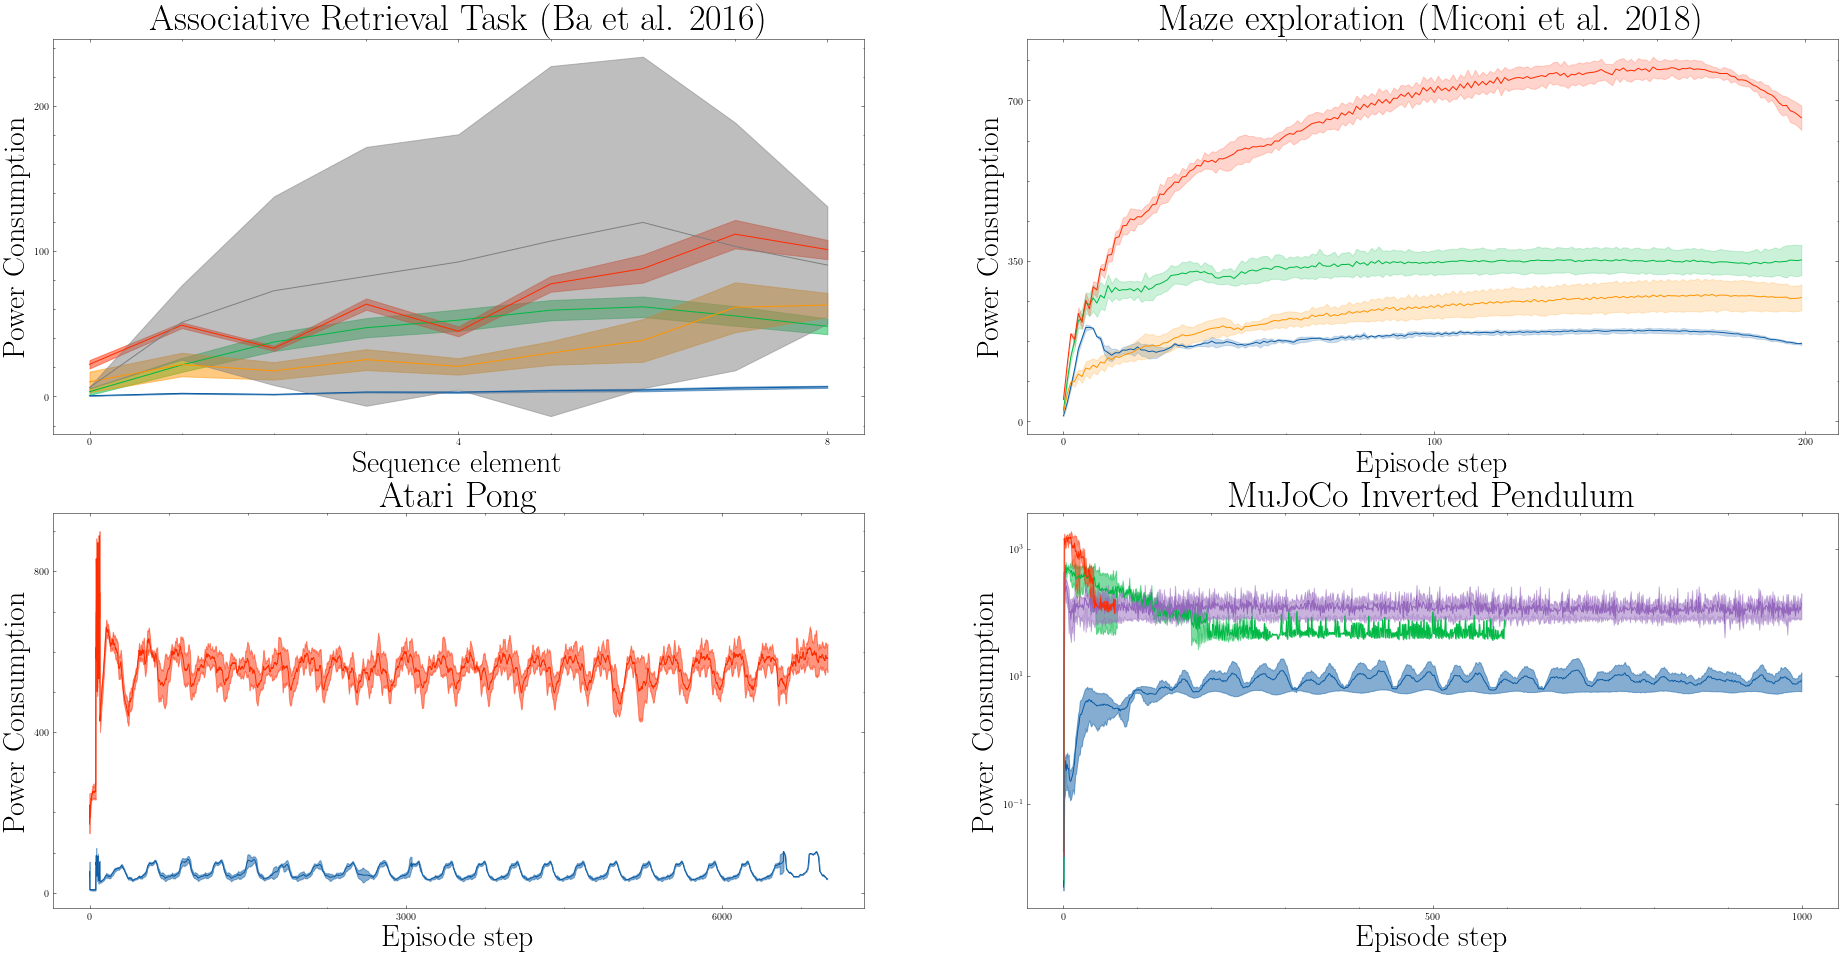

In [45]:
plt.sca(axs_eff[1,1])

max_episodes, last_n_episodes = 100, 100

# (smoothing, max_episode_steps)
# can plot diff configs by adding tuples to the list
plot_configs = [(1, 1000)]
plot_how = 'seeds_join' # ['seeds_separate', 'seeds_join']    
for smoothing, max_episode_steps in plot_configs:
    for exp_name, exp_paths in runs_paths.items():
        color=None
        exp_curve, all_seeds_curve = [], []
        best_seed_val = -np.inf
        for i, seed in enumerate(seeds):
            # mean accros episodes
            this_seed_curve = cat_diff_len(energy_per_episode_step[exp_name][i][0][max_episodes-last_n_episodes:max_episodes])
            if exp_name in global_colors:
                color = global_colors[exp_name]
            else:
                for meta_model, meta_model_color in global_colors.items():
                    if exp_name in meta_model:
                        color = meta_model_color
            if plot_how == 'seeds_separate':
                plt.plot(this_seed_curve, label=f"{exp_name}_{i}", color=color)
            elif plot_how == 'seeds_join':
                all_seeds_curve.append(this_seed_curve)

        if plot_how == 'seeds_join':
            # we want mean accross seeds. However they wont have the same length. Luckily they have the same timesteps
            # we should define our own mean that interporlates until last timestep, then use the only ones still surviving
            # then averages that (acc this step of getting the mean of that is easy)
            joint_curve = cat_diff_len(all_seeds_curve, operator=iqr_operator, operator_kwargs={'axis': 0})
            plt.plot(joint_curve, label=model2label[exp_name], color=color)
            error = cat_diff_len(all_seeds_curve, operator=iqr_operator, operator_kwargs={'axis': 0, 'operation': 'std'})
            xs = np.arange(len(joint_curve))
            plt.fill_between(xs, joint_curve-error, joint_curve+error, alpha=alphas[this_experiment], color=color)
    if eff_vs_prof_legend_subplots == 1 or eff_vs_prof_legend_subplots == 'all':
        plt.legend()
    plt.title(titles[this_experiment])
    plt.ylabel(eff_ylabel, fontsize=fontsize_labels)
    plt.xlabel(eff_xlabel[this_experiment], fontsize=fontsize_labels)
    plt.locator_params(nbins=n_ticks)
    plt.yscale('log')

# Table all energies

In [46]:
# =========================================================== #
# Note: some table elements are added manually, so tables === #
# here do not have all the elements than those in the ======= #
# paper ===================================================== #
# =========================================================== #
# chose efficiency or proficiency table (test accuracy will select reward in RL tasks)
metric = 'Power consumption'  # ['Power consumption', 'Test accuracy']

dataframes = {
    'Associative Retrieval Task (Ba et al.)': df_art_eval,
    'Maze exploration (Miconi et al.)': df_maze_eval,
    'PongNoFrameskip-v4': df_pong_eval,
    'InvertedPendulum-v2': df_pendulum_eval,
}
joint_df, joint_df_cols = [], []
# all_columns = set(dataframes['Associative Retrieval Task (Ba et al.)']['Model'])
modplast_l, stpn_l, fw_l = 'Modplast (Miconi et al.)', "STPN (Ours)", 'Fast Weights (Ba et al.)'
all_columns = {stpn_l, 'LSTM', 'RNN', fw_l, modplast_l, 'MLP'}
model_2_synonym = {"STPN": stpn_l, "STPN (ours)": stpn_l,
                   'Fast Weights': fw_l, 'FW': fw_l,
                   'Modplast': modplast_l, 'Miconi': modplast_l, 'Modulated Plasticity\n(Miconi et al., 2019)': modplast_l}

for exp, df in dataframes.items():
    print('Experiment', exp)
    # only keep energy and model name
    this_columns = set(df['Model']) # models in this experiment
#     print('this_columns', this_columns)
    this_columns = {model_2_synonym.get(m, m) for m in this_columns} # get synonym, otherwise return original value
#     print('this_columns', this_columns)
    missing_columns = set_to_list(all_columns- this_columns)
#     print('missing_columns', missing_columns)
    if len(missing_columns) > 0: # we have some models without result for this experiment, so we need to fill with '-'
        values = ['-' for _ in missing_columns]
        d_missing = {
            'Model': missing_columns,
#             'Power consumption': values,
            metric: values,
        }
#         print('d_missing', d_missing)
        df_missing = pd.DataFrame(d_missing)
#         print('df_missing', df_missing)
#         print('df_new', df_new)
    else:
        df_new = df
#     df_new = df.drop(columns=set(df.columns) - set(['Model', 'Power consumption']))
    df_new = df.drop(columns=set(df.columns) - set(['Model', metric]))
    if len(missing_columns) > 0:
        df_new = pd.concat([df_new, df_missing])
    df_new = df_new.set_index('Model')
    df_new.index = pd.Index([model_2_synonym.get(m, m) for m in df_new.index], name=df_new.index.name)
#     print('--------------')
#     print(df_new)
    dataframes[exp] = df_new
    joint_df.append(df_new)
    joint_df_cols.append(exp)

# print('#'*50)
# print(df_final)
df_final = reduce(lambda left,right: pd.merge(left,right,on='Model'), joint_df)
# this remapping worked with up to 3 columns, with 4 it doesn't, so we relly on order
# mapping_columns = dict(zip(['Power consumption_x','Power consumption_y','Power consumption',], joint_df_cols))
# df_final = df_final.rename(columns= mapping_columns) #
df_final.columns = joint_df_cols

Experiment Associative Retrieval Task (Ba et al.)
Experiment Maze exploration (Miconi et al.)
Experiment PongNoFrameskip-v4
Experiment InvertedPendulum-v2


/tmp/ipykernel_3123396/3824159703.py:59: FutureWarning: Passing 'suffixes' which cause duplicate columns {'Power consumption_x'} in the result is deprecated and will raise a MergeError in a future version.
  df_final = reduce(lambda left,right: pd.merge(left,right,on='Model'), joint_df)


In [47]:
df_art_eval

Model    Test accuracy Power consumption
0      STPN   99.99  +- 0.01     3.44  +- 0.39
1      LSTM   47.28  +- 3.16    65.64  +- 3.40
2       RNN   46.83  +- 5.56    42.99  +- 4.86
3        FW   80.87  +- 1.67   80.60  +- 69.40
4  Modplast  61.49  +- 15.79    32.04  +- 7.36

In [48]:
# Energy consumption 3 experiments, all models
df_final

Associative Retrieval Task (Ba et al.)  \
Model                                                             
STPN (Ours)                                       3.44  +- 0.39   
LSTM                                             65.64  +- 3.40   
RNN                                              42.99  +- 4.86   
Fast Weights (Ba et al.)                        80.60  +- 69.40   
Modplast (Miconi et al.)                         32.04  +- 7.36   
MLP                                                           -   

                         Maze exploration (Miconi et al.) PongNoFrameskip-v4  \
Model                                                                          
STPN (Ours)                               181.08  +- 2.88       52.7  +- 6.4   
LSTM                                     649.14  +- 15.34     576.8  +- 33.5   
RNN                                      330.58  +- 24.29                  -   
Fast Weights (Ba et al.)                                -                  -   
Modplast (Miconi et al.)                 231.58  +- 23.95                  -   
MLP                                                     -                  -   

                         InvertedPendulum-v2  
Model                                         
STPN (Ours)                      7.9  +- 2.5  
LSTM                          758.8  +- 81.7  
RNN                           143.0  +- 22.4  
Fast Weights (Ba et al.)                   -  
Modplast (Miconi et al.)                   -  
MLP                           115.8  +- 33.9

In [49]:
# Test results for all experiments independently
df_maze_eval
df_pong_eval
df_art_eval.set_index('Model')

Test accuracy Power consumption
Model                                      
STPN       99.99  +- 0.01     3.44  +- 0.39
LSTM       47.28  +- 3.16    65.64  +- 3.40
RNN        46.83  +- 5.56    42.99  +- 4.86
FW         80.87  +- 1.67   80.60  +- 69.40
Modplast  61.49  +- 15.79    32.04  +- 7.36

# All plots

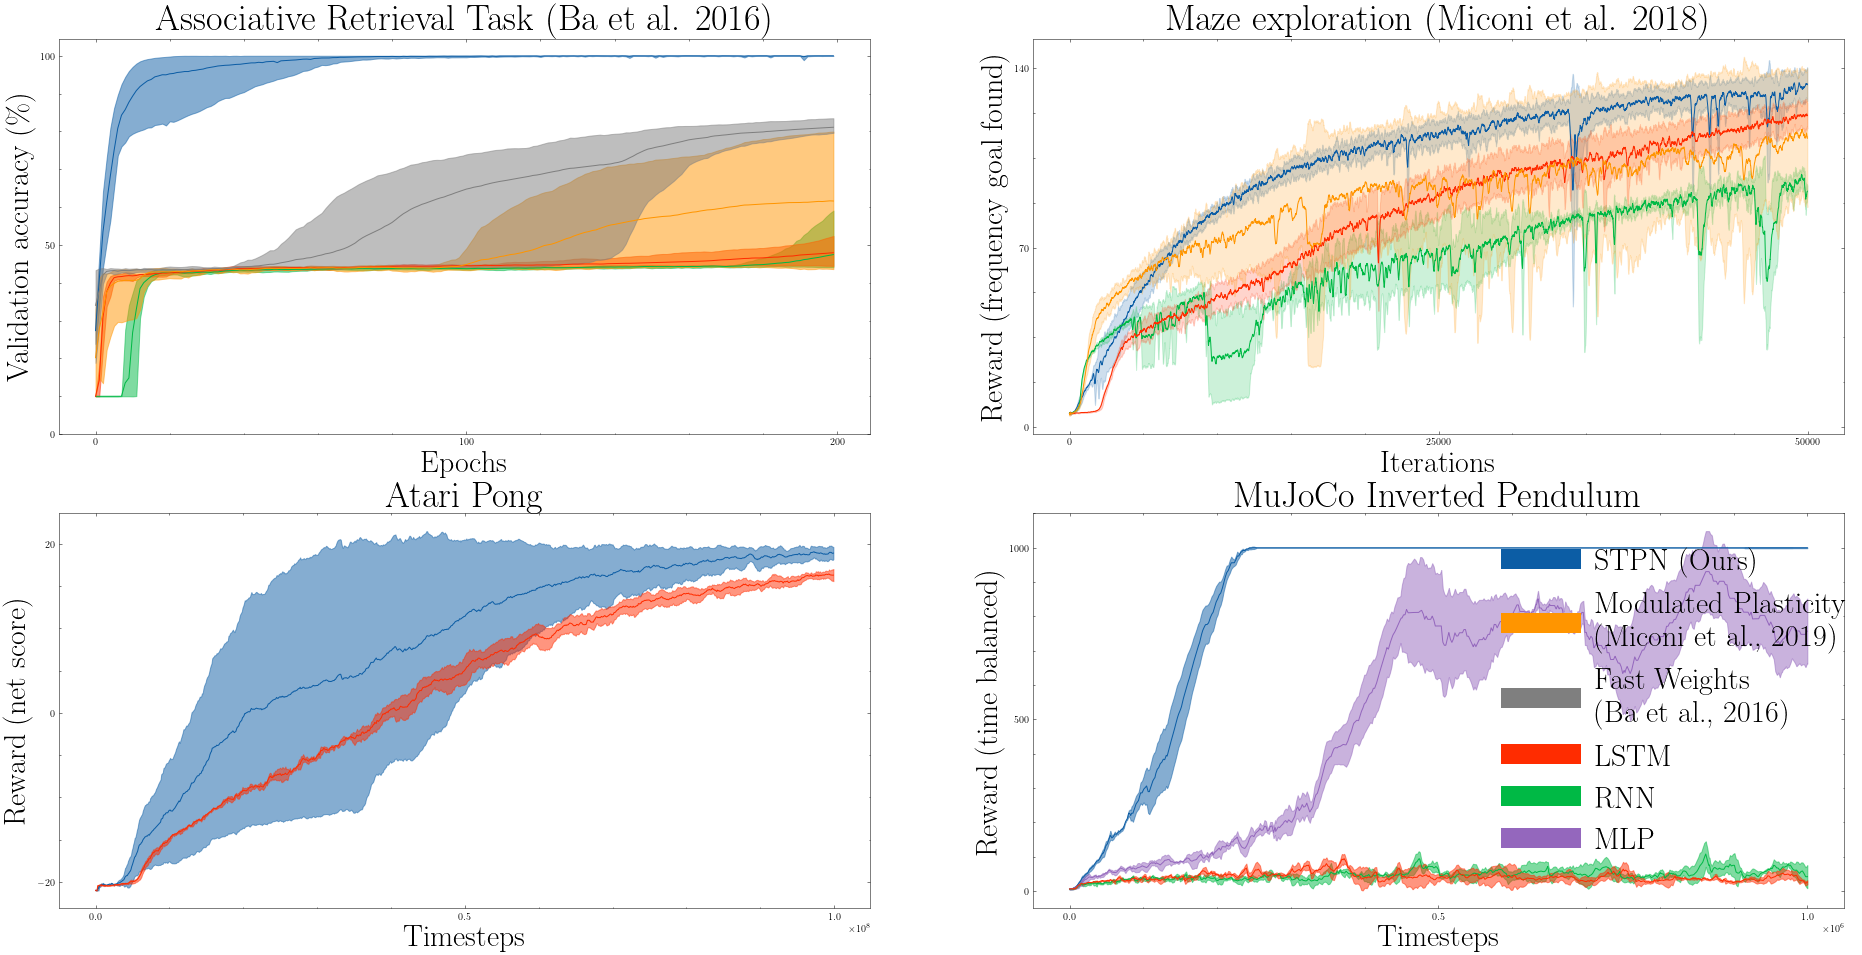

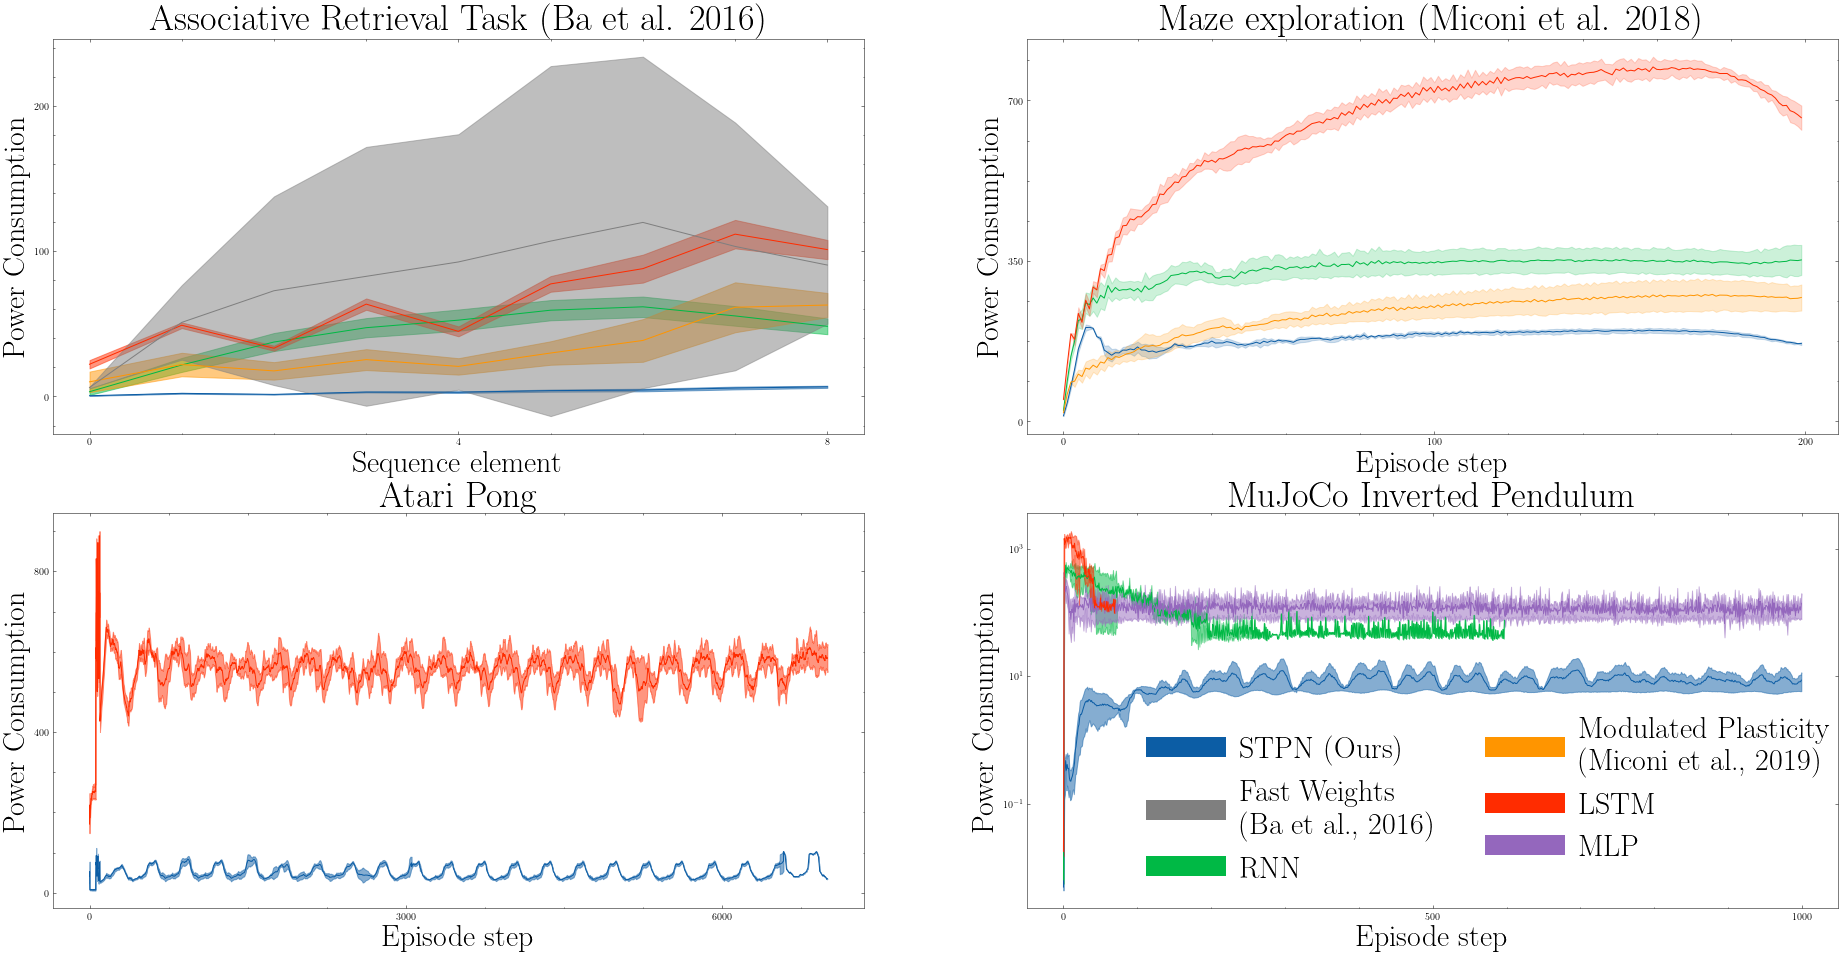

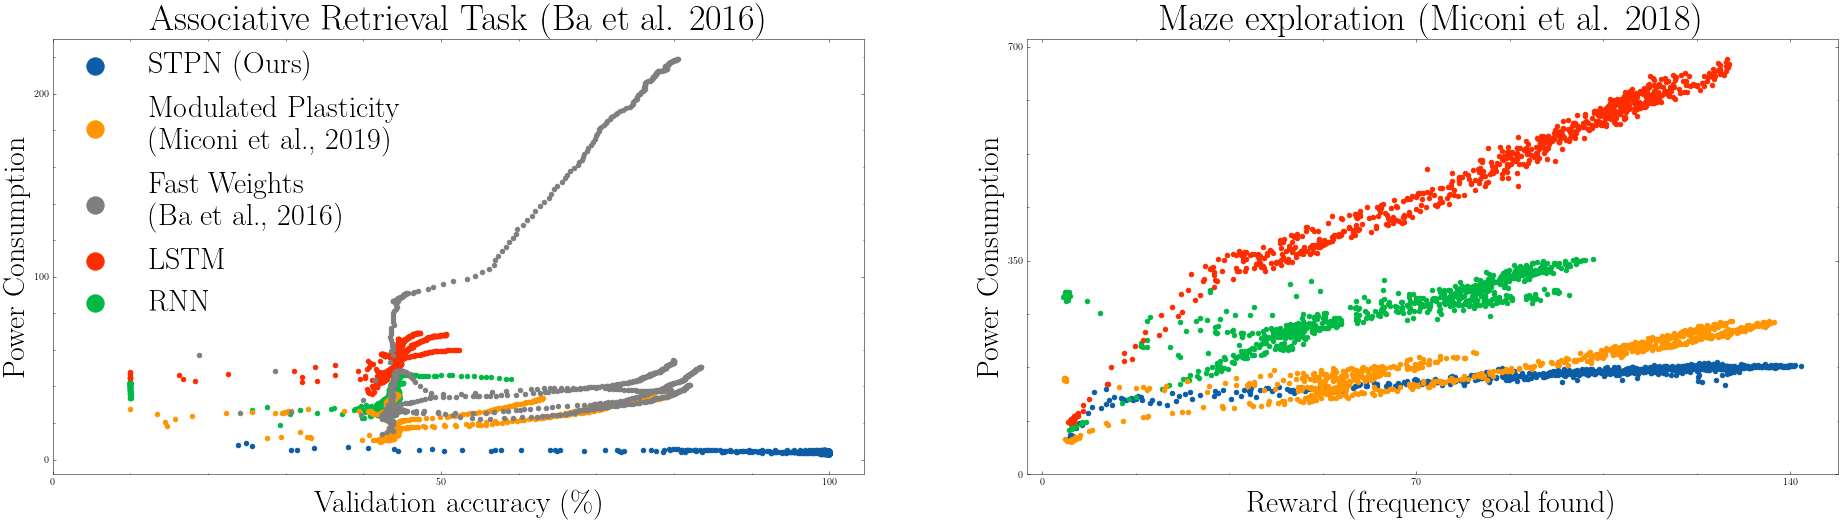

In [50]:
label_sort = [model2label['STPN'], model2label['Modplast'],  model2label['FW'], 
              model2label['LSTM'], model2label['RNN'], model2label['MLP'],]
if prof_legend_subplots == 'joint':
    fig_prof, axs_prof = get_common_labels(fig_prof, axs=axs_prof, axs_loc_for_legend=(1,1),
                                           loc = "center left", bbox_to_anchor=(0.575, 0.525), borderaxespad=0,
                                           legend_line_size=legend_line_size, 
                                           sorted_labels=label_sort,  
                                          )
if eff_legend_subplots == 'joint': #0
    fig_eff, axs_eff = get_common_labels(fig_eff, axs=axs_eff, axs_loc_for_legend=(1,1),
                                         # passing None to all works quite alright with 2 cols, but we can tune it a bit
                                         loc = "center", bbox_to_anchor=(0.575, 0.275), borderaxespad=0,
                                         legend_line_size=legend_line_size, ncol=2,
                                         sorted_labels=np.array(label_sort).reshape(3,2).T.flatten().tolist(),
                                        )
if eff_vs_prof_legend_subplots == 'joint':
    label_sort = [model2label['STPN'], model2label['Modplast'],  model2label['FW'], model2label['LSTM'], model2label['RNN']]
    fig_eff_vs_prof, axs_eff_vs_prof = get_common_labels(fig_eff_vs_prof, axs=axs_eff_vs_prof, axs_loc_for_legend=(0,),
                                                         loc = "upper left", bbox_to_anchor=(0., 1.), borderaxespad=0,
                                                         legend_line_size=None, legend_dot_size=fontsize_to_dot*general_font,
                                                         # ncol=2,
                                                         sorted_labels=label_sort,
                                                        )

In [51]:

fig_prof.subplots_adjust(
    **adjust_4_subplots
)

fig_eff.subplots_adjust(
    **adjust_4_subplots
)

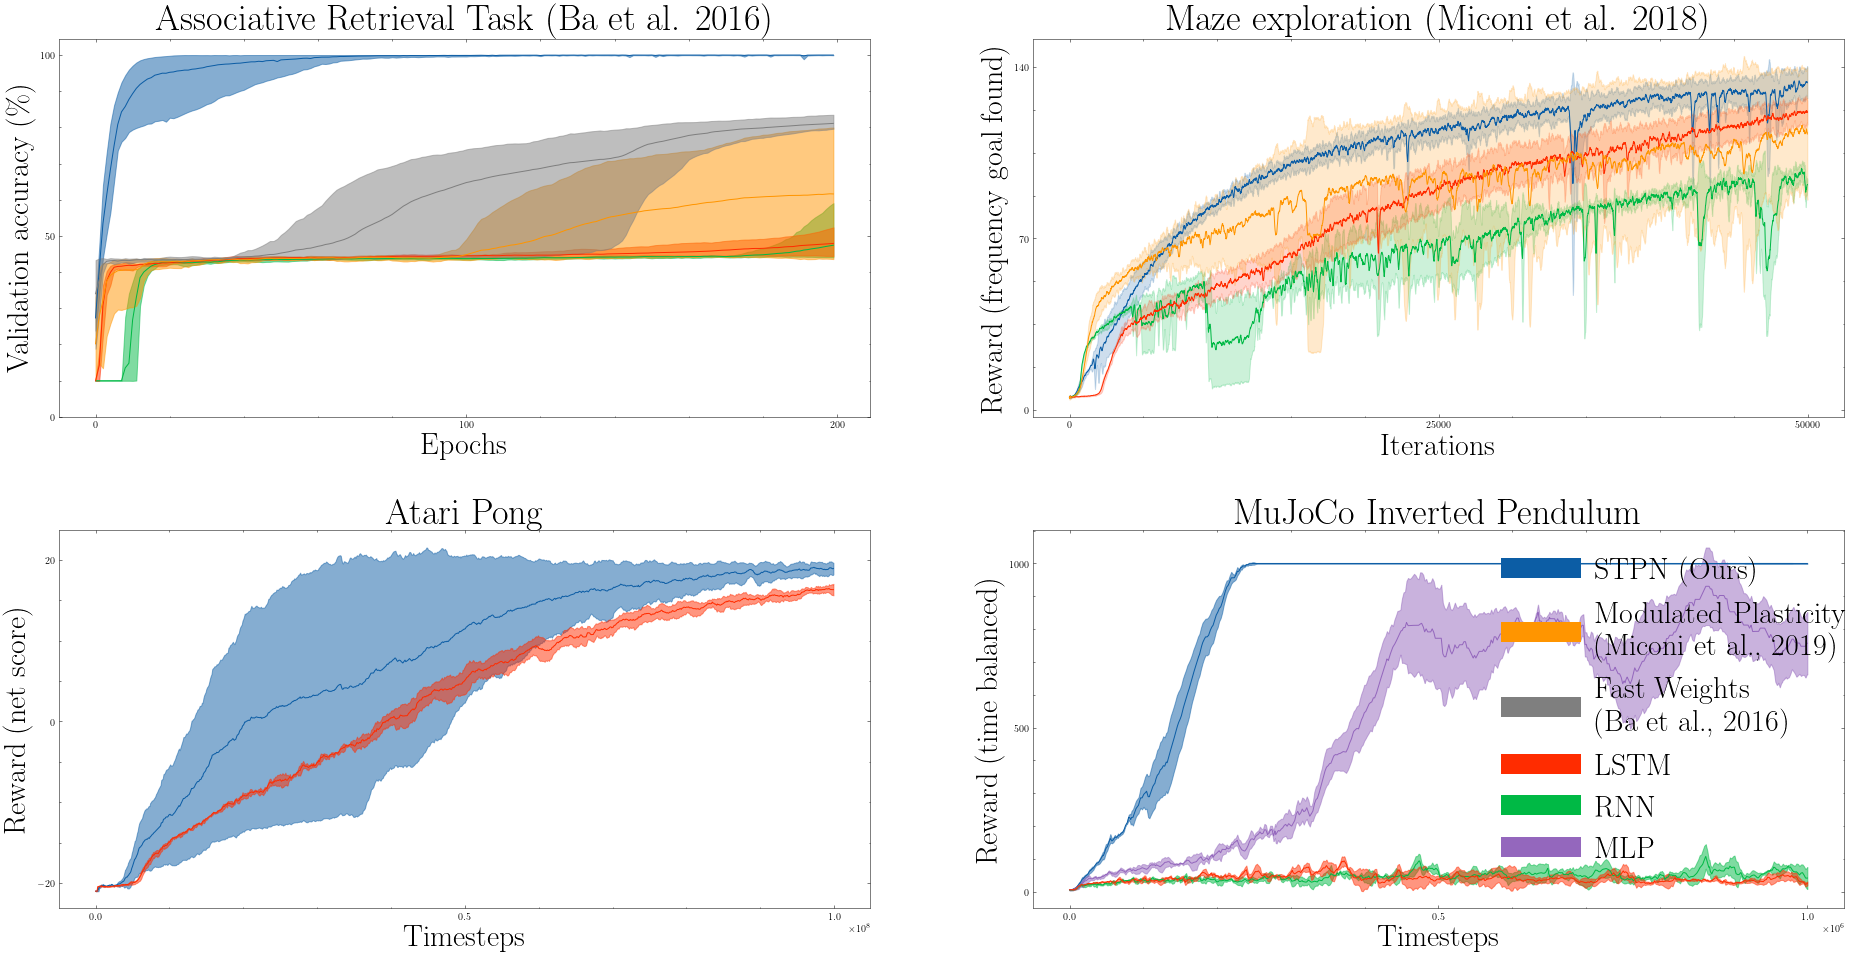

In [52]:
# proficiency: reward or acc vs time during training. ART, Maze, Pong, Pendulum
# fig_prof.savefig("Figures/proficiency.svg", format="svg", bbox_inches="tight")
# fig_prof.savefig("Figures/proficiency.pdf", format="pdf", bbox_inches="tight")
# fig_prof.savefig("Figures/proficiency.png", format="png", bbox_inches="tight")
fig_prof

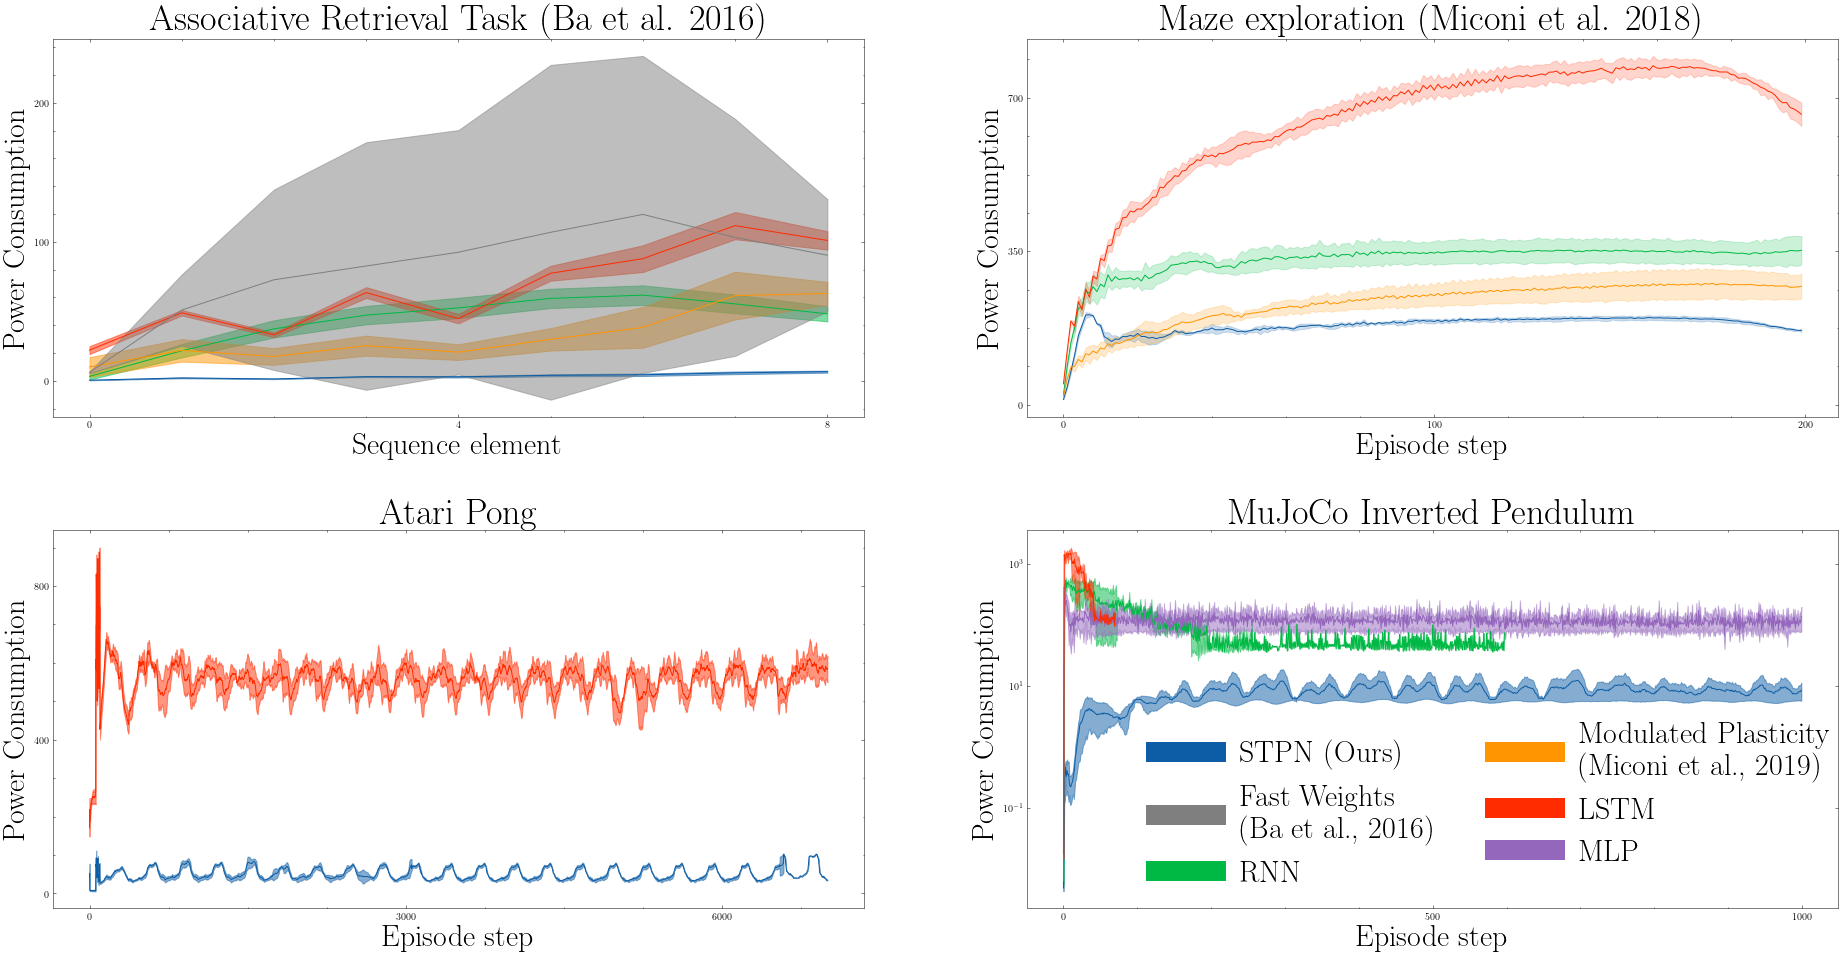

In [53]:
# efficiency: energy vs time during eval. ART, Maze, Pong, Pendulum
# fig_eff.savefig("Figures/efficiency.svg", format="svg", bbox_inches="tight")
# fig_eff.savefig("Figures/efficiency.pdf", format="pdf", bbox_inches="tight")
# fig_eff.savefig("Figures/efficiency.png", format="png", bbox_inches="tight")
fig_eff

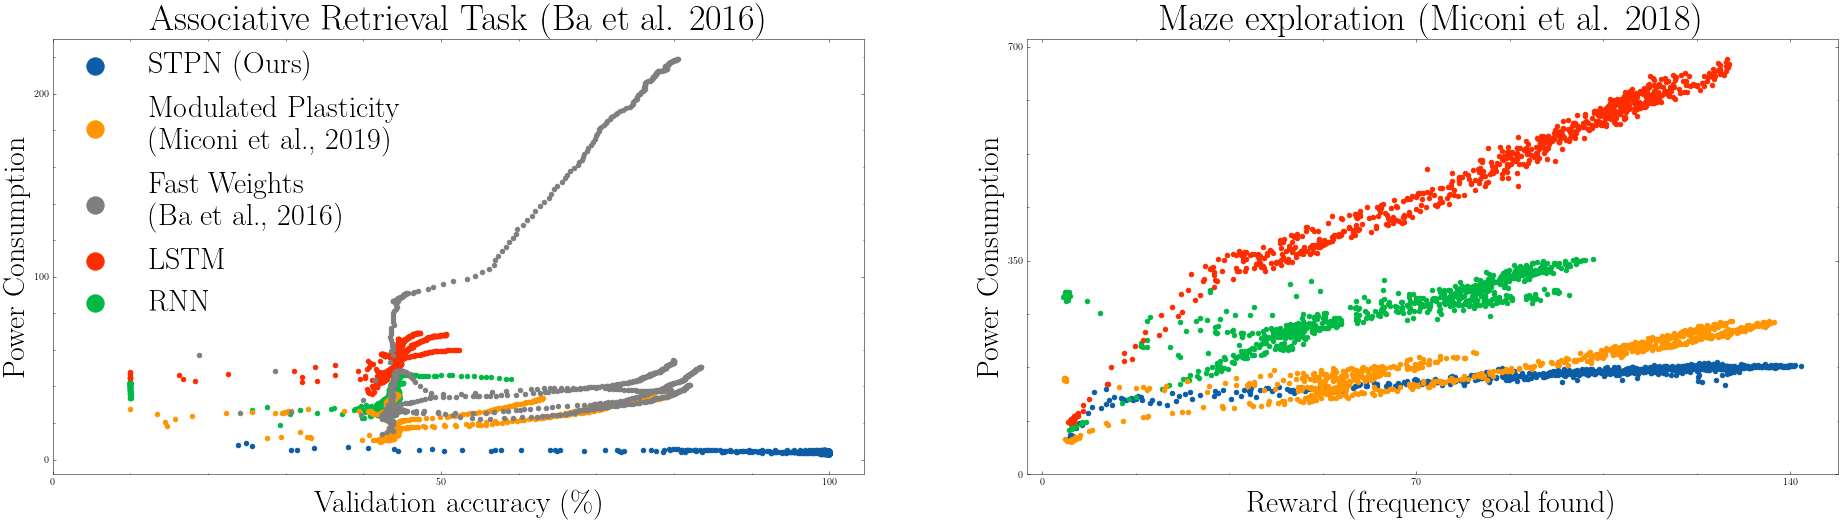

In [54]:
# efficiency vs profficiency: energy vs reward/accuracy during eval. ART & Maze
# fig_eff_vs_prof.savefig("Figures/efficiency_vs_proficiency.svg", format="svg", bbox_inches="tight")
# fig_eff_vs_prof.savefig("Figures/efficiency_vs_proficiency.pdf", format="pdf", bbox_inches="tight")
# fig_eff_vs_prof.savefig("Figures/efficiency_vs_proficiency.png", format="png", bbox_inches="tight")
fig_eff_vs_prof

# Ablation study

(0.0, 1.0, 0.0, 1.0)

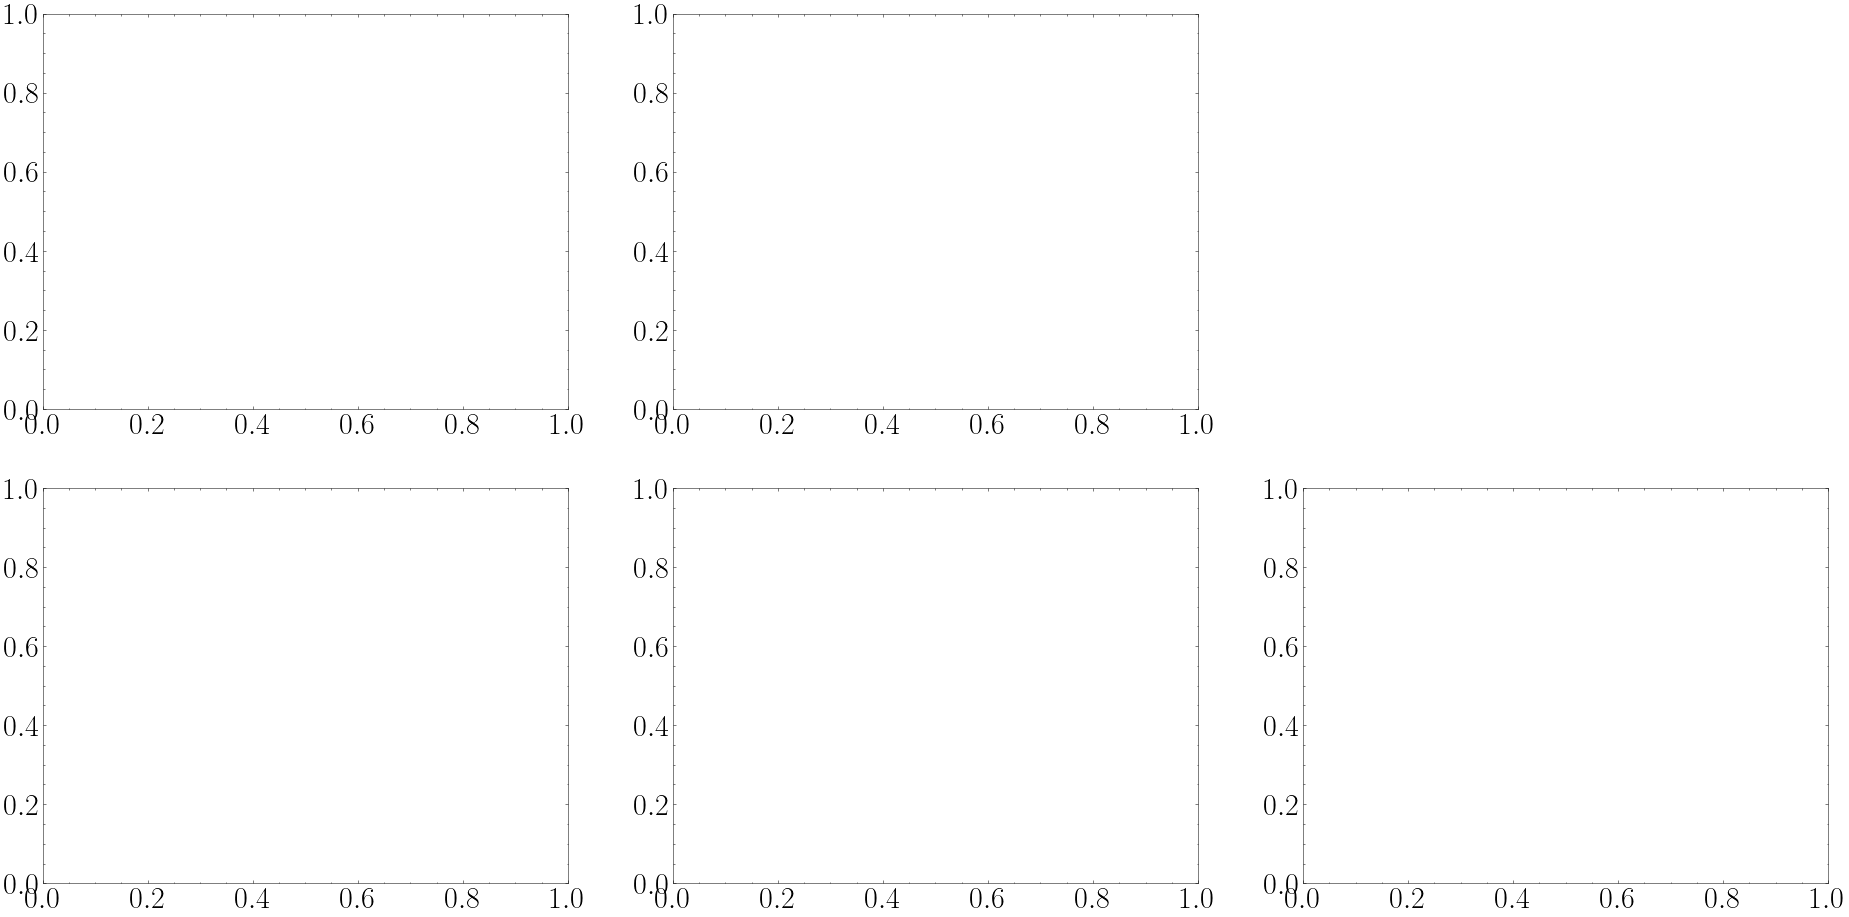

In [55]:
linewidths = {
    "ART": 5.0,
    "Maze": 5.0,
    "CFD": 5.0, # continual familiarity detection task tyulmankov
}


fontsize_labels = 19

legend_line_size = 20.0



adjust_6_subplots = {'hspace': 0.3}

# fig_prof, axs_prof = plt.subplots(nrows=2,ncols=2, figsize=(32,16))
# fig_eff, axs_eff = plt.subplots(nrows=2,ncols=2, figsize=(32,16))

fig_abl, axs_abl = plt.subplots(nrows=2,ncols=3, figsize=(32,16))
# set the empty subplot off
axs_abl[0, 2].axis('off')

## Associative Retrieval Task

In [56]:
this_experiment = 'ART'

In [57]:
############################
# Load all ART #############
############################

# all subpaths for ART
path_results = os.path.join(base_path, 'AssociativeRetrievalTask')
path_results_proficiency = os.path.join(path_results, 'proficiency/')
path_results_efficiency = os.path.join(path_results, 'efficiency/')
path_models = os.path.join(path_results, 'trained-models/')

# config filenames (without the starting ART_) and short name that keys all other config dictionaries
experiments = {    
    "STPN_h11": {"short": "STPNr"},
    "STPNf_h13": {"short": "STPNf"},
    "STPN_scalarSTP_h20": {"short": "uSTPNr"},
    "STPNf_scalarSTP_h26": {"short": 'uSTPNf'},
    "HebbFF_h26": {"short": 'HebbFF'},
}

# seeds run
seeds = global_seeds_ablation[this_experiment]

# instantiate storing structures
energies, val_energies = {}, {}
mean_energies, accuracies, xlabels, all_mean_fixed = [], [], [], []
mean_energies_std, accuracies_std = [], []
val_accuracies_std, val_accuracies_mean, val_accuracies = [], [], {}

for model_name, model_cfg in experiments.items():
    model_mean_energies, model_accuracies,  model_all_mean_fixed = [], [], []
    model_val_accuracies = []
    val_accuracies[model_name] = {}
    print("#"*50)
    print(model_name)
    energies[model_name], val_energies[model_name] = {}, {}
    for seed in seeds:
        print('Seed', seed)
        # ============== test accuracy ============================
        filename = f"ART_from_ART_{model_name}_seed_{seed}"
        accuracy = read_single_result(filename="test_"+filename+'.txt', base=path_results_proficiency)[-1]
        model_accuracies.append(accuracy)
        print("Test accuracy", accuracy)
        
        # ============== validation accuracy curves  ==============
        accuracy = read_acc_results_file(filename="val_"+filename+'.txt',base=path_results_proficiency, separator=",")[-1]
        val_accuracies[model_name][seed] = accuracy 
        model_val_accuracies.append(accuracy)
        print("Validation accuracy", accuracy)
        
        # ============= test energy ======================
        energies[model_name][seed] = load_energy_results_art("test_"+filename, model_name, path_results_efficiency, {})[model_name]
        # num_seqs, seq_len; already summed per hidden unit
        mean_energy = torch.mean(input=torch.Tensor(energies[model_name][seed]), dim=(0,1)) 
        model_mean_energies.append(mean_energy)
        print("Test mean_energy", mean_energy)
        
        # we do not use validation energy during training in ablation study
#         # ============= validation energy during training ======================
#         val_energies[model_name][seed] = load_energy_results_art('val_' + filename, model_name, path_results_efficiency, {})[model_name]
#         print("Validation mean_energy", mean_energy)
    # append summary statistics 
    mean_energies.append(np.mean(model_mean_energies))  # average over seed and sequence
    mean_energies_std.append(np.std(model_mean_energies)) # std over seed and sequence
    accuracies.append(np.mean(model_accuracies)) # average over seed
    accuracies_std.append(np.std(model_accuracies)) # std over seed
    val_accuracies_mean.append(np.mean(model_accuracies, axis=0)) # average over seed, but keep sequence
    val_accuracies_std.append(np.std(model_accuracies, axis=0))  # std over seed, but keep sequence
    # store labels in order
    xlabels.append(experiments[model_name]['short'])
# cast to arrays
mean_energies = np.array(mean_energies)
mean_energies_std = np.array(mean_energies_std)
accuracies_mean = np.array(accuracies)
accuracies_std = np.array(accuracies_std)
val_accuracies_mean = np.array(val_accuracies_mean)
val_accuracies_std = np.array(val_accuracies_std)
xlabels = np.array(xlabels)
xlabels

########################
# Make table ========= #
########################

accuracies_for_df = []
energies_for_df = []
acc_decimals = 2
energy_decimals = 2
for i_model, model_name in enumerate(xlabels):
    accuracies_for_df.append(f"{100*accuracies_mean[i_model]:.{acc_decimals}f}  +- {100*accuracies_std[i_model]:.{acc_decimals}f}")
    energies_for_df.append(f"{mean_energies[i_model]:.{energy_decimals}f}  +- {mean_energies_std[i_model]:.{energy_decimals}f}")
accuracies_for_df = np.array(accuracies_for_df, dtype=object)
energies_for_df = np.array(energies_for_df, dtype=object)
    
data = np.array([np.array(xlabels).T, accuracies_for_df.T, energies_for_df.T], dtype=object)

print(data)
print("Experiment result matrix shape", data.shape)
df_ablation_art_eval = pd.DataFrame(data.T, columns=['Model', 'Test accuracy', 'Power consumption'])

##################################################
STPN_h11
Seed 0
Test accuracy 1.0
Validation accuracy [0.3073, 0.4448, 0.577, 0.6528, 0.7106, 0.777, 0.8289, 0.8732, 0.8643, 0.8806, 0.9078, 0.9295, 0.9465, 0.9581, 0.9652, 0.973, 0.9862, 0.9889, 0.9953, 0.9968, 0.9979, 0.9989, 0.9993, 0.9996, 0.9999, 0.9998, 0.9999, 0.9999, 0.9997, 0.9997, 0.9998, 0.9995, 1.0, 0.9998, 0.9998, 1.0, 0.9992, 0.9999, 1.0, 0.9974, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9925, 1.0, 1.0, 1.0, 0.9782, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9925, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9973, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9982, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9989, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9969, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 

In [58]:
# store for later
ablation_art_eval_energies = energies

In [59]:
df_ablation_art_eval

Model   Test accuracy Power consumption
0   STPNr  99.99  +- 0.01     3.44  +- 0.39
1   STPNf  89.40  +- 5.14     1.24  +- 0.07
2  uSTPNr  96.89  +- 6.21     4.01  +- 0.34
3  uSTPNf  60.21  +- 0.52     2.59  +- 0.08
4  HebbFF  10.62  +- 0.02     7.87  +- 1.83

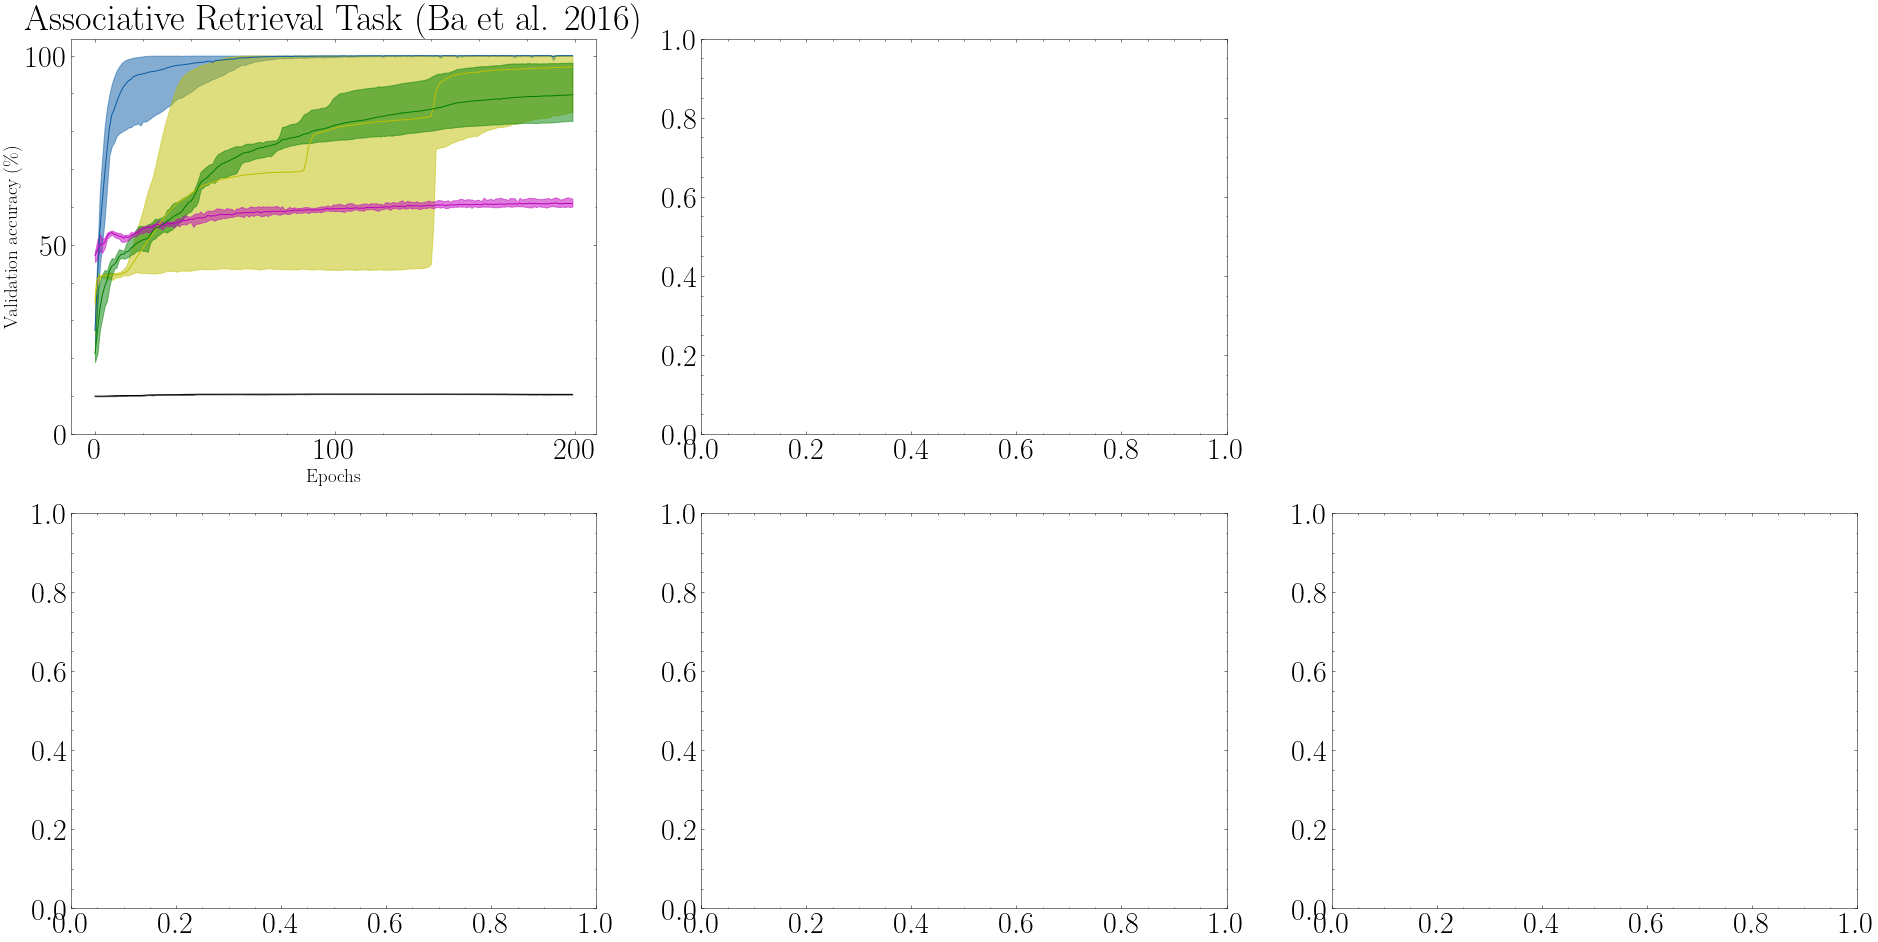

In [60]:
# ================================================================== #
# == Vectorise results across models and seeds for plotting ======== #
# ================================================================== #

if default_aspect_ratio is False:
    plt.figure(figsize=(16, 8), dpi=80)


# 200 training iterations
labels = []
last_n_iters = 200
max_iters = 200 #4000 #5000
my_xticks = np.arange((max_iters-last_n_iters)*1,max_iters*1+1,50)
x_my_ticks = my_xticks
x = np.arange(max_iters-last_n_iters,max_iters)
mean_rewards, std_rewards = [], []
max_rewards, min_rewards = [], []

rewards = val_accuracies

plt.sca(axs_abl[0,0])

for exp_name, exp_cfg in experiments.items():
    rewards_seeds = []
    for seed in seeds:
        # expand dim for seeds
        try:
            this_seed_rewards = np.expand_dims(np.array(rewards[exp_name][seed][max_iters-last_n_iters:max_iters]), 0)
        except:
            ipdb.set_trace()
        rewards_seeds.append(this_seed_rewards)
    # concatenate seeds
    try:
        rewards_seeds = np.concatenate(rewards_seeds, axis=0)
    except:
        ipdb.set_trace()
    
    # mean and std over seeds
    this_mean_rewards = np.mean(rewards_seeds, axis=0)
    this_std_rewards = np.std(rewards_seeds, axis=0)
    this_max_rewards, this_min_rewards = np.max(rewards_seeds, axis=0), np.min(rewards_seeds, axis=0) 
    # append to all models' results
    mean_rewards.append(this_mean_rewards)
    std_rewards.append(this_std_rewards)
    max_rewards.append(this_max_rewards)
    min_rewards.append(this_min_rewards)
    labels.append(model2label[exp_cfg['short']])
    
mean_rewards, std_rewads = np.array(mean_rewards), np.array(std_rewards)
max_rewards, min_rewads = np.array(max_rewards), np.array(min_rewards)



# ================================================================== #
# == Plot results ================================================== #
# ================================================================== #
accuracies, accuracies_std = mean_rewards, np.array(std_rewards)
min_accuracies, max_accuracies = np.array(min_rewards), np.array(max_rewards) # min_rewards, max_rewards
ids_meta_model = {}
rescale = lambda y, min_scale: (y - np.min(y)*min_scale) / (np.max(y) - np.min(y)*min_scale)
meta_models = [
    'STPNr per-synapse STP (Ours)',
    'STPNr uniform STP (Ours)',
    'STPNf per-synapse STP (Ours)',
    'STPNf uniform STP (Ours)',
    'HebbFF'
]
seq_cmaps = [
    plt.cm.Blues,
    plt.cm.Reds,
    plt.cm.Oranges,
    plt.cm.Greens,
    plt.cm.Greys
]
for i_meta_model, meta_model in enumerate(meta_models):
    ids_meta_model[meta_model] = np.array([meta_model in xlabel for xlabel in labels])
    if ids_meta_model[meta_model].sum() == 0:
        continue
    else:
        this_colors = seq_cmaps[i_meta_model](rescale(accuracies[ids_meta_model[meta_model]][:,-1], min_scale=0.75))
        for i_sub_model in range(this_colors.shape[0]):
            if meta_model not in global_colors:
                ipdb.set_trace()
                global_colors[meta_model] = this_colors[i_sub_model]
            plot.plot(
                x,
                accuracies[ids_meta_model[meta_model]][i_sub_model],
                color=global_colors[meta_model], #this_colors[i_sub_model],
                label= np.array(labels)[ids_meta_model[meta_model]][i_sub_model]
            )
            plot.fill_between(
                x,
                min_accuracies[ids_meta_model[meta_model]][i_sub_model],
                max_accuracies[ids_meta_model[meta_model]][i_sub_model],
                alpha=alphas[this_experiment],#0.2,
                color=global_colors[meta_model], #this_colors[i_sub_model]
            )
    
##########################################################
##########################################################

if plot_subplots is True:
    plt.title(titles[this_experiment])
    plt.ylabel(prof_ylabel[this_experiment], fontsize=fontsize_labels)
    plt.xlabel(prof_xlabel[this_experiment], fontsize=fontsize_labels)
    plt.xticks(x_my_ticks, my_xticks)
    plt.locator_params(nbins=n_ticks)
    plt.yticks(np.linspace(0,1,n_ticks), np.linspace(0,100,n_ticks, dtype=int))
    if prof_legend_subplots == 0 or prof_legend_subplots == 'all':
        plt.legend()
else:
    plt.title(f'Maze exploration reward during last {last_n_iters} episodes of training')
    plt.title(f'Associative Retrieval Task validation accuracy during training')
    plt.ylabel('Accuracy')
    plt.xlabel('Epochs')
    plt.legend()
    plt.xticks(x_my_ticks, my_xticks)
    plt.show()

## Maze

In [61]:
this_experiment = 'Maze'

In [62]:
plot_shaded = 'std' # [ False, 'std', 'min_max']
plot_line = 'mean' # [ 'mean', 'median']

In [63]:
path_results = os.path.join(base_path, 'Maze/')

secondary_base_path = {
    'reward': 'logs',
    'energy': 'efficiency',
    'model': 'logs',
}
filename_prefix = {
    'reward': 'loss',
    'energy': 'energy',
    'model': 'torchmodel'
}
train_experiment_suffix = {
    "uSTPNr": {"net_type": "stpn", "type": "stpn", "config": "STPN_Maze_scalarSTP_h55", 'nbiter': 50000, 'hs': 55},
    "STPNr": {"net_type": "stpn", "type": "stpn", "config": "STPN_Maze_h30", 'nbiter': 50000, 'hs': 30},
    "uSTPNf": {"net_type": "stpn", "type": "stplinear", "config": "STPNf_Maze_scalarSTP_h181", 'nbiter': 50000, 'hs': 181},
    "STPNf": {"net_type": "stpn", "type": "stplinear", "config": "STPNf_Maze_h76", 'nbiter': 50000, 'hs': 76},
#     "HebbFF": {"net_type": "stpn", "type": "hebbff", "config": "HebbFF_Maze_h181", 'nbiter': 50000, 'hs': 181},
}
experiment_suffix = copy.deepcopy(train_experiment_suffix)
file_format = {
    'reward': '.txt',
    'energy': '.npy',
    'model': '.dat'
}

labels = []
seeds = global_seeds_ablation[this_experiment]
n_moving_average = 10 # smooth, as we only store every 10 so very spiky

rewards, energies = {}, {}
for exp_name, exp_config in experiment_suffix.items():
    # init exp for diff seeds
    labels.append(exp_name)
    rewards[exp_name], energies[exp_name] = {}, {}
    for seed in seeds:
        exp_config['rngseed'] = seed
        path_to_reward_file = get_path_results('reward',path_results, secondary_base_path, filename_prefix, 
                                               file_format, exp_config)
        with open(path_to_reward_file) as f:
            loss = f.read()
            rewards[exp_name][seed] = np.array([float(i_loss) for i_loss in loss.split()])
            if n_moving_average is not False:
                rewards[exp_name][seed] = moving_average(rewards[exp_name][seed], n_moving_average)
        path_to_energy_file = get_path_results('energy', path_results, secondary_base_path, filename_prefix,
                                               file_format, exp_config)
        energies[exp_name][seed] = np.load(str(path_to_energy_file))
maze_train_energies = energies
maze_train_rewards = rewards

In [64]:
# delete later
# for m, m_s in maze_train_rewards.items():
#     for s, m_s_r in m_s.items():
#         print(m, s, m_s_r.shape)

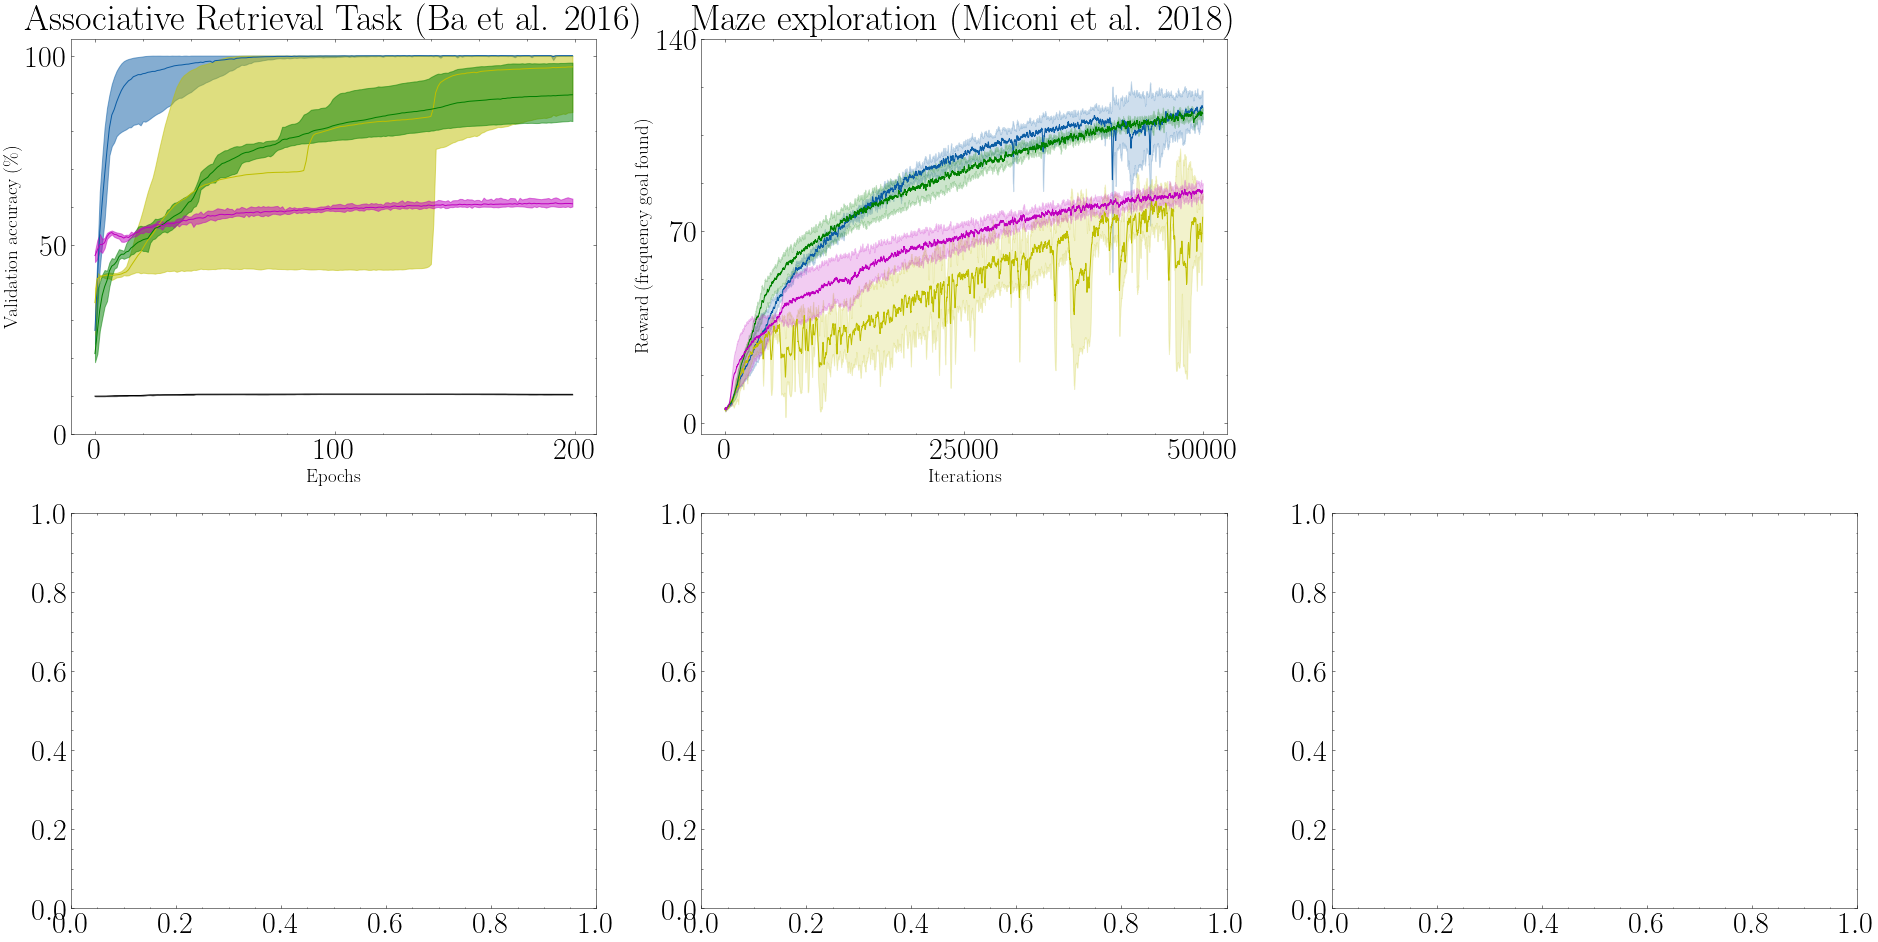

In [65]:
if default_aspect_ratio is False:
    plt.figure(figsize=(16, 8), dpi=80)
    
# plt.sca(axs_prof[0, 1])
plt.sca(axs_abl[0,1])


labels = []
last_n_iters = 5000 
max_iters = 5000
ratio_tick_to_label = 10
my_xticks = np.arange(10*(max_iters-last_n_iters),10*max_iters+1,10000)
x_my_ticks = np.arange(max_iters-last_n_iters,max_iters+1, 1000)
x = np.arange(max_iters-last_n_iters,max_iters)
mean_rewards, std_rewards = [], []
max_rewards, min_rewards = [], []

for exp_name, _ in experiment_suffix.items():
    rewards_seeds = []
    for seed in seeds:
        try:
            this_seed_rewards = np.expand_dims(np.array(rewards[exp_name][seed][max_iters-last_n_iters:max_iters]), 0)
        except:
            print('failed loading of reward for this exp name and seed')
            ipdb.set_trace()
        rewards_seeds.append(this_seed_rewards)    
    try:
        rewards_seeds = np.concatenate(rewards_seeds, axis=0)
    except:
        print('failed concatenation of rewards for all seeds in this exp_name')
        ipdb.set_trace()
    # mean and std over seeds
    if plot_line == 'mean': # [ 'mean', 'median']
        this_mean_rewards = np.mean(rewards_seeds, axis=0)
    elif plot_line == 'median': # [ 'mean', 'median']
        this_mean_rewards = np.median(rewards_seeds, axis=0)
    this_std_rewards = np.std(rewards_seeds, axis=0)
    this_max_rewards, this_min_rewards = np.max(rewards_seeds, axis=0), np.min(rewards_seeds, axis=0) 
    # store results
    mean_rewards.append(this_mean_rewards)
    std_rewards.append(this_std_rewards)
    max_rewards.append(this_max_rewards)
    min_rewards.append(this_min_rewards)
    labels.append(model2label[exp_name])
# ensure cast to np.array
mean_rewards, std_rewads = np.array(mean_rewards), np.array(std_rewards)
max_rewards, min_rewads = np.array(max_rewards), np.array(min_rewards)

###########################################################
###########################################################
accuracies, accuracies_std = mean_rewards, np.array(std_rewards)
min_accuracies, max_accuracies = np.array(min_rewards), np.array(max_rewards)
ids_meta_model = {}
rescale = lambda y, min_scale: (y - np.min(y)*min_scale) / (np.max(y) - np.min(y)*min_scale)
meta_models = [
    'STPNr per-synapse STP (Ours)',
    'STPNr uniform STP (Ours)',
    'STPNf per-synapse STP (Ours)',
    'STPNf uniform STP (Ours)',
    'HebbFF'
]
seq_cmaps = [plt.cm.Blues, plt.cm.Reds, plt.cm.Oranges, plt.cm.Greens, plt.cm.Greys]
for i_meta_model, meta_model in enumerate(meta_models):
    ids_meta_model[meta_model] = np.array([meta_model in xlabel for xlabel in labels])
    if ids_meta_model[meta_model].sum() == 0:
        continue
    else:
#         import pdb
#         pdb.set_trace()
#         this_colors = seq_cmaps[i_meta_model](rescale(accuracies[ids_meta_model[meta_model]][:,-1], min_scale=0.95))
        for i_sub_model in range(this_colors.shape[0]):
#             if meta_model not in global_colors:
#                 global_colors[meta_model] = this_colors[i_sub_model]
            plt.plot(
                x,
                accuracies[ids_meta_model[meta_model]][i_sub_model],
                color=global_colors[meta_model],
                label= np.array(labels)[ids_meta_model[meta_model]][i_sub_model]
            )
            if plot_shaded is not False:
                if plot_shaded == 'std': # [ False, 'std', 'min_max']
                    bot_err = accuracies[ids_meta_model[meta_model]][i_sub_model] - accuracies_std[ids_meta_model[meta_model]][i_sub_model]
                    top_err = accuracies[ids_meta_model[meta_model]][i_sub_model] + accuracies_std[ids_meta_model[meta_model]][i_sub_model]
                elif plot_shaded == 'min_max':
                    bot_err = min_accuracies[ids_meta_model[meta_model]][i_sub_model]
                    top_err = max_accuracies[ids_meta_model[meta_model]][i_sub_model]
                else:
                    raise NotImplementedError
                plt.fill_between(
                    x,
                    bot_err,
                    top_err,
                    alpha=alphas[this_experiment],
                    color=global_colors[meta_model],
                )
                
##########################################################
##########################################################
plt.title(titles[this_experiment])
plt.ylabel(prof_ylabel[this_experiment], fontsize=fontsize_labels)
plt.xlabel(prof_xlabel[this_experiment], fontsize=fontsize_labels)
if prof_legend_subplots == 1 or prof_legend_subplots == 'all':
    plt.legend()

if equally_spaced_ticks:
    x_my_ticks = np.linspace(x_my_ticks[0], x_my_ticks[-1], n_ticks, dtype=int)
    my_xticks = ratio_tick_to_label * x_my_ticks
    
    yticks = np.linspace(0, 140, n_ticks, dtype=int)
    ylabels = yticks
    plt.xticks(x_my_ticks, my_xticks)
    plt.yticks(yticks, ylabels)
else:
    plt.xticks(x_my_ticks, my_xticks)
    plt.locator_params(nbins=n_ticks)


plt.show()

In [66]:
# energy table during eval!
eval_experiment_suffix = {
    "STPNr": {'eval': True, 'nbiter': 100, "net_type": "stpn", "type": "stpn", "config": "STPN_Maze_h30", 'hs': 30},
    "STPNf": {'eval': True, 'nbiter': 100, "net_type": "stpn", "type": "stplinear", "config": "STPNf_Maze_h76", 'hs': 76},    
    "uSTPNr": {'eval': True, 'nbiter': 100, "net_type": "stpn", "type": "stpn", "config": "STPN_Maze_scalarSTP_h55", 'hs': 55},
    "uSTPNf": {'eval': True, 'nbiter': 100, "net_type": "stpn", "type": "stplinear", "config": "STPNf_Maze_scalarSTP_h181", 'hs': 181},
#     "HebbFF": {'eval': True, 'nbiter': 100, "net_type": "stpn", "type": "hebbff", "config": "HebbFF_Maze_h181", 'hs': 181},
}
experiment_suffix = copy.deepcopy(eval_experiment_suffix)

labels = []
seeds = global_seeds_ablation_eval[this_experiment]
n_moving_average = 10
rewards, energies = {}, {}
for exp_name, exp_config in experiment_suffix.items():
    # init exp for diff seeds
    labels.append(exp_name)
    rewards[exp_name], energies[exp_name] = {}, {}
    for seed in seeds:
        exp_config['rngseed'] = seed
        path_to_reward_file = get_path_results('reward', path_results,secondary_base_path, filename_prefix,
                                               file_format, exp_config)
        with open(path_to_reward_file) as f:
            loss = f.read()
            rewards[exp_name][seed] = np.array([float(i_loss) for i_loss in loss.split()])
            if n_moving_average is not False:
                rewards[exp_name][seed] = moving_average(rewards[exp_name][seed], n_moving_average)
        path_to_energy_file = get_path_results('energy', path_results, secondary_base_path, filename_prefix,
                                               file_format, exp_config)
        energies[exp_name][seed] = np.load(str(path_to_energy_file))
        
maze_eval_energies = energies
maze_eval_rewards = rewards
###################################
###################################
x = np.arange(len(energies))
labels = []
# 100 episode steps
last_n_iters = 100
max_iters = 100
mean_energies, std_energies = [], []

mean_rewards, std_rewards = [], []
max_rewards, min_rewards = [], []
for exp_name, exp_cfg in experiment_suffix.items():
    rewards_seeds, energies_seeds = [], []
    for seed in seeds:
        # expand dim for seeds
        this_seed_energies = np.expand_dims(np.array(energies[exp_name][seed][max_iters-last_n_iters:max_iters]), 0)
        this_seed_energies = this_seed_energies * exp_cfg.get('hs', 100)  * exp_cfg.get('gates', 1) 
        energies_seeds.append(this_seed_energies)
        this_seed_rewards = np.expand_dims(np.array(rewards[exp_name][seed][max_iters-last_n_iters:max_iters]), 0)
        rewards_seeds.append(this_seed_rewards)
    energies_seeds = np.concatenate(energies_seeds, axis=0)
    rewards_seeds = np.concatenate(rewards_seeds, axis=0)
    # average or sum iters and episode steps, before mean,std of seeds
    energies_seeds = np.mean(energies_seeds, axis=(1,2)) # seeds, iters, ep step
    rewards_seeds = np.mean(rewards_seeds, axis=(0)) # mean across seeds, iters # not mean across steps ? 
    
    # mean and std over seeds
    this_mean_energies = np.mean(energies_seeds, axis=0)
    this_std_energies = np.std(energies_seeds, axis=0)
    this_mean_rewards = np.mean(rewards_seeds, axis=(0))
    this_std_rewards = np.std(rewards_seeds, axis=0)
    this_max_rewards, this_min_rewards = np.max(rewards_seeds, axis=0), np.min(rewards_seeds, axis=0) 

    mean_energies.append(this_mean_energies)
    std_energies.append(this_std_energies)
    mean_rewards.append(this_mean_rewards)
    std_rewards.append(this_std_rewards)
    max_rewards.append(this_max_rewards)
    min_rewards.append(this_min_rewards)
    labels.append(model2label[exp_name])    
mean_energies, std_energies = np.array(mean_energies), np.array(std_energies)
mean_rewards, std_rewads = np.array(mean_rewards), np.array(std_rewards)
max_rewards, min_rewads = np.array(max_rewards), np.array(min_rewards)

In [67]:
xlabels = labels
mean_energies_std = std_energies
accuracies_mean, accuracies_std = mean_rewards, std_rewads

accuracies_for_df = []
energies_for_df = []
acc_decimals = 2
energy_decimals = 2
scaling_accuracy = 1 # accuracy over 1 or 100 %
for i_model, model_name in enumerate(xlabels):
    accuracies_for_df.append(f"{scaling_accuracy*accuracies_mean[i_model]:.{acc_decimals}f}  +- {scaling_accuracy*accuracies_std[i_model]:.{acc_decimals}f}")
    energies_for_df.append(f"{mean_energies[i_model]:.{energy_decimals}f}  +- {mean_energies_std[i_model]:.{energy_decimals}f}")
accuracies_for_df = np.array(accuracies_for_df, dtype=object)
energies_for_df = np.array(energies_for_df, dtype=object)

data = np.array(
    [
        np.array(xlabels).T, 
        accuracies_for_df.T, 
        energies_for_df.T
    ], 
    dtype=object
)

print(data)
print(data.shape)
df_maze_eval = pd.DataFrame(data.T, columns=[
    'Model',
    'Test accuracy',
    'Power consumption'
])

[['STPNr per-synapse STP (Ours)' 'STPNf per-synapse STP (Ours)'
  'STPNr uniform STP (Ours)' 'STPNf uniform STP (Ours)']
 ['115.69  +- 1.58' '112.94  +- 1.51' '74.00  +- 1.37' '85.24  +- 1.63']
 ['80.18  +- 2.40' '154.77  +- 6.31' '150.22  +- 5.54' '355.58  +- 12.93']]
(3, 4)


In [68]:
df_maze_eval

Model    Test accuracy Power consumption
0  STPNr per-synapse STP (Ours)  115.69  +- 1.58    80.18  +- 2.40
1  STPNf per-synapse STP (Ours)  112.94  +- 1.51   154.77  +- 6.31
2      STPNr uniform STP (Ours)   74.00  +- 1.37   150.22  +- 5.54
3      STPNf uniform STP (Ours)   85.24  +- 1.63  355.58  +- 12.93

## Continual Familiarity Detection Task

In [69]:
# path_all_results = os.path.join(base_path, 'HebbFF/results')
# path_all_results = os.path.join(base_path, 'HebbFF/aime-nrm')
path_all_results = os.path.join(base_path, 'HebbFF/')
this_experiment = 'CFD'

netTypes = {
    'uSTPNfNet': {
        'N': 100,
        'color': global_colors['uSTPNf'],
        'run_ids': None, # specify what runs to load, otherwise most recent
    },
    'STPNfNet': {
        'N': 34,
        'color': global_colors['STPNf'],
        'run_ids': None,
    },
    'uSTPNrNet': {
        'N': 62,
        'color': global_colors['uSTPNr'],
        'run_ids': None,
    },
    'STPNrNet': {
        'N': 27,
        'color': global_colors['STPNr'],
        'run_ids': None,
    },
    'HebbNet': {
        'N': 100,
        'color': global_colors['HebbFF'],
        'run_ids': None,
    },
    'nnLSTM': {
        'N': 21,
        'color': global_colors['LSTM'],
        'run_ids': None,
    },
}

rescale = lambda y, min_scale: (y - np.min(y)*min_scale) / (np.max(y) - np.min(y)*min_scale)
get_single_color_cmap = lambda cmap, last_metric : cmap(rescale(last_metric, min_scale=0.95))

n_runs_per_net = len(global_seeds_ablation[this_experiment])



d = 100             # input dim
# N = 100           # hidden dim
force = None        # ensure either Hebbian or anti-Hebbian plasticity
trainMode = 'inf'   # train on single dataset or infinite data ['dat', 'inf']
R = 6               # delay interval
T = 5000            # length of dataset
save = True         # False

plot_metrics='acc' #'loss,acc'
plot_datasets='train' #'train,valid'

each_exp_config = [
    {'trainMode': 'dat', 'R': 3, 'plot_datasets': 'valid'}, # 3000 epochs
    {'trainMode': 'inf', 'R': 3, 'plot_datasets': 'train'}, # 1600 epochs
    {'trainMode': 'inf', 'R': 6, 'plot_datasets': 'train'}, # 3500 epochs
]


plot_linewidth = 5.0
results_all_experiments = {}
plot_storage = []

Looking for candidate results in /home/username/workspace/STPN/results/HebbFF/uSTPNfNet[100,100,1*_train=dat3_T=5000*.pkl
Looking for candidate results in /home/username/workspace/STPN/results/HebbFF/STPNfNet[100,34,1*_train=dat3_T=5000*.pkl
Looking for candidate results in /home/username/workspace/STPN/results/HebbFF/uSTPNrNet[100,62,1*_train=dat3_T=5000*.pkl
Looking for candidate results in /home/username/workspace/STPN/results/HebbFF/STPNrNet[100,27,1*_train=dat3_T=5000*.pkl
Looking for candidate results in /home/username/workspace/STPN/results/HebbFF/HebbNet[100,100,1*_train=dat3_T=5000*.pkl
Looking for candidate results in /home/username/workspace/STPN/results/HebbFF/nnLSTM[100,21,1*_train=dat3_T=5000*.pkl
Processing n 0 net
Processing n 1 net
Processing n 2 net
Processing n 3 net
Processing n 4 net
Processing n 5 net
Looking for candidate results in /home/username/workspace/STPN/results/HebbFF/uSTPNfNet[100,100,1*_train=inf3*.pkl
Looking for candidate results in /home/username/wo

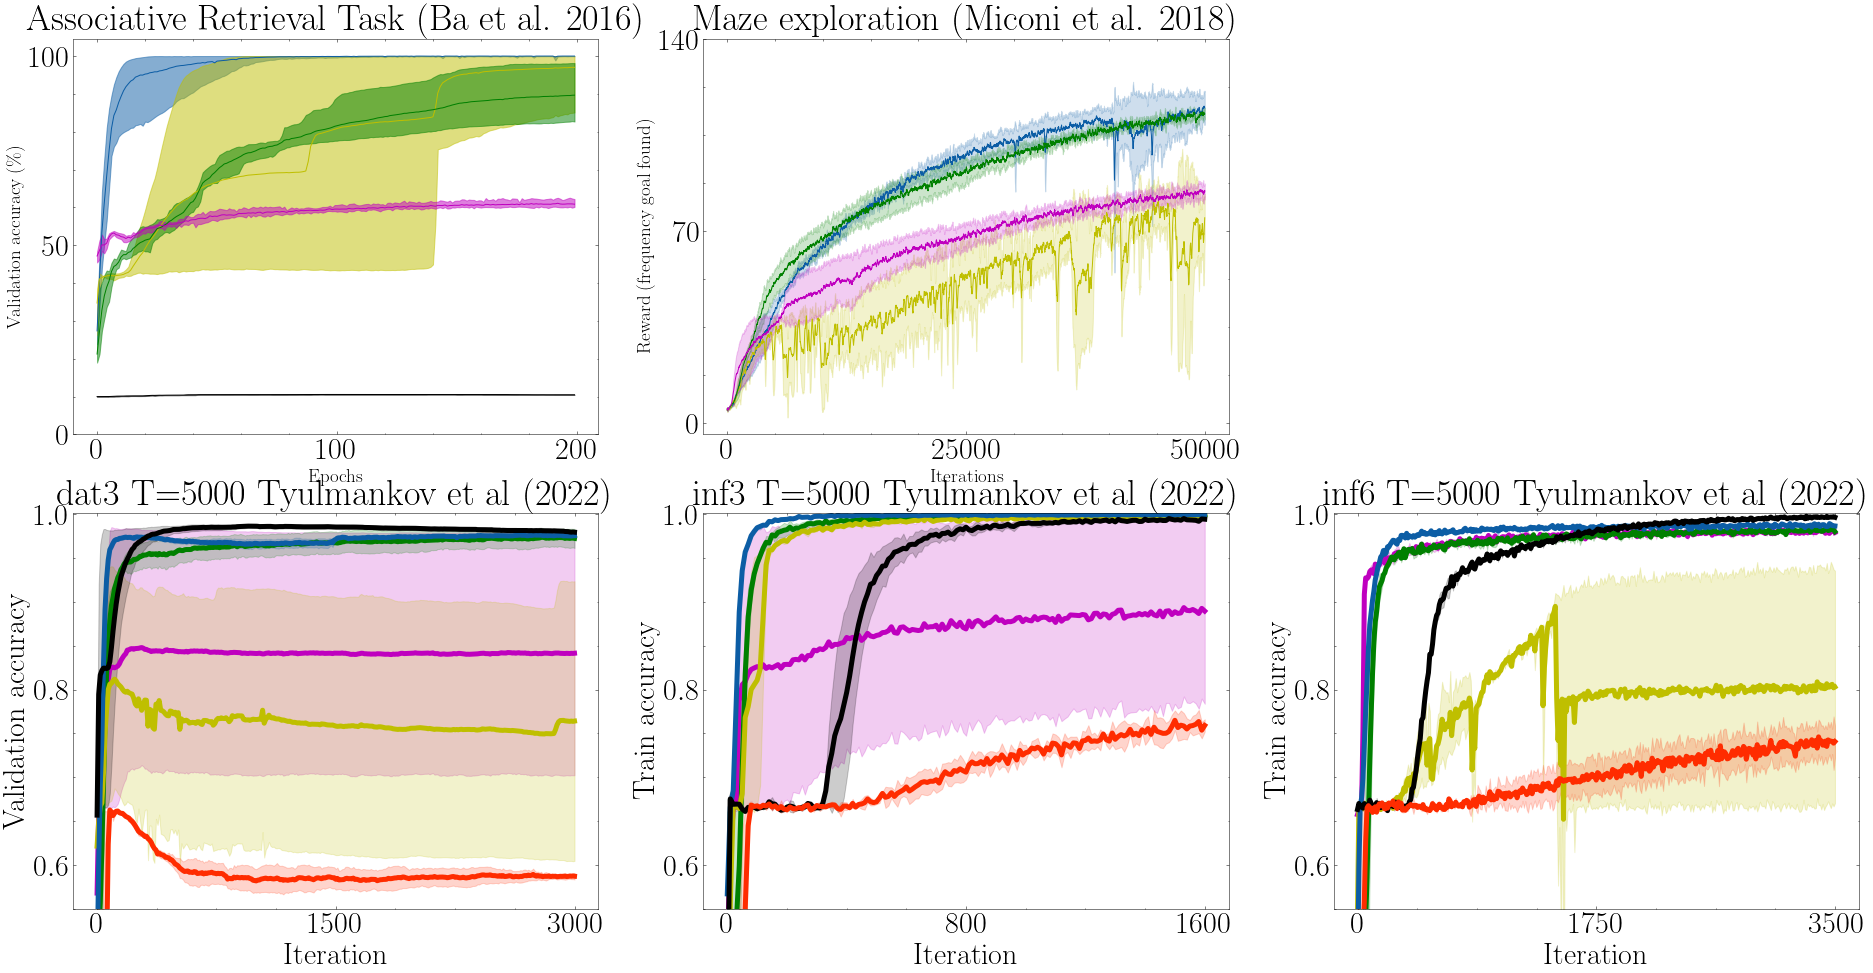

In [70]:
for idx_exp_var, this_exp_config in enumerate(each_exp_config):
    plt.sca(axs_abl[1, idx_exp_var])
    
    # override exp settings for each exp
    trainMode, R, plot_datasets = this_exp_config['trainMode'], this_exp_config['R'], this_exp_config['plot_datasets']

    full_results_paths = []
    for netType, netCfg in netTypes.items():
        N = netCfg['N']

        filename = f'{netType}[{d},{N},1]_train={trainMode}{R}'
        if trainMode == 'dat':
            filename += f'_T={T}'
        if force is not None:
            filename += f'_force{force}'
        filename += '*.pkl'
        # for some reason glob doesn't pick it up otherwise
        filename = filename.replace(']', '*')
        full_result_wildcard_path = os.path.join(path_all_results, filename)

        print('Looking for candidate results in', full_result_wildcard_path)
        filename_candidates = glob.glob(full_result_wildcard_path)
        e_mes = f"Not enough runs for {netType} in {trainMode} {R}. {n_runs_per_net} runs required, but {len(filename_candidates)} given"
        assert len(filename_candidates) >= n_runs_per_net, e_mes
            

        paths_this_net = []
        for i_run in range(n_runs_per_net):
            latest_run_path = max(filename_candidates, key=os.path.getctime)
            paths_this_net.append(latest_run_path)
            filename_candidates.remove(latest_run_path)
        # nested list
        full_results_paths.append(paths_this_net)

    this_plot, results_all_experiments[f'{trainMode}{R}'] = plot_loss_acc_comparison(
        full_results_paths, chance=None, n_runs_per_net=n_runs_per_net,
        plot_metrics=plot_metrics, plot_datasets=plot_datasets,
        colors = {k: v['color'] for k, v in netTypes.items()},
        include_legend = False, # True, #False, # False in this case as we want joint legend
        title = f' {trainMode}{R} T={T} Tyulmankov et al (2022)',
        linewidth=linewidths[this_experiment], # plot_linewidth,
        return_all_results=True,
        # if None, use ax. we want to plot with plt because we want to use this plot as a subplot
        subplot_coordinates = (1, idx_exp_var), 
        external_axs = axs_abl,
        alpha=alphas[this_experiment],
        model2label=model2label,
    )
    plot_storage.append(this_plot)

## Final Plots

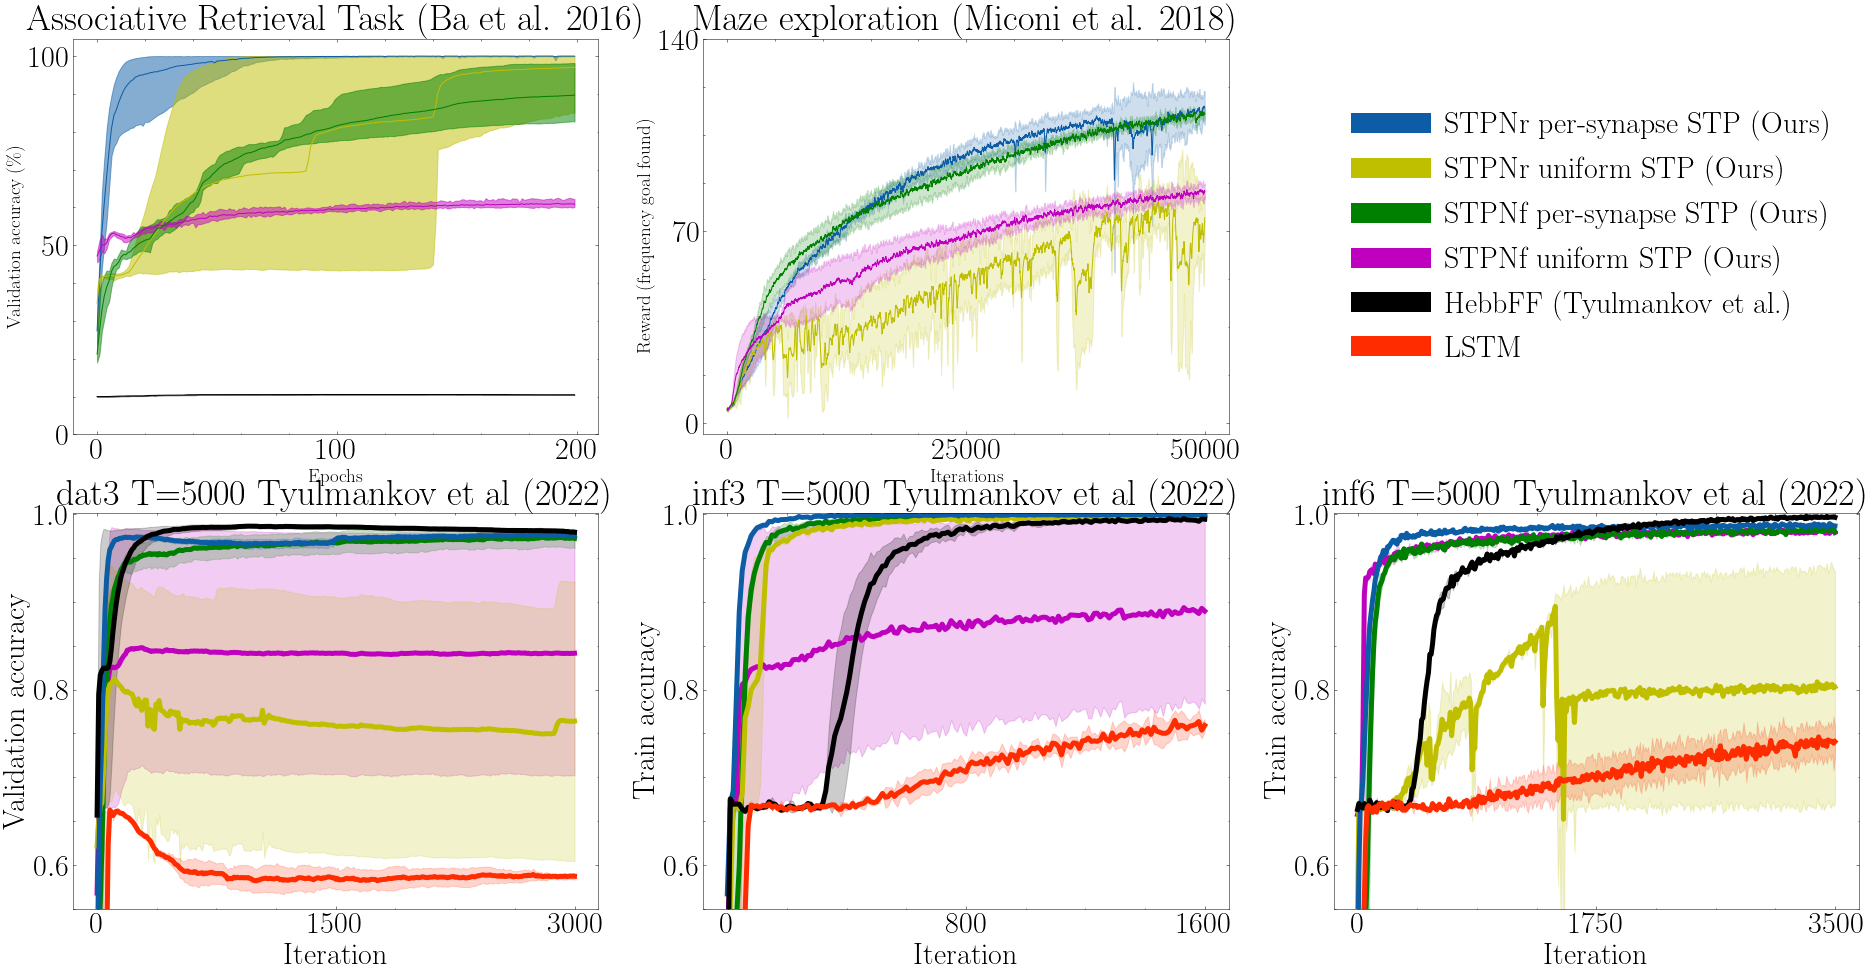

In [71]:
if prof_legend_subplots == 'joint':
    fig_abl, axs_abl = get_common_labels(fig_abl, axs=axs_abl, axs_loc_for_legend=(0,2),
                                        loc = "center", bbox_to_anchor=(0.5, 0.5), borderaxespad=0,
                                        legend_line_size=legend_line_size)

In [72]:
fig_abl.subplots_adjust(
    **adjust_6_subplots
)

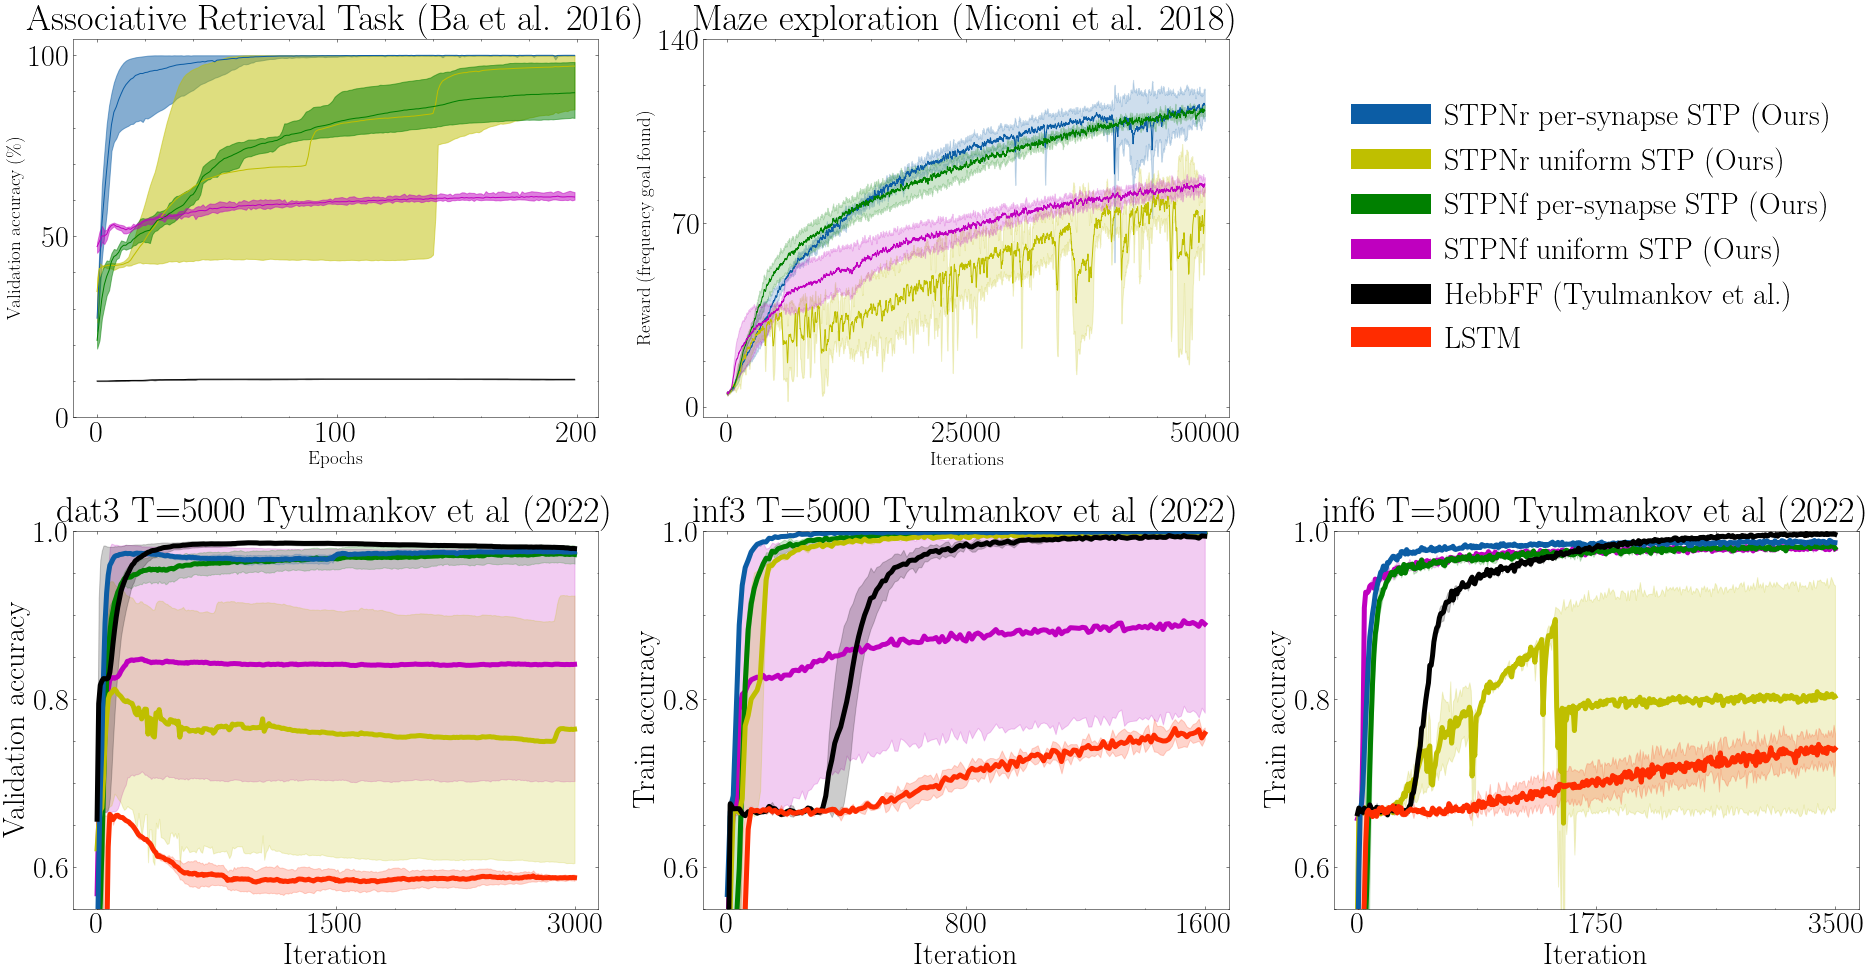

In [73]:
# fig_abl.savefig("Figures/ablation_per_synapse_recurrence_HebbFF.svg", format="svg", bbox_inches="tight")
# fig_abl.savefig("Figures/ablation_per_synapse_recurrence_HebbFF.pdf", format="pdf", bbox_inches="tight")
# fig_abl.savefig("Figures/ablation_per_synapse_recurrence_HebbFF.png", format="png", bbox_inches="tight")
fig_abl